In [1]:
import math
import numpy as np
import pickle
import torch
import matplotlib.pyplot as plt
import tqdm
import copy
from utils import *
import torch.nn as nn

if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print("device:", device)

# Setup seeds
np.random.seed(1102)
torch.manual_seed(1102)
torch.cuda.manual_seed(1102)
torch.backends.cudnn.deterministic = True

# Setup for experiments
dtype = torch.float
alpha = 0.05  # test threshold
batch_size = 2048  # batch size

x_in = 10  # number of neurons in the input layer, i.e., dimension of data
H = 30  # number of neurons in the hidden layer
x_out = 30  # number of neurons in the output layer

# learning_rate = 0.00005
learning_rate = 0.00001

N_EPOCH = 1000  # number of training epochs
N_TRAIL = 100  # number of trails
N_TEST = 100  # number of test sets
N_TEST_F = 100.0  # number of test sets (float)0
N_PER = 100  # permutation times

n_list = [125, 250, 500, 750, 1000, 1250]

device: cuda:0


In [9]:
def deep_kernel(X, Y, model, sigma_phi, sigma_q, epsilon=10**(-10)):
    Dxy = Pdist2(model(X), model(Y))
    Dxy_org = Pdist2(X, Y)

    return (1-epsilon) * torch.exp(-(Dxy / sigma_phi) - (Dxy_org / sigma_q)) + epsilon * torch.exp(-Dxy_org / sigma_q)

In [2]:
def generate_hdgm_cov_matrix(n_clusters, d, cluster_gap):
    mu_mx = np.zeros([n_clusters, d])
    for i in range(n_clusters):
        mu_mx[i] = mu_mx[i] + cluster_gap*i
    sigma_mx_1 = np.eye(d)
    sigma_mx_2 = [np.eye(d), np.eye(d)]
    sigma_mx_2[0][0, 1] = 0.5
    sigma_mx_2[0][1, 0] = 0.5
    sigma_mx_2[1][0, 1] = -0.5
    sigma_mx_2[1][1, 0] = -0.5

    return mu_mx, sigma_mx_1, sigma_mx_2


def sample_hdgm_semi_t2(n_train, n_test, d=10, n_clusters=2, kk=0, level="hard"):
    if level == "hard":
        mu_mx_1, sigma_mx_1, sigma_mx_2 = generate_hdgm_cov_matrix(n_clusters, d, 0.5)
        mu_mx_2 = mu_mx_1
    elif level == "medium":
        mu_mx_1, sigma_mx_1, sigma_mx_2 = generate_hdgm_cov_matrix(n_clusters, d, 10)
        mu_mx_2 = mu_mx_1
    else:
        mu_mx_1, sigma_mx_1, sigma_mx_2 = generate_hdgm_cov_matrix(n_clusters, d, 10)
        mu_mx_2 = mu_mx_1 - 1.5
    n = np.int64(n_train + n_test)

    s1 = np.zeros([n*n_clusters, d])
    s2 = np.zeros([n*n_clusters, d])

    np.random.seed(seed=1102*kk)
    # tr_idx = np.random.choice(n, n_train, replace=False)
    # tr_idx = np.tile(tr_idx, n_clusters)
    # for i in range(n_clusters):
    #     tr_idx[i*n_train:(i+1)*n_train] = tr_idx[i*n_train:(i+1)*n_train] + i*n

    tr_idx = np.random.choice(n*n_clusters, np.int64(n_train*n_clusters), replace=False)

    te_idx = np.delete(np.arange(n*n_clusters), tr_idx)

    for i in range(n_clusters):
        np.random.seed(seed=1102*kk + i + n)
        s1[i*n:(i+1)*n, :] = np.random.multivariate_normal(mu_mx_1[i], sigma_mx_1, n)
        np.random.seed(seed=819*kk + i + n + 1)
        s2[i*n:(i+1)*n, :] = np.random.multivariate_normal(mu_mx_2[i],
                                                           sigma_mx_2[i], n)

    return s1[tr_idx], s1[te_idx], s2[tr_idx], s2[te_idx]

(2000, 10) (2000,)


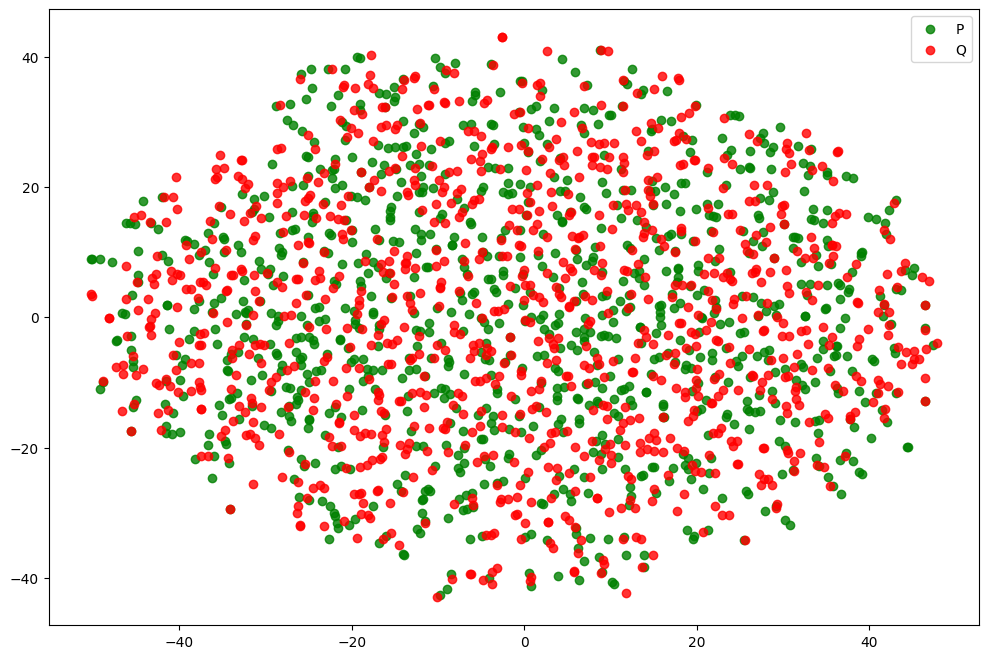

In [13]:
from sklearn.manifold import TSNE
# Present a T-SNE (t-distributed stochastic neighbor embedding) to reduce the dimensionality of the data


def tsne_plot(x, y, name="figure/default_graph.png"):
    print(x.shape, y.shape)
    tsne = TSNE(n_components=2, random_state=0)
    X_t = tsne.fit_transform(x)

    plt.figure(figsize=(12, 8))
    plt.scatter(X_t[np.where(y == 0), 0], X_t[np.where(y == 0), 1],
                marker="o", color="g", linewidths=1, alpha=0.8, label="P")
    plt.scatter(X_t[np.where(y == 1), 0], X_t[np.where(y == 1), 1],
                marker="o", color="r", linewidths=1, alpha=0.8, label="Q")

    plt.legend(loc="best")
    plt.savefig(name)
    plt.show()


tsne_plot(np.concatenate((s1_tr, s2_tr)),
          np.concatenate((np.zeros(1000), np.ones(1000))), "figure/HDGM_hd_sup.png")

In [11]:
s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(500, 500, kk=3, level="hard")
s1_md, _, s2_md, _ = sample_hdgm_semi_t2(500, 500, kk=3, level="medium")
s1_ez, _, s2_ez, _ = sample_hdgm_semi_t2(500, 500, kk=3, level="easy")

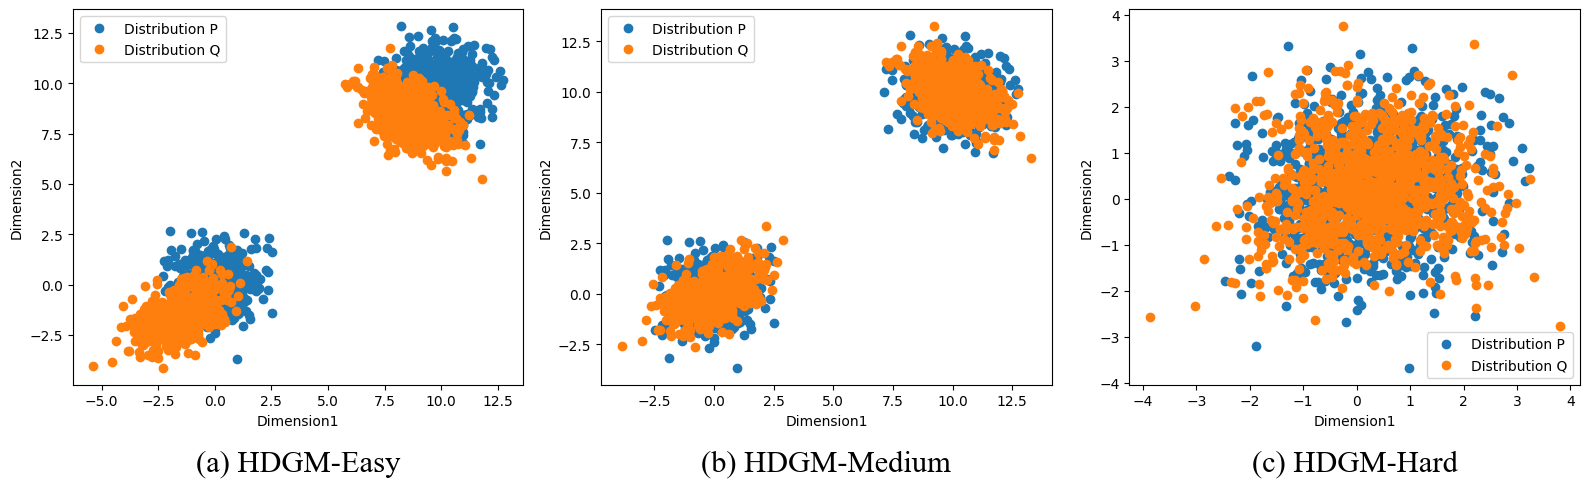

In [111]:
def add_gaussian_noise(X, noise_level=0.01, seed=None):
    if seed is not None:
        torch.manual_seed(seed)  # Set the random seed for PyTorch
    mean = 0
    std_dev = noise_level * (torch.max(X) - torch.min(X))
    noise = torch.normal(mean, std_dev, size=X.size()).to(
        X.device)  # Match the device
    X_noisy = X + noise
    return X_noisy
# s1_tr = add_gaussian_noise(s1_tr, noise_level=0.01, seed=3)
# s2_tr = add_gaussian_noise(s2_tr, noise_level=0.01, seed=3)

# s1_ez = add_gaussian_noise(torch.tensor(s1_ez), 0.01, seed=3)

# s2_ez = add_gaussian_noise(torch.tensor(s2_ez), 0.01, seed=3)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 5))

ax1.plot(s1_ez[:, 0], s1_ez[:, 1], 'o', label="Distribution P")
ax1.plot(s2_ez[:, 0], s2_ez[:, 1], 'o', label="Distribution Q")
ax1.set_xlabel("Dimension1")
ax1.set_ylabel("Dimension2")
ax1.set_title('(a) HDGM-Easy', y=-0.25,
              fontname='Times New Roman', fontsize=22)
# ax1_txt = '(a) HDGM-Easy'
# ax1.text(0.5, -0.3, ax1_txt, horizontalalignment='center',
#          verticalalignment='center', transform=ax1.transAxes, fontsize=24)

ax2.plot(s1_md[:, 0], s1_md[:, 1], 'o', label="Distribution P")
ax2.plot(s2_md[:, 0], s2_md[:, 1], 'o', label="Distribution Q")
ax2.set_xlabel("Dimension1")
ax2.set_ylabel("Dimension2")
ax2.set_title("(b) HDGM-Medium", y=-0.25,
              fontname='Times New Roman', fontsize=22)

ax3.plot(s1_tr[:, 0], s1_tr[:, 1], 'o', label="Distribution P")
ax3.plot(s2_tr[:, 0], s2_tr[:, 1], 'o', label="Distribution Q")
ax3.set_xlabel("Dimension1")
ax3.set_ylabel("Dimension2")
ax3.set_title("(c) HDGM-Hard", y=-0.25,
              fontname='Times New Roman', fontsize=22)

ax1.legend()
ax2.legend()
ax3.legend()
# lines, labels = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2,
#            loc='upper center', bbox_to_anchor=(-0.1, -0.1))

# Adjust layout
plt.tight_layout()
plt.savefig("HDGM_diff.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Experiment for C2ST and C2ST-M for HDGM

In [165]:
# n = 125
summary_total = []
for n in [500, 750, 1000]:
    n_train = n
    n_test = n_train

    summary_s = []
    summary_l = []   
    for kk in tqdm.trange(100):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(n_train, n_test, kk=kk, level="hard")
                
        N1 = s1_tr.shape[0]

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(np.int64(n_train*2)), torch.ones(np.int64(n_train*2)))).to(device, dtype).long()
            # (torch.zeros(25), torch.ones(25))).to(device, dtype).long()


        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
            S, y, x_in, H, x_out, 1000, batch_size, device, dtype, lr_c2st=0.005)

        # perform test
        H_C2ST_S = np.zeros([N_TEST])
        H_C2ST_L = np.zeros([N_TEST])
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        for k in range(N_TEST):
            H_C2ST_S[k], _, _ = TST_C2ST(S_test, np.int64(n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            H_C2ST_L[k], _, _ = TST_LCE(S_test, np.int64(n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_S[k], _, _ = TST_C2ST(S_test, 25, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_L[k], _, _ = TST_LCE(S_test, 25, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_L[k], _, _ = TST_MMD_l(model_C2ST_L(S_test), n_train*2, N_PER, alpha, k)
        # print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        print(f"Test Power of C2ST-S at n = {n}: ", H_C2ST_S.sum() / N_TEST_F)
        print(f"Test Power of C2ST-L at n = {n}: ", H_C2ST_L.sum() / N_TEST_F)
        summary_s.append(H_C2ST_S.sum() / N_TEST_F)
        summary_l.append(H_C2ST_L.sum() / N_TEST_F)

        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
    # c2st_baseline_result_t2.append((summary_s, summary_l))
        print("\n\n=====================================================")
        print("Average Test Power of C2ST-S: ", np.mean(summary_s))
        print("Average Test Power of C2ST-L: ", np.mean(summary_l))
        print("=====================================================\n\n")

    summary_total.append((np.mean(summary_s), np.mean(summary_l)))



  0%|          | 0/100 [00:00<?, ?it/s]

0.6661006808280945
0.6121653914451599
0.5652099847793579
0.5149610042572021
0.45739948749542236


  1%|          | 1/100 [00:12<21:20, 12.93s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.6672893166542053
0.6082055568695068
0.5720200538635254
0.5218353271484375
0.684964656829834


  2%|▏         | 2/100 [00:24<19:57, 12.22s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.5


0.6580445170402527
0.6060903072357178
0.5761865377426147
0.6276424527168274
0.4732927083969116


  3%|▎         | 3/100 [00:36<19:22, 11.99s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.6666666666666666


0.650467574596405
0.5953916311264038
0.5482230186462402
0.5028549432754517
0.45420965552330017


  4%|▍         | 4/100 [00:48<19:05, 11.94s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.75


0.6450276374816895
0.6069965958595276
0.5821181535720825
0.5918788909912109
0.5293857455253601


  5%|▌         | 5/100 [01:04<21:11, 13.38s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.8


0.6478033661842346
0.5663856267929077
0.5151024460792542
0.45578351616859436
0.40483173727989197


  6%|▌         | 6/100 [01:29<27:19, 17.45s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.8333333333333334


0.6416406631469727
0.585204541683197
0.5316371321678162
0.6385155916213989
0.4459403157234192


  7%|▋         | 7/100 [01:42<24:56, 16.09s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5714285714285714
Average Test Power of C2ST-L:  0.8571428571428571


0.6635955572128296
0.6090525984764099
0.5735983848571777
0.5024533867835999
0.454692542552948


  8%|▊         | 8/100 [01:54<22:40, 14.79s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.625
Average Test Power of C2ST-L:  0.875


0.6679463982582092
0.5972597002983093
0.5587779879570007
0.4778902530670166
0.4413449466228485


  9%|▉         | 9/100 [02:06<21:01, 13.86s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  0.8888888888888888


0.6606423854827881
0.5909467935562134
0.5912989974021912
0.5083633661270142
0.48842427134513855


 10%|█         | 10/100 [02:18<19:59, 13.33s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.7
Average Test Power of C2ST-L:  0.9


0.6612902283668518
0.6225991249084473
0.6008442640304565
0.5706342458724976
0.5330144166946411


 11%|█         | 11/100 [02:35<21:22, 14.41s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.6363636363636364
Average Test Power of C2ST-L:  0.9090909090909091


0.6619135737419128
0.5981825590133667
0.5490212440490723
0.4978705048561096
0.4573248028755188


 12%|█▏        | 12/100 [02:47<20:02, 13.66s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5833333333333334
Average Test Power of C2ST-L:  0.8333333333333334


0.6429169774055481
0.5837035775184631
0.5415507555007935
0.5014022588729858
0.45816904306411743


 13%|█▎        | 13/100 [02:58<18:49, 12.98s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.6153846153846154
Average Test Power of C2ST-L:  0.8461538461538461


0.6593130230903625
0.6054543256759644
0.5712108016014099
0.6234793066978455
0.4687339961528778


 14%|█▍        | 14/100 [03:11<18:15, 12.74s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.6428571428571429
Average Test Power of C2ST-L:  0.8571428571428571


0.6594562530517578
0.6111574769020081
0.5767003297805786
0.5414363741874695
0.5090920925140381


 15%|█▌        | 15/100 [03:22<17:37, 12.44s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.6
Average Test Power of C2ST-L:  0.8


0.6516135931015015
0.5967746376991272
0.5440856218338013
0.49863550066947937
0.640297532081604


 16%|█▌        | 16/100 [03:34<17:05, 12.21s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5625
Average Test Power of C2ST-L:  0.8125


0.6596035957336426
0.661721408367157
0.5627054572105408
0.5211235880851746
0.47775888442993164


 17%|█▋        | 17/100 [03:46<16:53, 12.21s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5294117647058824
Average Test Power of C2ST-L:  0.7647058823529411


0.6480957269668579
0.6031069755554199
0.5739397406578064
0.5789671540260315
0.5235836505889893


 18%|█▊        | 18/100 [03:59<16:42, 12.22s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.7777777777777778


0.6567440032958984
0.6131402254104614
0.5743271708488464
0.5421253442764282
0.4985280930995941


 19%|█▉        | 19/100 [04:11<16:29, 12.21s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5789473684210527
Average Test Power of C2ST-L:  0.7894736842105263


0.6579303741455078
0.590812623500824
0.5372298359870911
0.4821659028530121
0.43804731965065


 20%|██        | 20/100 [04:23<16:07, 12.09s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.6
Average Test Power of C2ST-L:  0.8


0.6681182980537415
0.6141782999038696
0.575018048286438
0.5246647596359253
0.4646413326263428


 21%|██        | 21/100 [04:35<15:55, 12.09s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5714285714285714
Average Test Power of C2ST-L:  0.7619047619047619


0.6653725504875183
0.6221281886100769
0.5457128286361694
0.5811363458633423
0.47905319929122925


 22%|██▏       | 22/100 [04:47<15:43, 12.10s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5909090909090909
Average Test Power of C2ST-L:  0.7272727272727273


0.6498197317123413
0.5986152291297913
0.5614073276519775
0.5178380012512207
0.4799065887928009


 23%|██▎       | 23/100 [04:59<15:32, 12.11s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.6086956521739131
Average Test Power of C2ST-L:  0.7391304347826086


0.6341294050216675
0.5932166576385498
0.5468783974647522
0.499754935503006
0.45740124583244324


 24%|██▍       | 24/100 [05:11<15:20, 12.11s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5833333333333334
Average Test Power of C2ST-L:  0.7083333333333334


0.6550136804580688
0.6001273393630981
0.5457367300987244
0.5077521204948425
0.45871663093566895


 25%|██▌       | 25/100 [05:23<15:06, 12.09s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.56
Average Test Power of C2ST-L:  0.68


0.6595704555511475
0.6281252503395081
0.5881171822547913
0.5401740670204163
0.49939268827438354


 26%|██▌       | 26/100 [05:35<14:53, 12.08s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5769230769230769
Average Test Power of C2ST-L:  0.6923076923076923


0.6529285907745361
0.631536066532135
0.5953039526939392
0.48205485939979553
0.47706663608551025


 27%|██▋       | 27/100 [05:47<14:41, 12.08s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.6666666666666666


0.6673528552055359
0.5946682095527649
0.5453164577484131
0.481084406375885
0.418443888425827


 28%|██▊       | 28/100 [05:59<14:28, 12.06s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5714285714285714
Average Test Power of C2ST-L:  0.6785714285714286


0.6384389996528625
0.5958586931228638
0.5422448515892029
0.5050528049468994
0.46738186478614807


 29%|██▉       | 29/100 [06:11<14:17, 12.08s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5517241379310345
Average Test Power of C2ST-L:  0.6551724137931034


0.644035816192627
0.6053281426429749
0.6194362640380859
0.5222083330154419
0.47811388969421387


 30%|███       | 30/100 [06:23<14:03, 12.05s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5333333333333333
Average Test Power of C2ST-L:  0.6333333333333333


0.6612333655357361
0.6073599457740784
0.5463246703147888
0.4745572507381439
0.41101497411727905


 31%|███       | 31/100 [06:35<13:50, 12.04s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5483870967741935
Average Test Power of C2ST-L:  0.6451612903225806


0.644367516040802
0.6059705018997192
0.5517966151237488
0.5137100219726562
0.463514119386673


 32%|███▏      | 32/100 [06:47<13:38, 12.04s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5625
Average Test Power of C2ST-L:  0.65625


0.6579304933547974
0.6166847348213196
0.5715172290802002
0.5267139673233032
0.566774308681488


 33%|███▎      | 33/100 [06:59<13:26, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5454545454545454
Average Test Power of C2ST-L:  0.6363636363636364


0.6526657342910767
0.6375975012779236
0.5299564003944397
0.47543764114379883
0.3959696888923645


 34%|███▍      | 34/100 [07:11<13:15, 12.05s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5588235294117647
Average Test Power of C2ST-L:  0.6470588235294118


0.6649667024612427
0.5917994379997253
0.5474241375923157
0.5030420422554016
0.465994268655777


 35%|███▌      | 35/100 [07:23<13:02, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5428571428571428
Average Test Power of C2ST-L:  0.6285714285714286


0.6554920673370361
0.6304307579994202
0.5548116564750671
0.5775274634361267
0.4700043797492981


 36%|███▌      | 36/100 [07:35<12:50, 12.03s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.6388888888888888


0.6665188670158386
0.6200419664382935
0.5842150449752808
0.5313135385513306
0.4831603765487671


 37%|███▋      | 37/100 [07:48<12:39, 12.06s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5405405405405406
Average Test Power of C2ST-L:  0.6486486486486487


0.6608394384384155
0.6062608957290649
0.5775128602981567
0.5184330344200134
0.47998303174972534


 38%|███▊      | 38/100 [08:00<12:26, 12.03s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5526315789473685
Average Test Power of C2ST-L:  0.6578947368421053


0.6689721941947937
0.6024242639541626
0.5489944815635681
0.49395737051963806
0.43625393509864807


 39%|███▉      | 39/100 [08:12<12:15, 12.05s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5384615384615384
Average Test Power of C2ST-L:  0.6410256410256411


0.630720317363739
0.5896079540252686
0.5499386191368103
0.49292153120040894
0.429500550031662


 40%|████      | 40/100 [08:24<12:02, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.525
Average Test Power of C2ST-L:  0.65


0.642211377620697
0.5972345471382141
0.5591853857040405
0.5168238282203674
0.5258668065071106


 41%|████      | 41/100 [08:36<11:50, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5121951219512195
Average Test Power of C2ST-L:  0.6341463414634146


0.653901994228363
0.6041088700294495
0.5785189270973206
0.5740099549293518
0.49034205079078674


 42%|████▏     | 42/100 [08:48<11:39, 12.06s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.6190476190476191


0.6673243641853333
0.622763991355896
0.5651541352272034
0.5324588418006897
0.47483110427856445


 43%|████▎     | 43/100 [09:00<11:27, 12.06s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5116279069767442
Average Test Power of C2ST-L:  0.627906976744186


0.6439468264579773
0.6168393492698669
0.5831859707832336
0.5463367700576782
0.5144414305686951


 44%|████▍     | 44/100 [09:12<11:14, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.6363636363636364


0.6611465811729431
0.6237729787826538
0.586811900138855
0.5605114102363586
0.5000835061073303


 45%|████▌     | 45/100 [09:24<11:02, 12.04s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5111111111111111
Average Test Power of C2ST-L:  0.6444444444444445


0.6666826605796814
0.5937021374702454
0.5455723404884338
0.5165349245071411
0.48046356439590454


 46%|████▌     | 46/100 [09:36<10:49, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.6521739130434783


0.6750537753105164
0.613473117351532
0.5475119352340698
0.5072383284568787
0.43515869975090027


 47%|████▋     | 47/100 [09:48<10:38, 12.05s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.48936170212765956
Average Test Power of C2ST-L:  0.6382978723404256


0.659981906414032
0.6240682005882263
0.5729190111160278
0.5337266325950623
0.4932727515697479


 48%|████▊     | 48/100 [10:00<10:25, 12.02s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4791666666666667
Average Test Power of C2ST-L:  0.625


0.670434832572937
0.6292232871055603
0.5847065448760986
0.5258179306983948
0.4665916860103607


 49%|████▉     | 49/100 [10:12<10:13, 12.03s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.46938775510204084
Average Test Power of C2ST-L:  0.6326530612244898


0.6378909945487976
0.5763942003250122
0.5434384942054749
0.4880196452140808
0.44942328333854675


 50%|█████     | 50/100 [10:24<10:02, 12.06s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.46
Average Test Power of C2ST-L:  0.64


0.6504371762275696
0.6073728203773499
0.5585330128669739
0.5087369084358215
0.4649607837200165


 51%|█████     | 51/100 [10:36<09:51, 12.07s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.47058823529411764
Average Test Power of C2ST-L:  0.6470588235294118


0.6520819067955017
0.5954700112342834
0.566972553730011
0.5145007967948914
0.6589930653572083


 52%|█████▏    | 52/100 [10:48<09:39, 12.08s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.46153846153846156
Average Test Power of C2ST-L:  0.6538461538461539


0.6610391139984131
0.5871803164482117
0.5228840708732605
0.4684922695159912
0.42482990026474


 53%|█████▎    | 53/100 [11:00<09:26, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4528301886792453
Average Test Power of C2ST-L:  0.6415094339622641


0.6426613330841064
0.6008046865463257
0.5659665465354919
0.5320321917533875
0.4887656271457672


 54%|█████▍    | 54/100 [11:12<09:14, 12.06s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6481481481481481


0.6606602668762207
0.612925112247467
0.5680970549583435
0.5309551358222961
0.5134698748588562


 55%|█████▌    | 55/100 [11:24<09:02, 12.06s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.6545454545454545


0.6518847942352295
0.6197120547294617
0.581857442855835
0.5656336545944214
0.49697819352149963


 56%|█████▌    | 56/100 [11:37<08:50, 12.06s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.44642857142857145
Average Test Power of C2ST-L:  0.6428571428571429


0.6616052985191345
0.6072078347206116
0.5593408346176147
0.49261218309402466
0.43371814489364624


 57%|█████▋    | 57/100 [11:49<08:37, 12.04s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45614035087719296
Average Test Power of C2ST-L:  0.6491228070175439


0.6561920046806335
0.6084843277931213
0.563139021396637
0.46671316027641296
0.40708306431770325


 58%|█████▊    | 58/100 [12:01<08:28, 12.10s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.46551724137931033
Average Test Power of C2ST-L:  0.6551724137931034


0.647116482257843
0.6211932897567749
0.5969004034996033
0.647689938545227
0.5034863948822021


 59%|█████▉    | 59/100 [12:13<08:16, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4576271186440678
Average Test Power of C2ST-L:  0.6440677966101694


0.6524123549461365
0.5992512702941895
0.5892007350921631
0.48862728476524353
0.4461037814617157


 60%|██████    | 60/100 [12:25<08:05, 12.13s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.65


0.6702246069908142
0.6244216561317444
0.5880022644996643
0.627385139465332
0.5171284675598145


 61%|██████    | 61/100 [12:37<07:52, 12.12s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45901639344262296
Average Test Power of C2ST-L:  0.6557377049180327


0.644120991230011
0.6045594811439514
0.5549949407577515
0.5104297399520874
0.4609958231449127


 62%|██████▏   | 62/100 [12:49<07:39, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.45161290322580644
Average Test Power of C2ST-L:  0.6451612903225806


0.6430107951164246
0.6171396374702454
0.5788959264755249
0.5748408436775208
0.4528532028198242


 63%|██████▎   | 63/100 [13:01<07:27, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6349206349206349


0.6602851152420044
0.6155644655227661
0.5971304774284363
0.5854808688163757
0.5269306898117065


 64%|██████▍   | 64/100 [13:13<07:14, 12.08s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4375
Average Test Power of C2ST-L:  0.640625


0.6580601334571838
0.5834648609161377
0.5369569659233093
0.5206968784332275
0.4147350788116455


 65%|██████▌   | 65/100 [13:26<07:03, 12.10s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4461538461538462
Average Test Power of C2ST-L:  0.6461538461538462


0.660902738571167
0.6243671178817749
0.5855713486671448
0.5434291362762451
0.5032731890678406


 66%|██████▌   | 66/100 [13:38<06:50, 12.08s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.6515151515151515


0.6701034903526306
0.6346952319145203
0.5726512670516968
0.521685779094696
0.46999016404151917


 67%|██████▋   | 67/100 [13:50<06:38, 12.07s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4626865671641791
Average Test Power of C2ST-L:  0.6417910447761194


0.6481360793113708
0.5750120282173157
0.5309633016586304
0.5185527205467224
0.40424615144729614


 68%|██████▊   | 68/100 [14:02<06:27, 12.09s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.47058823529411764
Average Test Power of C2ST-L:  0.6470588235294118


0.6492112278938293
0.6172435283660889
0.6110005378723145
0.5518718957901001
0.5144563317298889


 69%|██████▉   | 69/100 [14:14<06:14, 12.09s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.463768115942029
Average Test Power of C2ST-L:  0.6376811594202898


0.6540912985801697
0.6076314449310303
0.5682085156440735
0.5121701955795288
0.46627277135849


 70%|███████   | 70/100 [14:26<06:03, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.45714285714285713
Average Test Power of C2ST-L:  0.6285714285714286


0.6587446928024292
0.624030590057373
0.5508840680122375
0.48731517791748047
0.4379810392856598


 71%|███████   | 71/100 [14:38<05:49, 12.07s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4647887323943662
Average Test Power of C2ST-L:  0.6338028169014085


0.669734001159668
0.6520317792892456
0.5613385438919067
0.6146623492240906
0.4516890347003937


 72%|███████▏  | 72/100 [14:50<05:37, 12.07s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4583333333333333
Average Test Power of C2ST-L:  0.6388888888888888


0.6629387736320496
0.6050703525543213
0.5856043100357056
0.5460750460624695
0.545964777469635


 73%|███████▎  | 73/100 [15:02<05:26, 12.08s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4657534246575342
Average Test Power of C2ST-L:  0.6438356164383562


0.6522696018218994
0.5850167870521545
0.5395592451095581
0.5146982669830322
0.4636874496936798


 74%|███████▍  | 74/100 [15:14<05:13, 12.07s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.47297297297297297
Average Test Power of C2ST-L:  0.6486486486486487


0.6321083307266235
0.593744695186615
0.5474310517311096
0.5190868377685547
0.48036453127861023


 75%|███████▌  | 75/100 [15:26<05:02, 12.09s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4666666666666667
Average Test Power of C2ST-L:  0.6533333333333333


0.649718165397644
0.6024414300918579
0.5764764547348022
0.560694694519043
0.5166706442832947


 76%|███████▌  | 76/100 [15:38<04:49, 12.08s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4605263157894737
Average Test Power of C2ST-L:  0.6447368421052632


0.653333306312561
0.5928455591201782
0.5352266430854797
0.4827265739440918
0.45845356583595276


 77%|███████▋  | 77/100 [15:50<04:37, 12.06s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4675324675324675
Average Test Power of C2ST-L:  0.6493506493506493


0.6434853076934814
0.7101078033447266
0.5541254878044128
0.5233015418052673
0.5207814574241638


 78%|███████▊  | 78/100 [16:02<04:25, 12.06s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.46153846153846156
Average Test Power of C2ST-L:  0.6538461538461539


0.6464967131614685
0.5754987001419067
0.5712534785270691
0.4456811845302582
0.41663670539855957


 79%|███████▉  | 79/100 [16:14<04:12, 12.03s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.45569620253164556
Average Test Power of C2ST-L:  0.6455696202531646


0.6423961520195007
0.6008811593055725
0.559052586555481
0.5085206627845764
0.46028393507003784


 80%|████████  | 80/100 [16:26<04:00, 12.03s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.65


0.6637454628944397
0.6123380661010742
0.5687218904495239
0.513469398021698
0.4524471163749695


 81%|████████  | 81/100 [16:39<03:48, 12.05s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.654320987654321


0.6405792236328125
0.6003203988075256
0.6578090190887451
0.5157801508903503
0.48528939485549927


 82%|████████▏ | 82/100 [16:50<03:36, 12.02s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45121951219512196
Average Test Power of C2ST-L:  0.6585365853658537


0.6676164865493774
0.5979645848274231
0.5501306653022766
0.5006821751594543
0.5257319808006287


 83%|████████▎ | 83/100 [17:03<03:24, 12.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4457831325301205
Average Test Power of C2ST-L:  0.6506024096385542


0.6539186239242554
0.5908547639846802
0.5218484401702881
0.48888376355171204
0.5407330393791199


 84%|████████▍ | 84/100 [17:15<03:12, 12.04s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4523809523809524
Average Test Power of C2ST-L:  0.6547619047619048


0.6428371667861938
0.6032878756523132
0.5885091423988342
0.5349818468093872
0.509423017501831


 85%|████████▌ | 85/100 [17:27<03:01, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4470588235294118
Average Test Power of C2ST-L:  0.6470588235294118


0.6648275852203369
0.601505696773529
0.5747314691543579
0.5046871900558472
0.46504127979278564


 86%|████████▌ | 86/100 [17:39<02:49, 12.12s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4418604651162791
Average Test Power of C2ST-L:  0.6395348837209303


0.6432964205741882
0.607664167881012
0.5786372423171997
0.56033855676651
0.5134977102279663


 87%|████████▋ | 87/100 [17:51<02:37, 12.11s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4482758620689655
Average Test Power of C2ST-L:  0.6436781609195402


0.6510155200958252
0.6066002249717712
0.5604474544525146
0.5311181545257568
0.47353750467300415


 88%|████████▊ | 88/100 [18:03<02:25, 12.12s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.6477272727272727


0.6408753395080566
0.5824412107467651
0.5426632761955261
0.4923698604106903
0.49841439723968506


 89%|████████▉ | 89/100 [18:15<02:12, 12.09s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.449438202247191
Average Test Power of C2ST-L:  0.6404494382022472


0.6612852215766907
0.6167411208152771
0.5886902213096619
0.559492290019989
0.5225510597229004


 90%|█████████ | 90/100 [18:27<02:00, 12.07s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6333333333333333


0.6584645509719849
0.605583667755127
0.5534504055976868
0.5164006948471069
0.48417508602142334


 91%|█████████ | 91/100 [18:39<01:48, 12.07s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.43956043956043955
Average Test Power of C2ST-L:  0.6263736263736264


0.642076849937439
0.5713017582893372
0.5321671962738037
0.4896083474159241
0.4841541647911072


 92%|█████████▏| 92/100 [18:51<01:36, 12.08s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.44565217391304346
Average Test Power of C2ST-L:  0.6304347826086957


0.6631953120231628
0.6187772750854492
0.5763289332389832
0.5417522192001343
0.5119476914405823


 93%|█████████▎| 93/100 [19:04<01:24, 12.11s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.45161290322580644
Average Test Power of C2ST-L:  0.6344086021505376


0.6480193734169006
0.6005845069885254
0.5627889633178711
0.537494421005249
0.5078484416007996


 94%|█████████▍| 94/100 [19:16<01:12, 12.13s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4574468085106383
Average Test Power of C2ST-L:  0.6382978723404256


0.6669111251831055
0.6219819784164429
0.5745385885238647
0.5286222696304321
0.4914669692516327


 95%|█████████▌| 95/100 [19:28<01:00, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.45263157894736844
Average Test Power of C2ST-L:  0.631578947368421


0.6408187747001648
0.5934851169586182
0.5619921684265137
0.5303651094436646
0.48301196098327637


 96%|█████████▌| 96/100 [19:40<00:48, 12.12s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4479166666666667
Average Test Power of C2ST-L:  0.6354166666666666


0.665583610534668
0.6331697702407837
0.5952860116958618
0.5522669553756714
0.4996841549873352


 97%|█████████▋| 97/100 [19:52<00:36, 12.11s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.44329896907216493
Average Test Power of C2ST-L:  0.6391752577319587


0.6494055986404419
0.6131113767623901
0.6444931030273438
0.5606434941291809
0.5389739274978638


 98%|█████████▊| 98/100 [20:04<00:24, 12.12s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4489795918367347
Average Test Power of C2ST-L:  0.6428571428571429


0.6577712297439575
0.6099944710731506
0.5650429129600525
0.5170185565948486
0.4697364866733551


 99%|█████████▉| 99/100 [20:16<00:12, 12.10s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6464646464646465


0.6503950953483582
0.6038249731063843
0.5706250667572021
0.5060069561004639
0.416130930185318


100%|██████████| 100/100 [20:28<00:00, 12.29s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.44
Average Test Power of C2ST-L:  0.64




In [156]:
summary_total

[(0.82, 0.96), (0.97, 1.0)]

In [9]:
def add_gaussian_noise(X, noise_level=0.01, seed=0):
    mean = 0
    std_dev = noise_level * (np.max(X) - np.min(X))
    np.random.seed(seed)
    noise = np.random.normal(mean, std_dev, X.shape)
    X_noisy = X + noise
    return X_noisy

n = 250
n_train = n
n_test = n_train

summary_s = []
summary_l = []
for kk in tqdm.trange(100):
    s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
        n_train, n_test, kk=kk, hard=False)

    N1 = s1_tr.shape[0]

    s1_tr_aug = add_gaussian_noise(s1_tr, noise_level=0.01, seed=kk*819 + n)
    s2_tr_aug = add_gaussian_noise(s2_tr, noise_level=0.01, seed=kk*1019 + n)
    S = np.concatenate((s1_tr, s1_tr_aug, s2_tr, s2_tr_aug), axis=0)
    S = MatConvert(S, device, dtype)

    y = torch.concat(
        (torch.zeros(n_train*4), torch.ones(n_train*4))).to(device, dtype).long()

    model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
        S, y, x_in, H, x_out, 1000, batch_size, device, dtype, lr_c2st=0.005)

    # perform test
    H_C2ST_S = np.zeros([N_TEST])
    H_C2ST_L = np.zeros([N_TEST])
    S_test = np.concatenate((s1_te, s2_te), axis=0)
    S_test = MatConvert(S_test, device, dtype)

    for k in range(N_TEST):
        H_C2ST_S[k], _, _ = TST_C2ST(
            S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        H_C2ST_L[k], _, _ = TST_LCE(
            S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # H_C2ST_L[k], _, _ = TST_MMD_l(model_C2ST_L(S_test), n_train*2, N_PER, alpha, k)
    # print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
    print(f"Test Power of C2ST-S at n = {n}: ", H_C2ST_S.sum() / N_TEST_F)
    print(f"Test Power of C2ST-L at n = {n}: ", H_C2ST_L.sum() / N_TEST_F)
    summary_s.append(H_C2ST_S.sum() / N_TEST_F)
    summary_l.append(H_C2ST_L.sum() / N_TEST_F)

    # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
    # summary.append(h1)
# c2st_baseline_result_t2.append((summary_s, summary_l))
print("\n\n=====================================================")
print("Average Test Power of C2ST-S: ", np.mean(summary_s))
print("Average Test Power of C2ST-L: ", np.mean(summary_l))
print("=====================================================\n\n")

  0%|          | 0/100 [00:00<?, ?it/s]

0.6661413908004761
0.6228631138801575
0.6032973527908325
0.5289952754974365
0.4841250479221344


  1%|          | 1/100 [00:16<27:52, 16.89s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6659227013587952
0.6027836799621582
0.5939008593559265
0.5301598906517029
0.5070512294769287


  2%|▏         | 2/100 [00:33<27:34, 16.88s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6556857824325562
0.6087591052055359
0.5624819993972778
0.5179064869880676
0.44207412004470825


  3%|▎         | 3/100 [00:51<27:33, 17.04s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6520178914070129
0.6082566976547241
0.5724851489067078
0.5323885679244995
0.4987095296382904


  4%|▍         | 4/100 [01:07<27:11, 16.99s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6453312039375305
0.6248956918716431
0.5902649760246277
0.5658780336380005
0.5273733735084534


  5%|▌         | 5/100 [01:24<26:56, 17.02s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6469351649284363
0.5665819048881531
0.5141721367835999
0.46759897470474243
0.4286441206932068


  6%|▌         | 6/100 [01:41<26:35, 16.97s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6418930888175964
0.6139549612998962
0.5402678847312927
0.49682438373565674
0.4454094171524048


  7%|▋         | 7/100 [01:58<26:00, 16.78s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6643449068069458
0.6107524037361145
0.6403869986534119
0.5100322365760803
0.4483086168766022


  8%|▊         | 8/100 [02:15<25:50, 16.85s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6686700582504272
0.6001289486885071
0.5997560024261475
0.494197279214859
0.4348975419998169


  9%|▉         | 9/100 [02:32<25:35, 16.87s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6620233058929443
0.6235148310661316
0.5494566559791565
0.5122317671775818
0.4779878258705139


 10%|█         | 10/100 [02:49<25:19, 16.88s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6616451144218445
0.6260115504264832
0.5958974957466125
0.5732420682907104
0.5295860171318054


 11%|█         | 11/100 [03:06<25:07, 16.94s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6608154773712158
0.6360857486724854
0.5470582246780396
0.6454696655273438
0.4989200234413147


 12%|█▏        | 12/100 [03:23<24:56, 17.00s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6435525417327881
0.6044094562530518
0.5407789349555969
0.5026972889900208
0.4659353196620941


 13%|█▎        | 13/100 [03:40<24:36, 16.98s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6599475145339966
0.6166066527366638
0.572502076625824
0.5256254076957703
0.503338098526001


 14%|█▍        | 14/100 [03:57<24:17, 16.95s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6594150066375732
0.6212921738624573
0.6546412110328674
0.5523726940155029
0.5180010199546814


 15%|█▌        | 15/100 [04:13<23:57, 16.91s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.654473066329956
0.6034146547317505
0.5778179168701172
0.5306927561759949
0.5267958045005798


 16%|█▌        | 16/100 [04:30<23:37, 16.88s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6588383316993713
0.6105659604072571
0.567082941532135
0.5644212365150452
0.49940863251686096


 17%|█▋        | 17/100 [04:46<22:55, 16.57s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6478715538978577
0.5994094014167786
0.5761409997940063
0.5539740920066833
0.515141487121582


 18%|█▊        | 18/100 [05:02<22:29, 16.45s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6567016243934631
0.6206126809120178
0.5841779708862305
0.5570197701454163
0.5100114345550537


 19%|█▉        | 19/100 [05:19<22:23, 16.59s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6600776314735413
0.6087350845336914
0.5467613935470581
0.5046060085296631
0.47376710176467896


 20%|██        | 20/100 [05:48<27:03, 20.30s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6660709381103516
0.6216884255409241
0.5880346894264221
0.5392844080924988
0.4930742681026459


 21%|██        | 21/100 [06:26<33:35, 25.51s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6633276343345642
0.6312357783317566
0.5543749928474426
0.5069427490234375
0.4651942253112793


 22%|██▏       | 22/100 [07:03<37:48, 29.08s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.650650143623352
0.5960043668746948
0.5607869625091553
0.5412750244140625
0.5007755756378174


 23%|██▎       | 23/100 [07:42<41:01, 31.97s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6389955282211304
0.5938060283660889
0.5523179769515991
0.528476357460022
0.5265786647796631


 24%|██▍       | 24/100 [08:19<42:26, 33.50s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6514962315559387
0.608479917049408
0.5625902414321899
0.5175620913505554
0.4566994905471802


 25%|██▌       | 25/100 [08:56<43:19, 34.66s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6622195839881897
0.6233192682266235
0.5839227437973022
0.5472831130027771
0.6735257506370544


 26%|██▌       | 26/100 [09:16<37:20, 30.28s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6530176401138306
0.6112645864486694
0.5524274110794067
0.49999311566352844
0.5214941501617432


 27%|██▋       | 27/100 [09:33<31:52, 26.20s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6689571142196655
0.6083470582962036
0.5714341402053833
0.5155215859413147
0.49576085805892944


 28%|██▊       | 28/100 [09:50<28:00, 23.35s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6434752345085144
0.5924094915390015
0.553027868270874
0.5252158045768738
0.49720120429992676


 29%|██▉       | 29/100 [10:06<25:16, 21.36s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0
0.6386316418647766
0.5940933227539062
0.5603156685829163
0.5194815397262573
0.507682740688324


 30%|███       | 30/100 [10:23<23:20, 20.00s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6654660105705261
0.6156219840049744
0.5658405423164368
0.49917367100715637
0.4356394410133362


 31%|███       | 31/100 [10:40<21:51, 19.01s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6471393704414368
0.6068171262741089
0.5506494045257568
0.49883055686950684
0.45851045846939087


 32%|███▏      | 32/100 [10:57<20:47, 18.34s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6574565768241882
0.6170426607131958
0.5741872191429138
0.5299253463745117
0.5148900747299194


 33%|███▎      | 33/100 [11:14<19:57, 17.88s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0
0.6543696522712708
0.6279682517051697
0.5307335257530212
0.45912712812423706
0.3923242390155792


 34%|███▍      | 34/100 [11:30<19:18, 17.55s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6662507653236389
0.5929978489875793
0.5557093620300293
0.515848696231842
0.48825401067733765


 35%|███▌      | 35/100 [11:47<18:44, 17.30s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6570399403572083
0.6151055693626404
0.5740365386009216
0.5317010879516602
0.5006504654884338


 36%|███▌      | 36/100 [12:03<18:07, 16.99s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6671208143234253
0.6243070363998413
0.5852216482162476
0.5327484607696533
0.5414641499519348


 37%|███▋      | 37/100 [12:20<17:45, 16.91s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0
0.6626957654953003
0.6189755797386169
0.595432698726654
0.552363932132721
0.517809271812439


 38%|███▊      | 38/100 [12:36<17:18, 16.75s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.667728066444397
0.5964642763137817
0.5985724925994873
0.48709800839424133
0.43474292755126953


 39%|███▉      | 39/100 [12:53<17:02, 16.76s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6298879981040955
0.5897725224494934
0.5595188140869141
0.5281031727790833
0.4796808362007141


 40%|████      | 40/100 [13:10<16:48, 16.81s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6398870944976807
0.5904208421707153
0.5549514293670654
0.5284514427185059
0.496647447347641


 41%|████      | 41/100 [13:27<16:30, 16.79s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0
0.6532824635505676
0.6166793704032898
0.5765320658683777
0.5298487544059753
0.5154537558555603


 42%|████▏     | 42/100 [13:44<16:14, 16.80s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6658563613891602
0.6260775923728943
0.5942665934562683
0.639228880405426
0.49862584471702576


 43%|████▎     | 43/100 [14:00<15:56, 16.78s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6424375772476196
0.6133227348327637
0.5830214619636536
0.5434786081314087
0.5186456441879272


 44%|████▍     | 44/100 [14:17<15:40, 16.80s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6643745303153992
0.6300832033157349
0.6053401231765747
0.5564849972724915
0.5102879405021667


 45%|████▌     | 45/100 [14:34<15:24, 16.81s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6668286323547363
0.5904885530471802
0.559011697769165
0.5154167413711548
0.4791339337825775


 46%|████▌     | 46/100 [14:51<15:08, 16.82s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6745096445083618
0.6015653610229492
0.565700888633728
0.5102553367614746
0.44722986221313477


 47%|████▋     | 47/100 [15:08<14:50, 16.81s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6614870429039001
0.6232456564903259
0.5848253965377808
0.5838238000869751
0.49970492720603943


 48%|████▊     | 48/100 [15:25<14:33, 16.79s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0
0.6717981696128845
0.63139408826828
0.5780652761459351
0.5252346992492676
0.47333818674087524


 49%|████▉     | 49/100 [15:41<14:15, 16.78s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6432076096534729
0.5822204947471619
0.5398647785186768
0.49011462926864624
0.4547213613986969


 50%|█████     | 50/100 [15:58<13:58, 16.78s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6485679745674133
0.6033545732498169
0.5617603659629822
0.5332939624786377
0.5005762577056885


 51%|█████     | 51/100 [16:15<13:43, 16.80s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6531866192817688
0.6053485870361328
0.5642033815383911
0.5085963606834412
0.469418466091156


 52%|█████▏    | 52/100 [16:32<13:27, 16.81s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6627339124679565
0.6026374101638794
0.5405367016792297
0.5167582631111145
0.43812403082847595


 53%|█████▎    | 53/100 [16:49<13:09, 16.81s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6446831226348877
0.6095386147499084
0.5794928073883057
0.5488807559013367
0.5117801427841187


 54%|█████▍    | 54/100 [17:05<12:53, 16.83s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6559249758720398
0.615068256855011
0.5672459602355957
0.5336807370185852
0.5029041767120361


 55%|█████▌    | 55/100 [17:22<12:36, 16.81s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6514710187911987
0.613973081111908
0.579808235168457
0.5525704622268677
0.512429416179657


 56%|█████▌    | 56/100 [17:39<12:19, 16.82s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6609366536140442
0.6184961795806885
0.5574230551719666
0.5074157118797302
0.4618631899356842


 57%|█████▋    | 57/100 [17:56<12:02, 16.80s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  0.0
0.6537439823150635
0.6130126118659973
0.5778807401657104
0.49640941619873047
0.4531596004962921


 58%|█████▊    | 58/100 [18:13<11:45, 16.81s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.64900803565979
0.6217725276947021
0.5938385128974915
0.5580123662948608
0.5031962990760803


 59%|█████▉    | 59/100 [18:29<11:29, 16.81s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6539691090583801
0.5981235504150391
0.5383682250976562
0.5095599293708801
0.47281235456466675


 60%|██████    | 60/100 [18:46<11:12, 16.82s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6702365875244141
0.6262023448944092
0.5872930884361267
0.5627106428146362
0.5219598412513733


 61%|██████    | 61/100 [19:03<10:55, 16.81s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6462437510490417
0.596900999546051
0.5537766814231873
0.5168391466140747
0.536820650100708


 62%|██████▏   | 62/100 [19:20<10:38, 16.81s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6455365419387817
0.6148343086242676
0.5671243071556091
0.5240634083747864
0.4739680886268616


 63%|██████▎   | 63/100 [19:37<10:22, 16.83s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6607022881507874
0.6174885034561157
0.5962353348731995
0.5685734152793884
0.5444145798683167


 64%|██████▍   | 64/100 [19:54<10:06, 16.85s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6555074453353882
0.586430013179779
0.5478565096855164
0.5122220516204834
0.4695909321308136


 65%|██████▌   | 65/100 [20:10<09:47, 16.77s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6616278290748596
0.6200494170188904
0.5872347950935364
0.5237444043159485
0.49854445457458496


 66%|██████▌   | 66/100 [20:27<09:27, 16.70s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6695916652679443
0.6301495432853699
0.594801127910614
0.5614728331565857
0.5260502099990845


 67%|██████▋   | 67/100 [20:43<09:09, 16.65s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6469100117683411
0.5759011507034302
0.5238804221153259
0.4678622782230377
0.42146286368370056


 68%|██████▊   | 68/100 [21:00<08:52, 16.63s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6487321257591248
0.6125405430793762
0.5760114192962646
0.5437666177749634
0.5082559585571289


 69%|██████▉   | 69/100 [21:16<08:34, 16.60s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6537927985191345
0.6069166660308838
0.5626524090766907
0.5669245719909668
0.4983007311820984


 70%|███████   | 70/100 [21:33<08:18, 16.61s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6599316596984863
0.6125288009643555
0.5541268587112427
0.49813422560691833
0.46938255429267883


 71%|███████   | 71/100 [21:50<08:01, 16.61s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6730996966362
0.6301750540733337
0.5794408917427063
0.5417740941047668
0.504322350025177


 72%|███████▏  | 72/100 [22:06<07:45, 16.61s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6626154780387878
0.6095390915870667
0.5865764617919922
0.5582361221313477
0.5367359519004822


 73%|███████▎  | 73/100 [22:23<07:28, 16.60s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6518576741218567
0.5947954058647156
0.5516965389251709
0.5142329335212708
0.4735510051250458


 74%|███████▍  | 74/100 [22:39<07:10, 16.57s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6367538571357727
0.6045271754264832
0.5648829340934753
0.5226294994354248
0.49858757853507996


 75%|███████▌  | 75/100 [22:56<06:54, 16.57s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6577240824699402
0.6108748912811279
0.582761824131012
0.5472318530082703
0.5173743367195129


 76%|███████▌  | 76/100 [23:12<06:37, 16.56s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6557154059410095
0.6485385298728943
0.5761185884475708
0.534020185470581
0.48914700746536255


 77%|███████▋  | 77/100 [23:29<06:21, 16.57s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6467496752738953
0.5894250273704529
0.5568149089813232
0.5675060749053955
0.4947558045387268


 78%|███████▊  | 78/100 [23:46<06:04, 16.59s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6492846012115479
0.5782071948051453
0.5397166609764099
0.46816927194595337
0.40220195055007935


 79%|███████▉  | 79/100 [24:02<05:48, 16.57s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6549288034439087
0.6298103928565979
0.5630386471748352
0.516608715057373
0.4698430895805359


 80%|████████  | 80/100 [24:19<05:31, 16.56s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6646591424942017
0.6258431077003479
0.5809068083763123
0.5401918888092041
0.49240177869796753


 81%|████████  | 81/100 [24:35<05:14, 16.56s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.639545738697052
0.5941768288612366
0.5590807199478149
0.5204935073852539
0.4767289161682129


 82%|████████▏ | 82/100 [24:52<04:58, 16.57s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6680435538291931
0.6090409159660339
0.5491933822631836
0.5059138536453247
0.45987609028816223


 83%|████████▎ | 83/100 [25:08<04:41, 16.56s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6537670493125916
0.5987660884857178
0.5558875799179077
0.503717839717865
0.45392364263534546


 84%|████████▍ | 84/100 [25:25<04:25, 16.58s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6446259617805481
0.6025234460830688
0.5768385529518127
0.5357387661933899
0.5367690920829773


 85%|████████▌ | 85/100 [25:42<04:08, 16.59s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6652351021766663
0.6209142804145813
0.5716511011123657
0.5295188426971436
0.5733515024185181


 86%|████████▌ | 86/100 [25:58<03:52, 16.60s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6398243308067322
0.6062581539154053
0.5815917253494263
0.5455184578895569
0.5242478847503662


 87%|████████▋ | 87/100 [26:15<03:35, 16.60s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6494845151901245
0.6068385243415833
0.5527042150497437
0.5056461095809937
0.4968418776988983


 88%|████████▊ | 88/100 [26:31<03:19, 16.59s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6415284276008606
0.6206867694854736
0.5496060252189636
0.5263574719429016
0.45780038833618164


 89%|████████▉ | 89/100 [26:48<03:02, 16.56s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6605702042579651
0.6230261921882629
0.6306607127189636
0.5568742156028748
0.5329171419143677


 90%|█████████ | 90/100 [27:05<02:45, 16.57s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6600332260131836
0.6176485419273376
0.5776301622390747
0.5299232006072998
0.4804593324661255


 91%|█████████ | 91/100 [27:21<02:29, 16.57s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6429200172424316
0.5893550515174866
0.5542833805084229
0.5170831084251404
0.4851396381855011


 92%|█████████▏| 92/100 [27:38<02:12, 16.58s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6641921997070312
0.6320627331733704
0.5726829171180725
0.5240549445152283
0.4717247784137726


 93%|█████████▎| 93/100 [27:54<01:56, 16.58s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6505681276321411
0.6124277710914612
0.5750784873962402
0.5289952754974365
0.49148106575012207


 94%|█████████▍| 94/100 [28:11<01:39, 16.59s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6653301119804382
0.6220114231109619
0.5811643600463867
0.5421543121337891
0.5045602917671204


 95%|█████████▌| 95/100 [28:27<01:22, 16.56s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.6423555016517639
0.5964013338088989
0.5602336525917053
0.5231044292449951
0.488875150680542


 96%|█████████▌| 96/100 [28:44<01:06, 16.55s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  1.0
0.66719651222229
0.6405893564224243
0.6083474159240723
0.5537237524986267
0.5608587861061096


 97%|█████████▋| 97/100 [29:00<00:49, 16.53s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0
0.6522589325904846
0.6167271137237549
0.5823115706443787
0.631224513053894
0.5343180298805237


 98%|█████████▊| 98/100 [29:17<00:33, 16.56s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6571962833404541
0.6347611546516418
0.5547990798950195
0.49782389402389526
0.4521099627017975


 99%|█████████▉| 99/100 [29:34<00:16, 16.58s/it]

Test Power of C2ST-S at n = 250:  1.0
Test Power of C2ST-L at n = 250:  1.0
0.6491243243217468
0.6037745475769043
0.560400128364563
0.509727418422699
0.45358890295028687


100%|██████████| 100/100 [29:50<00:00, 17.91s/it]

Test Power of C2ST-S at n = 250:  0.0
Test Power of C2ST-L at n = 250:  0.0


Average Test Power of C2ST-S:  0.43
Average Test Power of C2ST-L:  0.6




## Experiment for Consistency Regularisation algorithm

In [14]:
def CRLoss(dataloader, model_C2ST, w_C2ST, b_C2ST, i):
    loss = 0
    for [X_u] in dataloader:
        # print(X_u)

        aug1 = add_gaussian_noise(X_u, noise_level=0.01, seed=i * 49 + 17)
        aug2 = add_gaussian_noise(X_u, noise_level=0.01, seed=i * 49 + 19)

        output1 = model_C2ST(aug1).mm(w_C2ST) + b_C2ST
        output2 = model_C2ST(aug2).mm(w_C2ST) + b_C2ST

        loss += (torch.norm(output1 - output2, dim=1)**2).sum().item()
    
    # print(len(dataloader.dataset))
    return loss / len(dataloader.dataset)

In [15]:
def C2ST_Consistency(
    S, S_unl, y, x_in, H, x_out, N_epoch, batch_size, device, dtype, model=None, lr_c2st=0.005):
    torch.random.manual_seed(1102)

    if model is None:
        model = ModelLatentF(x_in, H, x_out)
    else:
        model = model

    N = S.shape[0]
    model_C2ST = model.to(device, dtype)

    w_C2ST = torch.randn([x_out, 2]).to(device, dtype)
    b_C2ST = torch.randn([1, 2]).to(device, dtype)
    w_C2ST.requires_grad = True
    b_C2ST.requires_grad = True

    optimizer_C2ST = torch.optim.Adam(
        list(model_C2ST.parameters()) + [w_C2ST] + [b_C2ST], lr=lr_c2st
    )

    criterion = torch.nn.CrossEntropyLoss()
    dataset = torch.utils.data.TensorDataset(S, y)
    dataset_unl = torch.utils.data.TensorDataset(S_unl)

    dataloader_C2ST = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    dataloader_C2ST_unl = torch.utils.data.DataLoader(dataset_unl, batch_size=batch_size, shuffle=True)
    len_dataloader = len(dataloader_C2ST)

    for epoch in range(N_epoch):
        for i, (S_b, y_b) in enumerate(dataloader_C2ST):
            output_b = model_C2ST(S_b).mm(w_C2ST) + b_C2ST
            loss_C2ST = criterion(output_b, y_b)

            loss_CR = CRLoss(dataloader_C2ST_unl, model_C2ST, w_C2ST, b_C2ST, i)

            loss_total = loss_C2ST + loss_CR

            optimizer_C2ST.zero_grad()
            loss_total.backward(retain_graph=True)
            optimizer_C2ST.step()

        if (epoch+1) % 200 == 0:
            print(criterion(model_C2ST(S_unl).mm(w_C2ST) + b_C2ST, y).item())
        # break

    return model_C2ST, w_C2ST, b_C2ST

In [23]:
def add_gaussian_noise(X, noise_level=0.01, seed=None):
    if seed is not None:
        torch.manual_seed(seed)  # Set the random seed for PyTorch
    mean = 0
    std_dev = noise_level * (torch.max(X) - torch.min(X))
    noise = torch.normal(mean, std_dev, size=X.size()).to(
        X.device)  # Match the device
    X_noisy = X + noise
    return X_noisy

n = 250

summary_total = []
for n in [500, 750, 1000]:
    n_train = n
    n_test = n_train

    summary_s = []
    summary_l = []
    for kk in tqdm.trange(100):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk, level="hard")

        N1 = s1_tr.shape[0]

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(np.int64(n_train*2)), torch.ones(np.int64(n_train*2)))).to(device, dtype).long()

        S_unl = np.concatenate((s1_te, s2_te), axis=0)
        S_unl = MatConvert(S_unl, device, dtype)

        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_Consistency(
            S, S_unl, y, x_in, H, x_out, 1000, batch_size, device, dtype, lr_c2st=0.005)

        # perform test
        H_C2ST_S = np.zeros([N_TEST])
        H_C2ST_L = np.zeros([N_TEST])
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        for k in range(N_TEST):
            H_C2ST_S[k], _, _ = TST_C2ST(S_test, np.int64(
                n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            H_C2ST_L[k], _, _ = TST_LCE(S_test, np.int64(
                n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_L[k], _, _ = TST_MMD_l(model_C2ST_L(S_test), n_train*2, N_PER, alpha, k)
        # print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        print(f"Test Power of C2ST-S at n = {n}: ", H_C2ST_S.sum() / N_TEST_F)
        print(f"Test Power of C2ST-L at n = {n}: ", H_C2ST_L.sum() / N_TEST_F)
        summary_s.append(H_C2ST_S.sum() / N_TEST_F)
        summary_l.append(H_C2ST_L.sum() / N_TEST_F)

        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
        # c2st_baseline_result_t2.append((summary_s, summary_l))
        print("\n\n=====================================================")
        print("Average Test Power of C2ST-S: ", np.mean(summary_s))
        print("Average Test Power of C2ST-L: ", np.mean(summary_l))
        print("=====================================================\n\n")
    
    summary_total.append((np.mean(summary_s), np.mean(summary_l)))

  0%|          | 0/100 [00:00<?, ?it/s]

0.696666419506073
0.7080793380737305
0.7772648930549622
0.8973550200462341
1.044217824935913


  1%|          | 1/100 [00:24<39:42, 24.06s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7002505660057068
0.7195859551429749
0.7942476272583008
0.9456937909126282
1.146090030670166


  2%|▏         | 2/100 [00:47<39:03, 23.92s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7005333304405212
0.7087579965591431
0.7490200996398926
0.8464800119400024
0.9485652446746826


  3%|▎         | 3/100 [01:11<38:43, 23.95s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.3333333333333333


0.6988620758056641
0.7175495624542236
0.7419337034225464
0.8408097624778748
0.9945828318595886


  4%|▍         | 4/100 [01:35<38:12, 23.88s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.25


0.6986743807792664
0.7267472743988037
0.8311832547187805
0.9581698775291443
1.3531851768493652


  5%|▌         | 5/100 [01:59<37:49, 23.89s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.2


0.7063714265823364
0.750823974609375
0.8152560591697693
0.9375797510147095
1.126004695892334


  6%|▌         | 6/100 [02:23<37:26, 23.90s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.16666666666666666


0.699584424495697
0.7228859066963196
0.751693844795227
0.8590037226676941
0.97877436876297


  7%|▋         | 7/100 [02:47<36:55, 23.82s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.14285714285714285
Average Test Power of C2ST-L:  0.2857142857142857


0.6987534165382385
0.7359811067581177
0.8523593544960022
1.0110533237457275
1.2179862260818481


  8%|▊         | 8/100 [03:11<36:36, 23.88s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.125
Average Test Power of C2ST-L:  0.25


0.7049350738525391
0.7320587038993835
0.806602954864502
0.9503112435340881
1.2438122034072876


  9%|▉         | 9/100 [03:34<36:09, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.1111111111111111
Average Test Power of C2ST-L:  0.2222222222222222


0.697219729423523
0.7344595193862915
0.7952361106872559
0.9152534008026123
1.1022294759750366


 10%|█         | 10/100 [03:58<35:45, 23.83s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.3


0.6953820586204529
0.7394201755523682
0.8685004711151123
1.0221054553985596
1.258612871170044


 11%|█         | 11/100 [04:22<35:22, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.18181818181818182
Average Test Power of C2ST-L:  0.2727272727272727


0.6980947256088257
0.7222211956977844
0.7892552614212036
0.877030611038208
1.0405961275100708


 12%|█▏        | 12/100 [04:46<34:55, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.16666666666666666
Average Test Power of C2ST-L:  0.3333333333333333


0.6981096267700195
0.7184394598007202
0.9048845767974854
1.2662440538406372
1.4503322839736938


 13%|█▎        | 13/100 [05:10<34:35, 23.85s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.23076923076923078
Average Test Power of C2ST-L:  0.38461538461538464


0.697936475276947
0.7239673733711243
0.8130394220352173
0.9497454762458801
1.1415568590164185


 14%|█▍        | 14/100 [05:34<34:10, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.21428571428571427
Average Test Power of C2ST-L:  0.35714285714285715


0.6943133473396301
0.724617600440979
0.7889421582221985
1.0259186029434204
1.2942954301834106


 15%|█▌        | 15/100 [05:57<33:43, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.3333333333333333


0.6953461766242981
0.7062019109725952
0.7637230753898621
0.8727745413780212
0.9646974205970764


 16%|█▌        | 16/100 [06:21<33:24, 23.86s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.375


0.6983537673950195
0.7167479991912842
0.7909718155860901
0.8860626220703125
1.070448637008667


 17%|█▋        | 17/100 [06:45<32:57, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.23529411764705882
Average Test Power of C2ST-L:  0.35294117647058826


0.6952501535415649
0.7164887189865112
0.8138046860694885
0.9670445322990417
1.2568508386611938


 18%|█▊        | 18/100 [07:09<32:34, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2222222222222222
Average Test Power of C2ST-L:  0.3333333333333333


0.6962302923202515
0.7158896923065186
0.9073210954666138
1.0311932563781738
1.3545268774032593


 19%|█▉        | 19/100 [07:33<32:12, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.21052631578947367
Average Test Power of C2ST-L:  0.3157894736842105


0.6947643756866455
0.7006409764289856
0.7558110952377319
0.8715494275093079
1.0659124851226807


 20%|██        | 20/100 [07:56<31:42, 23.79s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.35


0.699097752571106
0.7317737340927124
0.7839217782020569
0.9042093753814697
1.109894871711731


 21%|██        | 21/100 [08:20<31:23, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.23809523809523808
Average Test Power of C2ST-L:  0.3333333333333333


0.7011511325836182
0.7172592282295227
0.7277628779411316
0.7851942181587219
0.8672741651535034


 22%|██▏       | 22/100 [08:44<30:58, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.22727272727272727
Average Test Power of C2ST-L:  0.3181818181818182


0.6981119513511658
0.7208656072616577
0.7803312540054321
0.874657154083252
1.0537372827529907


 23%|██▎       | 23/100 [09:08<30:33, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.21739130434782608
Average Test Power of C2ST-L:  0.30434782608695654


0.7005784511566162
0.716124415397644
0.7918641567230225
0.919126570224762
1.2068748474121094


 24%|██▍       | 24/100 [09:32<30:13, 23.86s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.3333333333333333


0.702271580696106
0.7243553996086121
0.8327859044075012
0.9657813310623169
1.2804467678070068


 25%|██▌       | 25/100 [09:56<29:46, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.24
Average Test Power of C2ST-L:  0.36


0.6974949836730957
0.7188177108764648
0.8221613764762878
0.9839645624160767
1.2114205360412598


 26%|██▌       | 26/100 [10:20<29:23, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.23076923076923078
Average Test Power of C2ST-L:  0.38461538461538464


0.7028699517250061
0.8095789551734924
0.8489739894866943
0.9995947480201721
1.2083169221878052


 27%|██▋       | 27/100 [10:43<29:00, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2222222222222222
Average Test Power of C2ST-L:  0.37037037037037035


0.7032642960548401
0.7276208996772766
0.8030524253845215
0.9457905292510986
1.1131255626678467


 28%|██▊       | 28/100 [11:07<28:35, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.21428571428571427
Average Test Power of C2ST-L:  0.35714285714285715


0.6981350183486938
0.7264999747276306
0.8261844515800476
0.9278371930122375
1.105073094367981


 29%|██▉       | 29/100 [11:31<28:12, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.20689655172413793
Average Test Power of C2ST-L:  0.3448275862068966


0.6943297982215881
0.7322641611099243
0.9031541347503662
0.9609339833259583
1.120558500289917


 30%|███       | 30/100 [11:55<27:48, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.3333333333333333


0.702200174331665
0.7351043224334717
0.8009012341499329
0.9224755764007568
1.2054020166397095


 31%|███       | 31/100 [12:19<27:25, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.1935483870967742
Average Test Power of C2ST-L:  0.3225806451612903


0.6990135312080383
0.7135623097419739
0.7950397729873657
0.9323367476463318
1.159108281135559


 32%|███▏      | 32/100 [12:43<27:01, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.1875
Average Test Power of C2ST-L:  0.34375


0.6961141228675842
0.7123620510101318
0.7544674873352051
0.88107830286026
1.0307891368865967


 33%|███▎      | 33/100 [13:06<26:36, 23.83s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.21212121212121213
Average Test Power of C2ST-L:  0.36363636363636365


0.6958435773849487
0.7113871574401855
0.7526754140853882
0.8865237832069397
1.1693180799484253


 34%|███▍      | 34/100 [13:30<26:13, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.20588235294117646
Average Test Power of C2ST-L:  0.35294117647058826


0.6973127126693726
0.7217020988464355
0.7785024642944336
0.865931510925293
1.010549783706665


 35%|███▌      | 35/100 [13:54<25:47, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.34285714285714286


0.6926071643829346
0.7064385414123535
0.7843315601348877
0.9218331575393677
1.0778945684432983


 36%|███▌      | 36/100 [14:18<25:24, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.19444444444444445
Average Test Power of C2ST-L:  0.3333333333333333


0.6983864903450012
0.7127944827079773
0.7488587498664856
0.826047420501709
1.0388251543045044


 37%|███▋      | 37/100 [14:42<25:01, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.1891891891891892
Average Test Power of C2ST-L:  0.32432432432432434


0.6957709193229675
0.7166327834129333
0.7871382236480713
0.857657790184021
0.9864127039909363


 38%|███▊      | 38/100 [15:05<24:36, 23.82s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.21052631578947367
Average Test Power of C2ST-L:  0.34210526315789475


0.6989545226097107
0.72275710105896
0.7840551137924194
0.8740748167037964
1.0082449913024902


 39%|███▉      | 39/100 [15:29<24:12, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.20512820512820512
Average Test Power of C2ST-L:  0.3333333333333333


0.6928980946540833
0.7019012570381165
0.7388392686843872
0.9582726955413818
1.208932876586914


 40%|████      | 40/100 [15:53<23:49, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.325


0.6981151700019836
0.7248533368110657
0.7917032837867737
1.082474946975708
1.1584713459014893


 41%|████      | 41/100 [16:17<23:26, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.1951219512195122
Average Test Power of C2ST-L:  0.3170731707317073


0.7008416056632996
0.7219064235687256
0.8154554963111877
0.9705159068107605
1.1767971515655518


 42%|████▏     | 42/100 [16:41<23:02, 23.84s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.21428571428571427
Average Test Power of C2ST-L:  0.3333333333333333


0.7034599781036377
0.7454221248626709
0.8452104926109314
0.9601448178291321
1.1005862951278687


 43%|████▎     | 43/100 [17:05<22:37, 23.82s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.23255813953488372
Average Test Power of C2ST-L:  0.3488372093023256


0.697445809841156
0.7091191411018372
0.7490367293357849
0.8660500049591064
1.0597107410430908


 44%|████▍     | 44/100 [17:28<22:15, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.22727272727272727
Average Test Power of C2ST-L:  0.36363636363636365


0.7022489309310913
0.727660059928894
0.8110158443450928
1.021205186843872
1.1162381172180176


 45%|████▌     | 45/100 [17:52<21:49, 23.81s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.24444444444444444
Average Test Power of C2ST-L:  0.35555555555555557


0.6978501677513123
0.7258520126342773
0.7985360026359558
0.9188030362129211
1.0739433765411377


 46%|████▌     | 46/100 [18:16<21:26, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2391304347826087
Average Test Power of C2ST-L:  0.34782608695652173


0.6967193484306335
0.730975866317749
0.8081214427947998
0.9634145498275757
1.1186988353729248


 47%|████▋     | 47/100 [18:40<21:02, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.23404255319148937
Average Test Power of C2ST-L:  0.3617021276595745


0.6936953663825989
0.7175571322441101
0.7844245433807373
0.8753703832626343
0.9732766151428223


 48%|████▊     | 48/100 [19:04<20:37, 23.81s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.375


0.7032054662704468
0.7297629117965698
0.7905765175819397
0.8948237895965576
1.0094478130340576


 49%|████▉     | 49/100 [19:28<20:15, 23.83s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2653061224489796
Average Test Power of C2ST-L:  0.3877551020408163


0.699997067451477
0.7189781665802002
0.7662608623504639
0.8422713279724121
1.0353480577468872


 50%|█████     | 50/100 [19:51<19:50, 23.80s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.28
Average Test Power of C2ST-L:  0.4


0.6925716400146484
0.715575098991394
0.7764493227005005
0.9112945795059204
1.0671586990356445


 51%|█████     | 51/100 [20:15<19:28, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.27450980392156865
Average Test Power of C2ST-L:  0.4117647058823529


0.6992084980010986
0.7345933318138123
0.7931171655654907
0.875636875629425
0.9709688425064087


 52%|█████▏    | 52/100 [20:39<19:05, 23.86s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.28846153846153844
Average Test Power of C2ST-L:  0.40384615384615385


0.6972061991691589
0.725350022315979
0.8484740257263184
0.9666688442230225
1.2470439672470093


 53%|█████▎    | 53/100 [21:03<18:40, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2830188679245283
Average Test Power of C2ST-L:  0.39622641509433965


0.701899528503418
0.736869215965271
0.8351914286613464
0.9807402491569519
1.2085540294647217


 54%|█████▍    | 54/100 [21:27<18:16, 23.84s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2962962962962963
Average Test Power of C2ST-L:  0.4074074074074074


0.6957492828369141
0.7173247933387756
0.7734420895576477
0.8940668106079102
1.1481714248657227


 55%|█████▌    | 55/100 [21:51<17:51, 23.82s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3090909090909091
Average Test Power of C2ST-L:  0.41818181818181815


0.7034696340560913
0.7593901753425598
0.831925094127655
0.9442222714424133
1.1935087442398071


 56%|█████▌    | 56/100 [22:14<17:28, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30357142857142855
Average Test Power of C2ST-L:  0.4107142857142857


0.7070541381835938
0.7249698638916016
0.8010485172271729
0.9304165840148926
1.1528817415237427


 57%|█████▋    | 57/100 [22:38<17:06, 23.87s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2982456140350877
Average Test Power of C2ST-L:  0.42105263157894735


0.7031573057174683
0.7283743023872375
0.7842533588409424
0.9047314524650574
1.1378462314605713


 58%|█████▊    | 58/100 [23:02<16:40, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29310344827586204
Average Test Power of C2ST-L:  0.41379310344827586


0.6971755027770996
0.7305142283439636
0.8112172484397888
0.8932386040687561
1.086741328239441


 59%|█████▉    | 59/100 [23:26<16:17, 23.85s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3050847457627119
Average Test Power of C2ST-L:  0.423728813559322


0.7009088397026062
0.7334737181663513
0.8267282843589783
0.9646686315536499
1.1459537744522095


 60%|██████    | 60/100 [23:50<15:53, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.4166666666666667


0.7029436230659485
0.7348251938819885
0.7961680889129639
0.9406308531761169
1.0714118480682373


 61%|██████    | 61/100 [24:13<15:28, 23.80s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29508196721311475
Average Test Power of C2ST-L:  0.4098360655737705


0.6948816180229187
0.7185837626457214
0.8754449486732483
0.9363484978675842
1.1394633054733276


 62%|██████▏   | 62/100 [24:37<15:06, 23.85s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3064516129032258
Average Test Power of C2ST-L:  0.41935483870967744


0.6965363621711731
0.7383225560188293
0.8118237257003784
0.9650622010231018
1.0701602697372437


 63%|██████▎   | 63/100 [25:01<14:41, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30158730158730157
Average Test Power of C2ST-L:  0.4126984126984127


0.6931857466697693
0.7108030319213867
0.734931468963623
0.8155714869499207
0.9335039258003235


 64%|██████▍   | 64/100 [25:25<14:17, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.296875
Average Test Power of C2ST-L:  0.421875


0.704566240310669
0.7294157147407532
0.8807005286216736
1.1207047700881958
1.5130358934402466


 65%|██████▌   | 65/100 [25:49<13:54, 23.83s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3076923076923077
Average Test Power of C2ST-L:  0.4307692307692308


0.6985844969749451
0.7250213623046875
0.7933512330055237
0.9081034660339355
1.1021926403045654


 66%|██████▌   | 66/100 [26:13<13:28, 23.78s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30303030303030304
Average Test Power of C2ST-L:  0.42424242424242425


0.6960858106613159
0.7184268832206726
0.8038110136985779
0.9394590854644775
1.1279114484786987


 67%|██████▋   | 67/100 [26:36<13:05, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29850746268656714
Average Test Power of C2ST-L:  0.417910447761194


0.7012403607368469
0.7267374396324158
0.8291072845458984
1.040174126625061
1.2923638820648193


 68%|██████▊   | 68/100 [27:00<12:41, 23.80s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29411764705882354
Average Test Power of C2ST-L:  0.4117647058823529


0.7018678188323975
0.7316496968269348
0.8248868584632874
1.0053685903549194
1.1624747514724731


 69%|██████▉   | 69/100 [27:24<12:17, 23.78s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2898550724637681
Average Test Power of C2ST-L:  0.42028985507246375


0.7010135650634766
0.7206681370735168
0.8371559381484985
1.0368019342422485
1.2949742078781128


 70%|███████   | 70/100 [27:48<11:53, 23.80s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.42857142857142855


0.7004959583282471
0.7223352789878845
0.8136540055274963
0.9611515998840332
1.1102454662322998


 71%|███████   | 71/100 [28:12<11:29, 23.79s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29577464788732394
Average Test Power of C2ST-L:  0.4225352112676056


0.6984956860542297
0.7827079892158508
0.8105707764625549
0.9551519155502319
1.1161842346191406


 72%|███████▏  | 72/100 [28:35<11:06, 23.81s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3055555555555556
Average Test Power of C2ST-L:  0.4305555555555556


0.7019932866096497
0.7425351738929749
0.7978058457374573
0.8947244882583618
1.0458810329437256


 73%|███████▎  | 73/100 [28:59<10:42, 23.81s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3150684931506849
Average Test Power of C2ST-L:  0.4383561643835616


0.6962984800338745
0.7271305918693542
0.8171184062957764
0.9416345953941345
1.1604206562042236


 74%|███████▍  | 74/100 [29:23<10:18, 23.77s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3108108108108108
Average Test Power of C2ST-L:  0.43243243243243246


0.6946849822998047
0.7153216004371643
0.8518195748329163
0.9212754368782043
1.2217918634414673


 75%|███████▌  | 75/100 [29:47<09:55, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30666666666666664
Average Test Power of C2ST-L:  0.4266666666666667


0.7013552784919739
0.7188113927841187
0.8024551272392273
0.9893251657485962
1.2684613466262817


 76%|███████▌  | 76/100 [30:11<09:31, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3026315789473684
Average Test Power of C2ST-L:  0.42105263157894735


0.6969054341316223
0.7259798645973206
0.7911337018013
0.9074049592018127
1.1011383533477783


 77%|███████▋  | 77/100 [30:34<09:08, 23.83s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3116883116883117
Average Test Power of C2ST-L:  0.42857142857142855


0.7041128277778625
0.7192316651344299
0.9117621183395386
1.0361943244934082
1.081101417541504


 78%|███████▊  | 78/100 [30:58<08:44, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3076923076923077
Average Test Power of C2ST-L:  0.4358974358974359


0.698971688747406
0.7304218411445618
0.8170905113220215
0.9723689556121826
1.3140857219696045


 79%|███████▉  | 79/100 [31:22<08:20, 23.81s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3037974683544304
Average Test Power of C2ST-L:  0.4430379746835443


0.6964579224586487
0.710548460483551
0.7660133242607117
0.8624340295791626
1.0536588430404663


 80%|████████  | 80/100 [31:46<07:57, 23.86s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.4375


0.6957531571388245
0.7060450315475464
0.7482126355171204
0.8290421962738037
0.9842818379402161


 81%|████████  | 81/100 [32:10<07:33, 23.85s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.30864197530864196
Average Test Power of C2ST-L:  0.4444444444444444


0.7038745284080505
0.7382332682609558
0.8035637736320496
0.8962624669075012
1.139963150024414


 82%|████████▏ | 82/100 [32:34<07:09, 23.84s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3170731707317073
Average Test Power of C2ST-L:  0.43902439024390244


0.7065712809562683
0.7233675122261047
0.813839316368103
1.0796453952789307
1.1102709770202637


 83%|████████▎ | 83/100 [32:58<06:45, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3132530120481928
Average Test Power of C2ST-L:  0.43373493975903615


0.6944401860237122
0.7134356498718262
0.7599607110023499
0.8631880879402161
1.108749508857727


 84%|████████▍ | 84/100 [33:21<06:20, 23.81s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.32142857142857145
Average Test Power of C2ST-L:  0.44047619047619047


0.6922710537910461
0.715243935585022
0.7863636612892151
0.908587634563446
1.1323633193969727


 85%|████████▌ | 85/100 [33:45<05:57, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3176470588235294
Average Test Power of C2ST-L:  0.43529411764705883


0.6995599269866943
0.7253886461257935
0.8304054737091064
1.0087100267410278
1.2394157648086548


 86%|████████▌ | 86/100 [34:09<05:33, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.313953488372093
Average Test Power of C2ST-L:  0.43023255813953487


0.7028979659080505
0.7293584942817688
0.7687015533447266
0.8394553065299988
0.963636577129364


 87%|████████▋ | 87/100 [34:33<05:09, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3103448275862069
Average Test Power of C2ST-L:  0.42528735632183906


0.7017453908920288
0.7226836681365967
0.7850114107131958
0.8831832408905029
1.0233148336410522


 88%|████████▊ | 88/100 [34:57<04:45, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3068181818181818
Average Test Power of C2ST-L:  0.42045454545454547


0.6998671293258667
0.7362712025642395
0.8162001371383667
0.9674968719482422
1.235388994216919


 89%|████████▉ | 89/100 [35:20<04:22, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30337078651685395
Average Test Power of C2ST-L:  0.4157303370786517


0.7041605114936829
0.714887797832489
0.7825209498405457
0.886981725692749
1.0279104709625244


 90%|█████████ | 90/100 [35:44<03:58, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.4222222222222222


0.7010851502418518
0.7304897904396057
0.8257913589477539
0.912273108959198
1.0373245477676392


 91%|█████████ | 91/100 [36:08<03:34, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2967032967032967
Average Test Power of C2ST-L:  0.42857142857142855


0.7035139203071594
0.7311104536056519
0.8291990160942078
0.9543818235397339
1.1155234575271606


 92%|█████████▏| 92/100 [36:32<03:10, 23.80s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29347826086956524
Average Test Power of C2ST-L:  0.42391304347826086


0.6993104219436646
0.7132830023765564
0.7783458232879639
0.8817949891090393
0.9878333806991577


 93%|█████████▎| 93/100 [36:56<02:46, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2903225806451613
Average Test Power of C2ST-L:  0.41935483870967744


0.6981319189071655
0.7167629599571228
0.7581546306610107
0.8463252186775208
0.9958161115646362


 94%|█████████▍| 94/100 [37:20<02:22, 23.82s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2978723404255319
Average Test Power of C2ST-L:  0.4148936170212766


0.6950089931488037
0.7170678973197937
0.7866024374961853
0.924901008605957
1.312370777130127


 95%|█████████▌| 95/100 [37:43<01:59, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29473684210526313
Average Test Power of C2ST-L:  0.4105263157894737


0.6995130181312561
0.7244547009468079
0.8237448334693909
0.8538286089897156
0.9481887221336365


 96%|█████████▌| 96/100 [38:07<01:35, 23.83s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3020833333333333
Average Test Power of C2ST-L:  0.4166666666666667


0.6977476477622986
0.7161345481872559
0.7661264538764954
0.8667626976966858
1.0837408304214478


 97%|█████████▋| 97/100 [38:31<01:11, 23.81s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.30927835051546393
Average Test Power of C2ST-L:  0.422680412371134


0.6948017477989197
0.7034928202629089
0.7433773875236511
0.8604505658149719
1.057307243347168


 98%|█████████▊| 98/100 [38:55<00:47, 23.84s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3163265306122449
Average Test Power of C2ST-L:  0.42857142857142855


0.704507052898407
0.7428914904594421
0.8436688184738159
0.9438492655754089
1.0997852087020874


 99%|█████████▉| 99/100 [39:19<00:23, 23.80s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.31313131313131315
Average Test Power of C2ST-L:  0.42424242424242425


0.7031546235084534
0.7174066305160522
0.7867891788482666
0.9666518568992615
1.2357819080352783


100%|██████████| 100/100 [39:42<00:00, 23.83s/it]


Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.32
Average Test Power of C2ST-L:  0.43




  0%|          | 0/100 [00:00<?, ?it/s]

0.7069183588027954
0.7723109722137451
0.8701597452163696
1.0461078882217407
1.3319004774093628


  1%|          | 1/100 [00:44<1:13:18, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7101649045944214
0.7497578263282776
0.869945228099823
1.0215855836868286
1.2088696956634521


  2%|▏         | 2/100 [01:29<1:12:43, 44.53s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.5


0.7095973491668701
0.7595292925834656
0.8557055592536926
0.9988818168640137
1.2411220073699951


  3%|▎         | 3/100 [02:13<1:11:56, 44.50s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.6666666666666666


0.7085543870925903
0.7651180624961853
0.9036487340927124
1.0930812358856201
1.4510104656219482


  4%|▍         | 4/100 [02:57<1:11:05, 44.44s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.75


0.7026024460792542
0.7772716283798218
0.8695335984230042
1.0551637411117554
1.3268839120864868


  5%|▌         | 5/100 [03:42<1:10:20, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.6


0.7001948952674866
0.7531214356422424
0.8388965725898743
0.9861401319503784
1.195244550704956


  6%|▌         | 6/100 [04:26<1:09:42, 44.50s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.16666666666666666
Average Test Power of C2ST-L:  0.6666666666666666


0.7089712023735046
0.7968475222587585
0.9126958250999451
1.049784779548645
1.2944263219833374


  7%|▋         | 7/100 [05:11<1:08:56, 44.48s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.2857142857142857
Average Test Power of C2ST-L:  0.7142857142857143


0.7101665139198303
0.7719438672065735
0.8745575547218323
1.026510238647461
1.1935120820999146


  8%|▊         | 8/100 [05:55<1:08:05, 44.41s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.375
Average Test Power of C2ST-L:  0.75


0.7097457647323608
0.7444526553153992
0.82012939453125
0.9488674402236938
1.119435429573059


  9%|▉         | 9/100 [06:40<1:07:23, 44.44s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.7777777777777778


0.7094680070877075
0.7875158786773682
0.8886295557022095
1.0758106708526611
1.3583624362945557


 10%|█         | 10/100 [07:24<1:06:42, 44.47s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.7


0.7079412341117859
0.755045473575592
0.8481719493865967
1.0529353618621826
1.4340295791625977


 11%|█         | 11/100 [08:08<1:05:53, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.36363636363636365
Average Test Power of C2ST-L:  0.7272727272727273


0.7080869674682617
0.7709704041481018
0.9214180707931519
1.1740623712539673
1.4803329706192017


 12%|█▏        | 12/100 [08:53<1:05:06, 44.40s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4166666666666667
Average Test Power of C2ST-L:  0.75


0.7007592916488647
0.7460026144981384
0.8329334259033203
0.9773683547973633
1.2241319417953491


 13%|█▎        | 13/100 [09:37<1:04:26, 44.44s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.46153846153846156
Average Test Power of C2ST-L:  0.7692307692307693


0.7064272165298462
0.7607277035713196
0.9178244471549988
1.155057430267334
1.3552839756011963


 14%|█▍        | 14/100 [10:22<1:03:40, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7857142857142857


0.708246648311615
0.7656432390213013
0.8747057914733887
1.0113319158554077
1.1621395349502563


 15%|█▌        | 15/100 [11:06<1:02:55, 44.41s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4666666666666667
Average Test Power of C2ST-L:  0.8


0.7090426683425903
0.775621235370636
0.9024262428283691
1.0741417407989502
1.2789945602416992


 16%|█▌        | 16/100 [11:50<1:02:09, 44.39s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4375
Average Test Power of C2ST-L:  0.8125


0.7082000970840454
0.7548156976699829
0.8387208580970764
0.9670615792274475
1.1358449459075928


 17%|█▋        | 17/100 [12:35<1:01:28, 44.45s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.47058823529411764
Average Test Power of C2ST-L:  0.8235294117647058


0.7097902894020081
0.8020719289779663
0.9778912663459778
1.18486487865448
1.4273682832717896


 18%|█▊        | 18/100 [13:19<1:00:41, 44.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.7777777777777778


0.7038451433181763
0.7910982966423035
0.9158759117126465
1.0247442722320557
1.1857672929763794


 19%|█▉        | 19/100 [14:04<59:52, 44.36s/it]  

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.47368421052631576
Average Test Power of C2ST-L:  0.7894736842105263


0.7009230852127075
0.7555521130561829
0.8658115863800049
1.1047744750976562
1.3969757556915283


 20%|██        | 20/100 [14:48<59:12, 44.41s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.8


0.7080273628234863
0.7821168899536133
0.8835665583610535
1.0342909097671509
1.192538857460022


 21%|██        | 21/100 [15:33<58:29, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.47619047619047616
Average Test Power of C2ST-L:  0.7619047619047619


0.7097954750061035
0.7988599538803101
0.9289493560791016
1.0946249961853027
1.2904362678527832


 22%|██▏       | 22/100 [16:17<57:42, 44.39s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.7272727272727273


0.6991532444953918
0.7492969036102295
0.8652313351631165
1.004543662071228
1.1673487424850464


 23%|██▎       | 23/100 [17:01<56:58, 44.40s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4782608695652174
Average Test Power of C2ST-L:  0.7391304347826086


0.6993103623390198
0.7364553809165955
0.8262585401535034
0.9676148295402527
1.129009485244751


 24%|██▍       | 24/100 [17:46<56:18, 44.45s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.75


0.7095122337341309
0.7677853107452393
0.9227007031440735
1.1205016374588013
1.395464301109314


 25%|██▌       | 25/100 [18:30<55:34, 44.45s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.52
Average Test Power of C2ST-L:  0.76


0.708512544631958
0.7561737298965454
0.8807170987129211
1.0295445919036865
1.1890674829483032


 26%|██▌       | 26/100 [19:15<54:46, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.7307692307692307


0.706612765789032
0.782895565032959
0.996920108795166
1.2257283926010132
1.551727056503296


 27%|██▋       | 27/100 [19:59<54:02, 44.42s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5185185185185185
Average Test Power of C2ST-L:  0.7037037037037037


0.71939617395401
0.7879694700241089
0.873920738697052
0.9710914492607117
1.0813502073287964


 28%|██▊       | 28/100 [20:44<53:21, 44.47s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.7142857142857143


0.7051384449005127
0.7703818082809448
0.8696624636650085
1.0715968608856201
1.2537829875946045


 29%|██▉       | 29/100 [21:28<52:36, 44.46s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4827586206896552
Average Test Power of C2ST-L:  0.7241379310344828


0.7038200497627258
0.818107008934021
0.9005389213562012
1.0413086414337158
1.2765552997589111


 30%|███       | 30/100 [22:12<51:48, 44.41s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.7333333333333333


0.7115271687507629
0.7540521621704102
0.8779613375663757
1.0238628387451172
1.2647185325622559


 31%|███       | 31/100 [22:57<51:04, 44.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4838709677419355
Average Test Power of C2ST-L:  0.7096774193548387


0.7139641642570496
0.7774685025215149
0.9213099479675293
1.0537943840026855
1.2858669757843018


 32%|███▏      | 32/100 [23:41<50:22, 44.44s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.46875
Average Test Power of C2ST-L:  0.6875


0.7047980427742004
0.7625945806503296
0.8359233140945435
0.9601148962974548
1.16592538356781


 33%|███▎      | 33/100 [24:26<49:37, 44.44s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.696969696969697


0.7135725021362305
0.7749558687210083
0.9038439393043518
1.0914225578308105
1.4370678663253784


 34%|███▍      | 34/100 [25:10<48:52, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4411764705882353
Average Test Power of C2ST-L:  0.6764705882352942


0.7064021825790405
0.7826979756355286
0.9275499582290649
1.1103676557540894
1.3443281650543213


 35%|███▌      | 35/100 [25:55<48:10, 44.47s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.6571428571428571


0.7056021094322205
0.751954197883606
0.8799157738685608
1.0691554546356201
1.3564090728759766


 36%|███▌      | 36/100 [26:39<47:25, 44.46s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6666666666666666


0.7088202238082886
0.802248477935791
0.9959444999694824
1.2616499662399292
1.6298925876617432


 37%|███▋      | 37/100 [27:24<46:39, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43243243243243246
Average Test Power of C2ST-L:  0.6486486486486487


0.7048388123512268
0.7403727173805237
0.8488633036613464
0.9952386021614075
1.2619050741195679


 38%|███▊      | 38/100 [28:08<45:52, 44.40s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4473684210526316
Average Test Power of C2ST-L:  0.6578947368421053


0.7089986205101013
0.7548664808273315
0.8726530075073242
1.063486099243164
1.2467765808105469


 39%|███▉      | 39/100 [28:52<45:08, 44.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4358974358974359
Average Test Power of C2ST-L:  0.6666666666666666


0.6971814632415771
0.7550919651985168
0.90609210729599
1.0841999053955078
1.3663992881774902


 40%|████      | 40/100 [29:37<44:23, 44.39s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.675


0.7044723033905029
0.7354764938354492
0.8724400401115417
1.1136460304260254
1.2481616735458374


 41%|████      | 41/100 [30:21<43:37, 44.37s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4634146341463415
Average Test Power of C2ST-L:  0.6829268292682927


0.6982555985450745
0.7407045960426331
0.8572165369987488
1.0347079038619995
1.207165002822876


 42%|████▏     | 42/100 [31:06<42:57, 44.44s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.47619047619047616
Average Test Power of C2ST-L:  0.6904761904761905


0.7030258178710938
0.770840585231781
0.8606058955192566
0.9747753143310547
1.1762174367904663


 43%|████▎     | 43/100 [31:50<42:14, 44.46s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4883720930232558
Average Test Power of C2ST-L:  0.6976744186046512


0.7046920657157898
0.7694942951202393
0.9003950357437134
1.0985244512557983
1.3609524965286255


 44%|████▍     | 44/100 [32:34<41:28, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4772727272727273
Average Test Power of C2ST-L:  0.6818181818181818


0.7073327898979187
0.7564008831977844
0.8695663809776306
0.9952359795570374
1.226657509803772


 45%|████▌     | 45/100 [33:19<40:41, 44.40s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4888888888888889
Average Test Power of C2ST-L:  0.6888888888888889


0.7046043872833252
0.7429695725440979
0.8480263948440552
1.0049192905426025
1.2482080459594727


 46%|████▌     | 46/100 [34:03<39:58, 44.42s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.6956521739130435


0.7076610326766968
0.766984760761261
0.9454646706581116
1.1347837448120117
1.432442545890808


 47%|████▋     | 47/100 [34:48<39:14, 44.43s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5106382978723404
Average Test Power of C2ST-L:  0.7021276595744681


0.7063050270080566
0.7431417107582092
0.8251746296882629
0.9807340502738953
1.1512882709503174


 48%|████▊     | 48/100 [35:32<38:29, 44.42s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5208333333333334
Average Test Power of C2ST-L:  0.7083333333333334


0.7080373764038086
0.7750148177146912
0.8944568037986755
1.096935510635376
1.3753150701522827


 49%|████▉     | 49/100 [36:16<37:44, 44.40s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5102040816326531
Average Test Power of C2ST-L:  0.6938775510204082


0.7019347548484802
0.7442317008972168
0.8542119860649109
0.9761728644371033
1.2246119976043701


 50%|█████     | 50/100 [37:01<37:01, 44.44s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.68


0.6995419263839722
0.7370242476463318
0.8191465735435486
0.9994301795959473
1.2176799774169922


 51%|█████     | 51/100 [37:45<36:17, 44.44s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.49019607843137253
Average Test Power of C2ST-L:  0.6666666666666666


0.7077844142913818
0.7666634321212769
0.9300379753112793
0.9779583215713501
1.1074177026748657


 52%|█████▏    | 52/100 [38:30<35:32, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4807692307692308
Average Test Power of C2ST-L:  0.6730769230769231


0.7050560712814331
0.7448534965515137
0.9244505763053894
1.1607171297073364
1.4417527914047241


 53%|█████▎    | 53/100 [39:14<34:47, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4716981132075472
Average Test Power of C2ST-L:  0.660377358490566


0.7063387036323547
0.7414211630821228
0.8343614339828491
0.962856113910675
1.2112239599227905


 54%|█████▍    | 54/100 [39:59<34:04, 44.45s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.46296296296296297
Average Test Power of C2ST-L:  0.6666666666666666


0.7001832723617554
0.770556628704071
0.8965766429901123
1.1105421781539917
1.436036467552185


 55%|█████▌    | 55/100 [40:43<33:19, 44.44s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.6727272727272727


0.7011605501174927
0.7553648948669434
0.8831880688667297
1.022037386894226
1.2451144456863403


 56%|█████▌    | 56/100 [41:28<32:35, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.44642857142857145
Average Test Power of C2ST-L:  0.6607142857142857


0.7031627893447876
0.7374771237373352
0.8209647536277771
0.9539909958839417
1.1805944442749023


 57%|█████▋    | 57/100 [42:12<31:51, 44.45s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43859649122807015
Average Test Power of C2ST-L:  0.6666666666666666


0.7131912708282471
0.7695738673210144
0.876255452632904
1.0438146591186523
1.3021705150604248


 58%|█████▊    | 58/100 [42:57<31:07, 44.46s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43103448275862066
Average Test Power of C2ST-L:  0.6551724137931034


0.6980904340744019
0.7467902898788452
0.8175391554832458
0.934075117111206
1.0653202533721924


 59%|█████▉    | 59/100 [43:41<30:20, 44.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.423728813559322
Average Test Power of C2ST-L:  0.6610169491525424


0.7072245478630066
0.779521644115448
0.844447910785675
1.0002639293670654
1.2439448833465576


 60%|██████    | 60/100 [44:25<29:36, 44.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4166666666666667
Average Test Power of C2ST-L:  0.65


0.7079559564590454
0.7744957804679871
0.8879965543746948
1.1254489421844482
1.5255250930786133


 61%|██████    | 61/100 [45:10<28:53, 44.45s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4098360655737705
Average Test Power of C2ST-L:  0.639344262295082


0.7090385556221008
0.7688710689544678
0.8706373572349548
1.0168253183364868
1.1942124366760254


 62%|██████▏   | 62/100 [45:54<28:09, 44.45s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4032258064516129
Average Test Power of C2ST-L:  0.6290322580645161


0.7015490531921387
0.7602193355560303
0.9202038049697876
1.1182459592819214
1.5304110050201416


 63%|██████▎   | 63/100 [46:38<27:22, 44.40s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3968253968253968
Average Test Power of C2ST-L:  0.6349206349206349


0.706163227558136
0.7442653179168701
0.878828227519989
1.0853452682495117
1.3414207696914673


 64%|██████▍   | 64/100 [47:23<26:38, 44.41s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.40625
Average Test Power of C2ST-L:  0.640625


0.7029844522476196
0.7729369401931763
0.9001539945602417
1.0824352502822876
1.3154350519180298


 65%|██████▌   | 65/100 [48:07<25:55, 44.46s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.6307692307692307


0.7105258703231812
0.7591555118560791
0.8955173492431641
1.173358678817749
1.554088830947876


 66%|██████▌   | 66/100 [48:52<25:10, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.3939393939393939
Average Test Power of C2ST-L:  0.6212121212121212


0.7093905210494995
0.7509773969650269
0.8452097177505493
0.9658921957015991
1.1521153450012207


 67%|██████▋   | 67/100 [49:36<24:25, 44.40s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.3880597014925373
Average Test Power of C2ST-L:  0.6119402985074627


0.7047238945960999
0.7509799599647522
0.9389249086380005
1.2075554132461548
1.5939971208572388


 68%|██████▊   | 68/100 [50:21<23:42, 44.47s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.38235294117647056
Average Test Power of C2ST-L:  0.6029411764705882


0.7031051516532898
0.7443762421607971
0.8270580172538757
0.9489964842796326
1.0746862888336182


 69%|██████▉   | 69/100 [51:05<22:58, 44.48s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.391304347826087
Average Test Power of C2ST-L:  0.6086956521739131


0.709145724773407
0.7801836133003235
0.8529142141342163
1.0731028318405151
1.378585934638977


 70%|███████   | 70/100 [51:50<22:13, 44.44s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.6142857142857143


0.7024148106575012
0.7510474324226379
0.8838098049163818
1.0995711088180542
1.3251513242721558


 71%|███████   | 71/100 [52:34<21:28, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.39436619718309857
Average Test Power of C2ST-L:  0.6056338028169014


0.706165611743927
0.7864174842834473
0.9316002726554871
1.0826061964035034
1.3572684526443481


 72%|███████▏  | 72/100 [53:19<20:44, 44.45s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3888888888888889
Average Test Power of C2ST-L:  0.6111111111111112


0.7047497034072876
0.7416819930076599
0.8280932903289795
0.9566752314567566
1.1201493740081787


 73%|███████▎  | 73/100 [54:03<19:59, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.3835616438356164
Average Test Power of C2ST-L:  0.6027397260273972


0.7043866515159607
0.7606338858604431
0.8863159418106079
1.0974938869476318
1.3433756828308105


 74%|███████▍  | 74/100 [54:47<19:14, 44.39s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3783783783783784
Average Test Power of C2ST-L:  0.6081081081081081


0.7068920135498047
0.7390475273132324
0.8618353009223938
1.0083026885986328
1.1778373718261719


 75%|███████▌  | 75/100 [55:32<18:30, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.37333333333333335
Average Test Power of C2ST-L:  0.6


0.7097577452659607
0.7520778775215149
0.8172861337661743
0.9551388621330261
1.0855766534805298


 76%|███████▌  | 76/100 [56:16<17:47, 44.46s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3815789473684211
Average Test Power of C2ST-L:  0.6052631578947368


0.709121584892273
0.7738936543464661
0.8921887278556824
1.0651497840881348
1.2873380184173584


 77%|███████▋  | 77/100 [57:01<17:01, 44.43s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.37662337662337664
Average Test Power of C2ST-L:  0.5974025974025974


0.7036117911338806
0.7700315117835999
0.8982853889465332
1.0498671531677246
1.2465983629226685


 78%|███████▊  | 78/100 [57:45<16:17, 44.43s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.38461538461538464
Average Test Power of C2ST-L:  0.6025641025641025


0.7071205377578735
0.7607753276824951
0.8428425192832947
0.9723958969116211
1.1348209381103516


 79%|███████▉  | 79/100 [58:30<15:34, 44.48s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.379746835443038
Average Test Power of C2ST-L:  0.5949367088607594


0.7091792225837708
0.7759021520614624
0.8735145926475525
1.0505512952804565
1.3386131525039673


 80%|████████  | 80/100 [59:14<14:49, 44.49s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.375
Average Test Power of C2ST-L:  0.5875


0.7145875692367554
0.7978725433349609
0.9373952746391296
1.2089241743087769
1.4977052211761475


 81%|████████  | 81/100 [59:58<14:04, 44.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.37037037037037035
Average Test Power of C2ST-L:  0.5802469135802469


0.7055670619010925
0.7368690371513367
0.8506923913955688
0.9488602876663208
1.094316840171814


 82%|████████▏ | 82/100 [1:00:43<13:20, 44.45s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.36585365853658536
Average Test Power of C2ST-L:  0.573170731707317


0.7070996165275574
0.7546235918998718
0.8568662405014038
1.0468566417694092
1.3057308197021484


 83%|████████▎ | 83/100 [1:01:28<12:36, 44.49s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.37349397590361444
Average Test Power of C2ST-L:  0.5783132530120482


0.7090445756912231
0.7354320287704468
0.7870621681213379
0.9085693955421448
0.9788376688957214


 84%|████████▍ | 84/100 [1:02:12<11:52, 44.52s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.38095238095238093
Average Test Power of C2ST-L:  0.5833333333333334


0.704062283039093
0.7664079666137695
0.8917215466499329
1.0666992664337158
1.2745814323425293


 85%|████████▌ | 85/100 [1:02:56<11:06, 44.46s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.3764705882352941
Average Test Power of C2ST-L:  0.5764705882352941


0.7153915166854858
0.7889805436134338
0.9308487176895142
1.1341618299484253
1.388337254524231


 86%|████████▌ | 86/100 [1:03:41<10:22, 44.48s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.37209302325581395
Average Test Power of C2ST-L:  0.5697674418604651


0.7064559459686279
0.7669888734817505
0.8998690843582153
1.0983223915100098
1.3645243644714355


 87%|████████▋ | 87/100 [1:04:26<09:38, 44.50s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3793103448275862
Average Test Power of C2ST-L:  0.5747126436781609


0.7086830139160156
0.7861974239349365
0.8906786441802979
1.0749071836471558
1.2812418937683105


 88%|████████▊ | 88/100 [1:05:10<08:53, 44.46s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.38636363636363635
Average Test Power of C2ST-L:  0.5795454545454546


0.7045878171920776
0.7920553088188171
0.9025007486343384
1.0696501731872559
1.2845178842544556


 89%|████████▉ | 89/100 [1:05:54<08:09, 44.47s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.39325842696629215
Average Test Power of C2ST-L:  0.5842696629213483


0.7090745568275452
0.7393733859062195
0.8455964922904968
0.9820550680160522
1.1868650913238525


 90%|█████████ | 90/100 [1:06:39<07:24, 44.50s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.5888888888888889


0.7054454684257507
0.7625923752784729
0.860410213470459
1.0720027685165405
1.3397685289382935


 91%|█████████ | 91/100 [1:07:23<06:40, 44.51s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4065934065934066
Average Test Power of C2ST-L:  0.5934065934065934


0.7081994414329529
0.7461125254631042
0.8308843374252319
0.9936198592185974
1.2352241277694702


 92%|█████████▏| 92/100 [1:08:08<05:55, 44.46s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.41304347826086957
Average Test Power of C2ST-L:  0.5978260869565217


0.7081107497215271
0.7904366254806519
0.8935482501983643
1.0491827726364136
1.3015644550323486


 93%|█████████▎| 93/100 [1:08:52<05:11, 44.44s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.41935483870967744
Average Test Power of C2ST-L:  0.6021505376344086


0.7035780549049377
0.755896806716919
0.8828322887420654
1.1203347444534302
1.3921020030975342


 94%|█████████▍| 94/100 [1:09:37<04:26, 44.47s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4148936170212766
Average Test Power of C2ST-L:  0.5957446808510638


0.7085726857185364
0.7609602212905884
0.8929910659790039
1.0900697708129883
1.3501160144805908


 95%|█████████▌| 95/100 [1:10:21<03:42, 44.50s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4105263157894737
Average Test Power of C2ST-L:  0.5894736842105263


0.7015993595123291
0.7391638159751892
0.8222168684005737
0.9957020878791809
1.2397007942199707


 96%|█████████▌| 96/100 [1:11:06<02:57, 44.47s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4166666666666667
Average Test Power of C2ST-L:  0.59375


0.6990153193473816
0.7791256308555603
0.9262154698371887
1.134631872177124
1.4461458921432495


 97%|█████████▋| 97/100 [1:11:50<02:13, 44.48s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.41237113402061853
Average Test Power of C2ST-L:  0.5876288659793815


0.7062800526618958
0.7629382610321045
0.8775345683097839
1.0515015125274658
1.25733482837677


 98%|█████████▊| 98/100 [1:12:35<01:29, 44.50s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.40816326530612246
Average Test Power of C2ST-L:  0.5816326530612245


0.7128777503967285
0.769766092300415
0.8646215200424194
1.015040397644043
1.1893770694732666


 99%|█████████▉| 99/100 [1:13:19<00:44, 44.47s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.41414141414141414
Average Test Power of C2ST-L:  0.5858585858585859


0.7079768180847168
0.7440176010131836
0.8699826002120972
1.071675181388855
1.3422114849090576


100%|██████████| 100/100 [1:14:04<00:00, 44.44s/it]


Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42
Average Test Power of C2ST-L:  0.59




  0%|          | 0/100 [00:00<?, ?it/s]

0.6982481479644775
0.7099443674087524
0.7636120319366455
0.8713046908378601
1.1106423139572144


  1%|          | 1/100 [00:56<1:32:38, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  1.0
Average Test Power of C2ST-L:  1.0


0.6978237628936768
0.7234589457511902
0.7768333554267883
0.8565208911895752
1.0019288063049316


  2%|▏         | 2/100 [01:52<1:31:43, 56.15s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  1.0


0.695808470249176
0.7062850594520569
0.7432908415794373
0.8349574208259583
1.0377411842346191


  3%|▎         | 3/100 [02:48<1:30:48, 56.17s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  1.0


0.6956818103790283
0.7065576314926147
0.7521921992301941
0.8257599472999573
0.9329270720481873


  4%|▍         | 4/100 [03:44<1:29:53, 56.18s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  1.0


0.6986240148544312
0.7256239056587219
0.7732791900634766
0.834128737449646
0.9247647523880005


  5%|▌         | 5/100 [04:40<1:28:56, 56.17s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.6983560919761658
0.7198306918144226
0.7618784308433533
0.8361343145370483
1.014830231666565


  6%|▌         | 6/100 [05:36<1:27:58, 56.15s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8333333333333334
Average Test Power of C2ST-L:  1.0


0.7000547051429749
0.7086177468299866
0.8121614456176758
0.8460436463356018
0.9703901410102844


  7%|▋         | 7/100 [06:33<1:27:03, 56.16s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8571428571428571
Average Test Power of C2ST-L:  1.0


0.6981974244117737
0.7195324301719666
0.7832655906677246
0.8820381760597229
0.9971134662628174


  8%|▊         | 8/100 [07:29<1:26:05, 56.15s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.875
Average Test Power of C2ST-L:  1.0


0.7003228664398193
0.7190330624580383
0.7777348756790161
0.8872138261795044
1.0371980667114258


  9%|▉         | 9/100 [08:25<1:25:07, 56.13s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  1.0


0.6987507343292236
0.7209714651107788
0.7903432250022888
0.8591989278793335
0.9578718543052673


 10%|█         | 10/100 [09:21<1:24:10, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.7004019021987915
0.7152839303016663
0.7814418077468872
0.8516729474067688
0.9725722670555115


 11%|█         | 11/100 [10:17<1:23:12, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  1.0


0.6962457895278931
0.7124767899513245
0.7682915329933167
0.867554783821106
1.0133085250854492


 12%|█▏        | 12/100 [11:13<1:22:19, 56.13s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  1.0


0.6978346109390259
0.7203637361526489
0.7934623956680298
0.8702309131622314
0.9696342349052429


 13%|█▎        | 13/100 [12:09<1:21:22, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  1.0


0.6950653791427612
0.7018036246299744
0.7403383255004883
0.8007602691650391
0.8943374156951904


 14%|█▍        | 14/100 [13:05<1:20:25, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7857142857142857
Average Test Power of C2ST-L:  1.0


0.7027726769447327
0.7183676958084106
0.7874738574028015
0.867766261100769
0.9561652541160583


 15%|█▌        | 15/100 [14:01<1:19:28, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.7058040499687195
0.7239306569099426
0.7777761816978455
0.8692702651023865
0.9715884327888489


 16%|█▌        | 16/100 [14:58<1:18:36, 56.15s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8125
Average Test Power of C2ST-L:  1.0


0.703835129737854
0.7368879318237305
0.8003674745559692
0.8921896815299988
1.0301082134246826


 17%|█▋        | 17/100 [15:54<1:17:39, 56.14s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7647058823529411
Average Test Power of C2ST-L:  0.9411764705882353


0.6970191597938538
0.6916801333427429
0.7492426633834839
0.8256540894508362
0.9486371874809265


 18%|█▊        | 18/100 [16:50<1:16:42, 56.13s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  0.9444444444444444


0.7060415148735046
0.7187754511833191
0.7721057534217834
0.8606839776039124
0.9806749820709229


 19%|█▉        | 19/100 [17:46<1:15:45, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7894736842105263
Average Test Power of C2ST-L:  0.9473684210526315


0.7012249827384949
0.7171602249145508
0.7702739834785461
0.8506287336349487
0.9480671286582947


 20%|██        | 20/100 [18:42<1:14:49, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.95


0.7025994658470154
0.7061704397201538
0.755024254322052
0.8371546864509583
0.9358465075492859


 21%|██        | 21/100 [19:38<1:13:52, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8095238095238095
Average Test Power of C2ST-L:  0.9523809523809523


0.7040868401527405
0.7333189845085144
0.7811936736106873
0.8590013980865479
0.9673095345497131


 22%|██▏       | 22/100 [20:34<1:12:57, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  0.9545454545454546


0.696672260761261
0.702802836894989
0.7551600337028503
0.8335694074630737
0.9759921431541443


 23%|██▎       | 23/100 [21:30<1:12:00, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8260869565217391
Average Test Power of C2ST-L:  0.9565217391304348


0.7020982503890991
0.7066174149513245
0.7475842833518982
0.8155452013015747
0.8981185555458069


 24%|██▍       | 24/100 [22:27<1:11:05, 56.13s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8333333333333334
Average Test Power of C2ST-L:  0.9583333333333334


0.6974356770515442
0.7066237926483154
0.7583668231964111
0.8491401076316833
0.9976719617843628


 25%|██▌       | 25/100 [23:23<1:10:08, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.84
Average Test Power of C2ST-L:  0.96


0.7004133462905884
0.7175770401954651
0.8066951632499695
0.9141648411750793
1.071347951889038


 26%|██▌       | 26/100 [24:19<1:09:12, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8461538461538461
Average Test Power of C2ST-L:  0.9615384615384616


0.7019968628883362
0.716205894947052
0.760122537612915
0.8095617294311523
0.9113383889198303


 27%|██▋       | 27/100 [25:15<1:08:16, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8518518518518519
Average Test Power of C2ST-L:  0.9629629629629629


0.7004587054252625
0.7042874097824097
0.7651259303092957
0.8566931486129761
1.0080124139785767


 28%|██▊       | 28/100 [26:11<1:07:20, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8571428571428571
Average Test Power of C2ST-L:  0.9642857142857143


0.699073076248169
0.7139411568641663
0.7963715195655823
0.874832808971405
0.979828953742981


 29%|██▉       | 29/100 [27:07<1:06:28, 56.18s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8620689655172413
Average Test Power of C2ST-L:  0.9655172413793104


0.6971572041511536
0.7098395228385925
0.7621657848358154
0.8375882506370544
0.9514846205711365


 30%|███       | 30/100 [28:04<1:05:32, 56.17s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8666666666666667
Average Test Power of C2ST-L:  0.9666666666666667


0.6966947913169861
0.7157543301582336
0.7641383409500122
0.8285763263702393
0.9349469542503357


 31%|███       | 31/100 [29:00<1:04:33, 56.14s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8387096774193549
Average Test Power of C2ST-L:  0.967741935483871


0.7035701870918274
0.7200429439544678
0.7808051705360413
0.8653251528739929
0.9580680131912231


 32%|███▏      | 32/100 [29:56<1:03:37, 56.14s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8125
Average Test Power of C2ST-L:  0.96875


0.6987415552139282
0.7111949324607849
0.7767763733863831
0.8756407499313354
1.0159156322479248


 33%|███▎      | 33/100 [30:52<1:02:39, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  0.9696969696969697


0.6976319551467896
0.70931077003479
0.7673881649971008
0.8533364534378052
0.9577627182006836


 34%|███▍      | 34/100 [31:48<1:01:42, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8235294117647058
Average Test Power of C2ST-L:  0.9705882352941176


0.6988611221313477
0.7078059911727905
0.7491572499275208
0.8271986246109009
0.9253441095352173


 35%|███▌      | 35/100 [32:44<1:00:47, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8285714285714286
Average Test Power of C2ST-L:  0.9714285714285714


0.7037371397018433
0.732369065284729
0.7934972047805786
0.8743916153907776
0.9765830039978027


 36%|███▌      | 36/100 [33:40<59:51, 56.12s/it]  

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8055555555555556
Average Test Power of C2ST-L:  0.9444444444444444


0.6988493800163269
0.6956908702850342
0.7259851098060608
0.7827242016792297
0.8695248365402222


 37%|███▋      | 37/100 [34:36<58:57, 56.16s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8108108108108109
Average Test Power of C2ST-L:  0.9459459459459459


0.7026395201683044
0.7116395235061646
0.7551395893096924
0.829326868057251
0.9523703455924988


 38%|███▊      | 38/100 [35:33<58:02, 56.17s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8157894736842105
Average Test Power of C2ST-L:  0.9473684210526315


0.6978288292884827
0.7000938057899475
0.7505192756652832
0.8254988193511963
0.9006320834159851


 39%|███▉      | 39/100 [36:29<57:04, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8205128205128205
Average Test Power of C2ST-L:  0.9487179487179487


0.7011653780937195
0.712928056716919
0.768039882183075
0.8523640632629395
1.0290074348449707


 40%|████      | 40/100 [37:25<56:08, 56.13s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.825
Average Test Power of C2ST-L:  0.95


0.7011634707450867
0.7072994709014893
0.7762835025787354
0.8662607073783875
0.963431715965271


 41%|████      | 41/100 [38:21<55:12, 56.15s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8292682926829268
Average Test Power of C2ST-L:  0.9512195121951219


0.6985782384872437
0.7070107460021973
0.7661702632904053
0.8232683539390564
0.8901376724243164


 42%|████▏     | 42/100 [39:17<54:17, 56.16s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8333333333333334
Average Test Power of C2ST-L:  0.9523809523809523


0.6985587477684021
0.7265982627868652
0.7956050038337708
0.912093997001648
1.0662963390350342


 43%|████▎     | 43/100 [40:13<53:20, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8372093023255814
Average Test Power of C2ST-L:  0.9534883720930233


0.7000356912612915
0.7132818102836609
0.7306735515594482
0.8292486071586609
0.9315182566642761


 44%|████▍     | 44/100 [41:09<52:24, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8409090909090909
Average Test Power of C2ST-L:  0.9545454545454546


0.6984819769859314
0.7157978415489197
0.7468830347061157
0.8452790975570679
0.9878659844398499


 45%|████▌     | 45/100 [42:06<51:30, 56.19s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8444444444444444
Average Test Power of C2ST-L:  0.9555555555555556


0.702118456363678
0.7056353092193604
0.7761293053627014
0.8862138390541077
1.0150386095046997


 46%|████▌     | 46/100 [43:02<50:33, 56.17s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8478260869565217
Average Test Power of C2ST-L:  0.9565217391304348


0.6981275677680969
0.7096717357635498
0.7695944905281067
0.8713516592979431
1.0359488725662231


 47%|████▋     | 47/100 [43:58<49:36, 56.15s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.851063829787234
Average Test Power of C2ST-L:  0.9574468085106383


0.7007636427879333
0.7256133556365967
0.7931268215179443
0.9337236285209656
1.107700228691101


 48%|████▊     | 48/100 [44:54<48:38, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8541666666666666
Average Test Power of C2ST-L:  0.9583333333333334


0.6998690962791443
0.7143313884735107
0.7759305834770203
0.8978396058082581
1.040037989616394


 49%|████▉     | 49/100 [45:50<47:42, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8571428571428571
Average Test Power of C2ST-L:  0.9591836734693877


0.6956295371055603
0.7095072269439697
0.7666199207305908
0.8385618925094604
1.0080151557922363


 50%|█████     | 50/100 [46:46<46:46, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.86
Average Test Power of C2ST-L:  0.96


0.7000839710235596
0.7259346842765808
0.7692028880119324
0.8358569145202637
0.9180240035057068


 51%|█████     | 51/100 [47:42<45:51, 56.16s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8431372549019608
Average Test Power of C2ST-L:  0.9411764705882353


0.6974927186965942
0.7061746716499329
0.7585264444351196
0.879509449005127
1.0276635885238647


 52%|█████▏    | 52/100 [48:39<44:55, 56.16s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8269230769230769
Average Test Power of C2ST-L:  0.9423076923076923


0.6993550062179565
0.7302988171577454
0.794069766998291
0.9046232104301453
1.1367897987365723


 53%|█████▎    | 53/100 [49:35<43:59, 56.15s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8113207547169812
Average Test Power of C2ST-L:  0.9245283018867925


0.7046586275100708
0.7252628207206726
0.7697291970252991
0.8558526039123535
0.9877147674560547


 54%|█████▍    | 54/100 [50:31<43:02, 56.13s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8148148148148148
Average Test Power of C2ST-L:  0.9259259259259259


0.7018879652023315
0.7388561367988586
0.8531123399734497
0.9763010144233704
1.1686675548553467


 55%|█████▌    | 55/100 [51:27<42:05, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  0.9272727272727272


0.7000893354415894
0.7299884557723999
0.7944003939628601
0.8703169822692871
0.9780076742172241


 56%|█████▌    | 56/100 [52:23<41:09, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8214285714285714
Average Test Power of C2ST-L:  0.9285714285714286


0.7037050724029541
0.7159184813499451
0.7637107968330383
0.8617768883705139
0.9780898094177246


 57%|█████▋    | 57/100 [53:19<40:13, 56.13s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8245614035087719
Average Test Power of C2ST-L:  0.9298245614035088


0.702498197555542
0.712248682975769
0.7572891712188721
0.8101590871810913
0.9182589054107666


 58%|█████▊    | 58/100 [54:15<39:16, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8275862068965517
Average Test Power of C2ST-L:  0.9310344827586207


0.7037016749382019
0.7217612862586975
0.7771540284156799
0.8425781726837158
0.9258124828338623


 59%|█████▉    | 59/100 [55:11<38:20, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8305084745762712
Average Test Power of C2ST-L:  0.9322033898305084


0.7090470194816589
0.7291408181190491
0.7937767505645752
0.8476099967956543
0.9407157301902771


 60%|██████    | 60/100 [56:07<37:23, 56.09s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8166666666666667
Average Test Power of C2ST-L:  0.9166666666666666


0.6982690691947937
0.7435871958732605
0.8205733895301819
0.897964596748352
0.992762565612793


 61%|██████    | 61/100 [57:04<36:28, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.819672131147541
Average Test Power of C2ST-L:  0.9180327868852459


0.7049792408943176
0.7417746186256409
0.7979775071144104
0.8655919432640076
0.9652690887451172


 62%|██████▏   | 62/100 [58:00<35:32, 56.13s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8064516129032258
Average Test Power of C2ST-L:  0.9032258064516129


0.7004656791687012
0.7202062606811523
0.7674022316932678
0.8358015418052673
0.9948603510856628


 63%|██████▎   | 63/100 [58:56<34:36, 56.13s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8095238095238095
Average Test Power of C2ST-L:  0.9047619047619048


0.6999583840370178
0.7195026278495789
0.7731410264968872
0.8853932619094849
1.0551238059997559


 64%|██████▍   | 64/100 [59:52<33:40, 56.11s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.796875
Average Test Power of C2ST-L:  0.890625


0.6993604898452759
0.7290745973587036
0.7796810865402222
0.8487874865531921
0.9608635902404785


 65%|██████▌   | 65/100 [1:00:48<32:43, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.8923076923076924


0.6972390413284302
0.7167769074440002
0.7660686373710632
0.860424280166626
0.9872655868530273


 66%|██████▌   | 66/100 [1:01:44<31:48, 56.12s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7878787878787878
Average Test Power of C2ST-L:  0.8939393939393939


0.6982616186141968
0.7137850522994995
0.7681123614311218
0.8663394451141357
0.9936788082122803


 67%|██████▋   | 67/100 [1:02:40<30:50, 56.09s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7761194029850746
Average Test Power of C2ST-L:  0.8955223880597015


0.6982850432395935
0.7139690518379211
0.7544242143630981
0.8159451484680176
0.9029433727264404


 68%|██████▊   | 68/100 [1:03:36<29:55, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7794117647058824
Average Test Power of C2ST-L:  0.8970588235294118


0.6980220079421997
0.731008768081665
0.8188158273696899
0.9259438514709473
1.0302197933197021


 69%|██████▉   | 69/100 [1:04:33<28:59, 56.11s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7681159420289855
Average Test Power of C2ST-L:  0.8840579710144928


0.7019833922386169
0.728188693523407
0.7683537602424622
0.8556801080703735
0.9770939946174622


 70%|███████   | 70/100 [1:05:29<28:07, 56.25s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7714285714285715
Average Test Power of C2ST-L:  0.8857142857142857


0.6987656950950623
0.7243131995201111
0.7778027057647705
0.8659378290176392
0.9681174755096436


 71%|███████   | 71/100 [1:06:26<27:14, 56.37s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7746478873239436
Average Test Power of C2ST-L:  0.8873239436619719


0.7029450535774231
0.718273937702179
0.7848010659217834
0.8682428002357483
0.9400498867034912


 72%|███████▏  | 72/100 [1:07:22<26:15, 56.28s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7638888888888888
Average Test Power of C2ST-L:  0.875


0.6992528438568115
0.7079527974128723
0.771541953086853
0.8435758948326111
0.9630239009857178


 73%|███████▎  | 73/100 [1:08:18<25:17, 56.21s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7671232876712328
Average Test Power of C2ST-L:  0.8767123287671232


0.6960198283195496
0.7157886624336243
0.8108283877372742
0.8646873831748962
1.033517837524414


 74%|███████▍  | 74/100 [1:09:14<24:21, 56.19s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7702702702702703
Average Test Power of C2ST-L:  0.8783783783783784


0.6978103518486023
0.7127248644828796
0.7760372161865234
0.8459857106208801
0.947547435760498


 75%|███████▌  | 75/100 [1:10:10<23:25, 56.21s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7733333333333333
Average Test Power of C2ST-L:  0.88


0.6963580250740051
0.7175332903862
0.7712992429733276
0.878884494304657
1.033638834953308


 76%|███████▌  | 76/100 [1:11:06<22:27, 56.16s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7631578947368421
Average Test Power of C2ST-L:  0.881578947368421


0.7029935717582703
0.7185133695602417
0.7575234174728394
0.829194188117981
0.9120671153068542


 77%|███████▋  | 77/100 [1:12:03<21:32, 56.18s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7532467532467533
Average Test Power of C2ST-L:  0.8701298701298701


0.6971493363380432
0.7139182090759277
0.7744539976119995
0.8482760787010193
0.9620460271835327


 78%|███████▊  | 78/100 [1:12:59<20:36, 56.19s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7435897435897436
Average Test Power of C2ST-L:  0.8717948717948718


0.6998063921928406
0.7213422656059265
0.7785866260528564
0.8831876516342163
1.0158917903900146


 79%|███████▉  | 79/100 [1:13:55<19:39, 56.17s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7341772151898734
Average Test Power of C2ST-L:  0.8734177215189873


0.7006581425666809
0.7136654853820801
0.7892981767654419
0.8441827893257141
0.9894965291023254


 80%|████████  | 80/100 [1:14:51<18:42, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7375
Average Test Power of C2ST-L:  0.875


0.7005915641784668
0.7086126804351807
0.784915030002594
0.8711771368980408
1.0037355422973633


 81%|████████  | 81/100 [1:15:47<17:46, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7407407407407407
Average Test Power of C2ST-L:  0.8765432098765432


0.7016547322273254
0.7133952379226685
0.7568787932395935
0.8312491774559021
0.9406934976577759


 82%|████████▏ | 82/100 [1:16:43<16:50, 56.13s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7317073170731707
Average Test Power of C2ST-L:  0.8780487804878049


0.7014334797859192
0.7198541164398193
0.7629878520965576
0.8500528335571289
0.9765897393226624


 83%|████████▎ | 83/100 [1:17:39<15:53, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7349397590361446
Average Test Power of C2ST-L:  0.8795180722891566


0.6965852379798889
0.7051900625228882
0.7544556856155396
0.8617333769798279
0.9949823617935181


 84%|████████▍ | 84/100 [1:18:35<14:57, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7380952380952381
Average Test Power of C2ST-L:  0.8809523809523809


0.700334906578064
0.7135713696479797
0.7461394667625427
0.8071483373641968
0.9300327897071838


 85%|████████▌ | 85/100 [1:19:31<14:01, 56.09s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7411764705882353
Average Test Power of C2ST-L:  0.8823529411764706


0.6960524916648865
0.7140737175941467
0.7643893957138062
0.873324453830719
1.052599310874939


 86%|████████▌ | 86/100 [1:20:27<13:05, 56.09s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7325581395348837
Average Test Power of C2ST-L:  0.8837209302325582


0.7055898904800415
0.7014115452766418
0.7689712643623352
0.857663094997406
0.9802590012550354


 87%|████████▋ | 87/100 [1:21:24<12:09, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.735632183908046
Average Test Power of C2ST-L:  0.8850574712643678


0.6994414329528809
0.7097306251525879
0.7609761357307434
0.8314812779426575
0.9427518844604492


 88%|████████▊ | 88/100 [1:22:20<11:13, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7386363636363636
Average Test Power of C2ST-L:  0.8863636363636364


0.7023430466651917
0.7352686524391174
0.794457197189331
0.8554049730300903
0.9697655439376831


 89%|████████▉ | 89/100 [1:23:16<10:17, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7415730337078652
Average Test Power of C2ST-L:  0.8876404494382022


0.6979941725730896
0.7263522148132324
0.8134583830833435
0.9062358140945435
1.023417592048645


 90%|█████████ | 90/100 [1:24:12<09:21, 56.13s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7333333333333333
Average Test Power of C2ST-L:  0.8777777777777778


0.7000671625137329
0.7243000268936157
0.7916996479034424
0.8881194591522217
1.0202016830444336


 91%|█████████ | 91/100 [1:25:08<08:25, 56.14s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7362637362637363
Average Test Power of C2ST-L:  0.8791208791208791


0.6996402144432068
0.716773509979248
0.7772359251976013
0.8758597373962402
1.0465143918991089


 92%|█████████▏| 92/100 [1:26:04<07:28, 56.11s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7391304347826086
Average Test Power of C2ST-L:  0.8804347826086957


0.7026352286338806
0.7196047306060791
0.8047293424606323
0.9361517429351807
1.115270972251892


 93%|█████████▎| 93/100 [1:27:00<06:32, 56.08s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7419354838709677
Average Test Power of C2ST-L:  0.8817204301075269


0.7049030661582947
0.713637113571167
0.7664293646812439
0.8419660329818726
0.9491787552833557


 94%|█████████▍| 94/100 [1:27:56<05:36, 56.08s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7446808510638298
Average Test Power of C2ST-L:  0.8829787234042553


0.7072163820266724
0.7261934280395508
0.792863667011261
0.8782389760017395
1.0457733869552612


 95%|█████████▌| 95/100 [1:28:52<04:40, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7473684210526316
Average Test Power of C2ST-L:  0.8842105263157894


0.7048595547676086
0.730754554271698
0.7977646589279175
0.9036816358566284
1.0268182754516602


 96%|█████████▌| 96/100 [1:29:49<03:44, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.8854166666666666


0.6988035440444946
0.7229881882667542
0.8066640496253967
0.9701070189476013
1.1136778593063354


 97%|█████████▋| 97/100 [1:30:45<02:48, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7525773195876289
Average Test Power of C2ST-L:  0.8865979381443299


0.7003664374351501
0.721933126449585
0.7622662782669067
0.8141685724258423
0.8588467836380005


 98%|█████████▊| 98/100 [1:31:41<01:52, 56.10s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7551020408163265
Average Test Power of C2ST-L:  0.8877551020408163


0.7017238140106201
0.7093555927276611
0.7884900569915771
0.8386635184288025
0.9350992441177368


 99%|█████████▉| 99/100 [1:32:37<00:56, 56.12s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7575757575757576
Average Test Power of C2ST-L:  0.8888888888888888


0.7048027515411377
0.7183669209480286
0.7804085612297058
0.8847669959068298
1.0227911472320557


100%|██████████| 100/100 [1:33:33<00:00, 56.14s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.88




In [24]:
summary_total

[(0.32, 0.43), (0.42, 0.59), (0.75, 0.88)]

## Experiment for Pseudo-Label algorithm

In [27]:
torch.manual_seed(1102)
logits1 = torch.randn(10, 2)
logits2 = torch.randn(10, 2)
logits1, logits2
torch.cat((logits1, logits2), dim=0)

tensor([[-0.5098, -0.1643],
        [-0.2695,  2.8314],
        [-0.4429,  0.2621],
        [-1.0953,  1.4085],
        [ 0.3966, -0.8599],
        [-1.7854, -0.2873],
        [ 1.0479, -1.7019],
        [ 0.8979,  0.8104],
        [ 1.4253,  0.4378],
        [-0.9941,  0.2639],
        [ 0.5024,  0.1176],
        [ 1.5986,  1.3649],
        [-0.4438,  0.3061],
        [-1.4979, -1.4078],
        [-2.2469, -0.5147],
        [ 0.2108,  0.5319],
        [ 0.0563, -1.5659],
        [-0.5426, -0.0878],
        [ 1.3419, -0.2115],
        [-1.6233,  0.2133]])

In [19]:
def PLLoss(dataloader_C2ST_unl, model_C2ST, w_C2ST, b_C2ST, epoch, max_epoch, threshold=0.95):
    if epoch < np.int64(max_epoch / 3):
        return 0
    loss = 0
    total_pl = 0
    tmp = torch.tensor([]).to(device)
    for X_u, y_u in dataloader_C2ST_unl:
        output = model_C2ST(X_u).mm(w_C2ST) + b_C2ST
        s1_pl, s2_pl, pred = get_PL(X_u, output, y_u, threshold)
        tmp = torch.cat((tmp, pred)) 
        X_pl = torch.cat((s1_pl, s2_pl), dim=0)
        y_pl = torch.cat((torch.zeros(s1_pl.shape[0]), torch.ones(s2_pl.shape[0]))).to(device, dtype).long()
        total_pl += len(X_pl)
        if len(X_pl) > 0:
            loss += torch.nn.CrossEntropyLoss(reduction='sum')(
                model_C2ST(X_pl).mm(w_C2ST) + b_C2ST, y_pl)
    # print(total_pl)
    # print(len(tmp), tmp.float().mean())
    if total_pl == 0:
        return 0

    if np.int64(max_epoch / 3) <= epoch < np.int64(max_epoch / 3 * 2):
        return (epoch-300) / 400 * loss / total_pl 
    
    return loss / total_pl

def get_PL(S_unl, output_unl, y_u, threshold=0.95):
    # print("1", y_u)
    prob = torch.nn.functional.softmax(output_unl, dim=1)
    # print("2", y_u[prob[:, 0] > threshold], y_u[prob[:, 1] > threshold])

    pred = torch.cat(
        (y_u[prob[:, 0] > threshold] == 0, y_u[prob[:, 1] > threshold] == 1))
    # pl_accuracy = torch.cat(
    #     (y_u[prob[:, 0] > threshold] == 0, y_u[prob[:, 1] > threshold] == 1)).float().mean()

    # print("3", pl_accuracy)
    s1_pl = S_unl[prob[:, 0] > threshold]
    s2_pl = S_unl[prob[:, 1] > threshold]
    return s1_pl, s2_pl, pred

def C2ST_PseudoLabel(S, S_unl, y, x_in, H, x_out, N_epoch, batch_size, device, dtype, model=None, lr_c2st=0.005):
    torch.random.manual_seed(1102)

    if model is None:
        model = ModelLatentF(x_in, H, x_out)
    else:
        model = model

    N = S.shape[0]
    model_C2ST = model.to(device, dtype)

    w_C2ST = torch.randn([x_out, 2]).to(device, dtype)
    b_C2ST = torch.randn([1, 2]).to(device, dtype)
    w_C2ST.requires_grad = True
    b_C2ST.requires_grad = True

    optimizer_C2ST = torch.optim.Adam(
        list(model_C2ST.parameters()) + [w_C2ST] + [b_C2ST], lr=lr_c2st
    )

    criterion = torch.nn.CrossEntropyLoss()
    dataset = torch.utils.data.TensorDataset(S, y)

    n_unl = np.int64(S_unl.shape[0] / 2)
    y_unl = torch.concat(
        (torch.zeros(n_unl), torch.ones(n_unl))).to(device, dtype).long()
    dataset_unl = torch.utils.data.TensorDataset(S_unl, y_unl)

    dataloader_C2ST = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    dataloader_C2ST_unl = torch.utils.data.DataLoader(
        dataset_unl, batch_size=batch_size, shuffle=True)
    len_dataloader = len(dataloader_C2ST)

    for epoch in range(N_epoch):
        for i, (S_b, y_b) in enumerate(dataloader_C2ST):
            output_b = model_C2ST(S_b).mm(w_C2ST) + b_C2ST
            loss_C2ST = criterion(output_b, y_b)

            loss_PL = PLLoss(dataloader_C2ST_unl, model_C2ST,
                             w_C2ST, b_C2ST, epoch, N_epoch, 0.95)

            # break

            total_loss = loss_C2ST + loss_PL

            optimizer_C2ST.zero_grad()
            total_loss.backward(retain_graph=True)
            optimizer_C2ST.step()   
        # break
        if (epoch+1) % (np.int64(N_epoch/5)) == 0:
            print(criterion(model_C2ST(S_unl).mm(w_C2ST) + b_C2ST, y).item())
            # print(loss_PL)

    return model_C2ST, w_C2ST, b_C2ST

In [21]:
n = 500
summary_total = []
for n in [500, 750, 1000]:
    n_train = n
    n_test = n_train

    summary_s = []
    summary_l = []
    for kk in tqdm.trange(100):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk, level="hard")

        N1 = s1_tr.shape[0]

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(np.int64(n_train*2)), torch.ones(np.int64(n_train*2)))).to(device, dtype).long()

        S_unl = np.concatenate((s1_te, s2_te), axis=0)
        S_unl = MatConvert(S_unl, device, dtype)

        # np.int64(600 * n / 500)
        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_PseudoLabel(
            S, S_unl, y, x_in, H, x_out, 1000, batch_size, device, dtype, lr_c2st=0.005)

        # perform test
        H_C2ST_S = np.zeros([N_TEST])
        H_C2ST_L = np.zeros([N_TEST])
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        for k in range(N_TEST):
            H_C2ST_S[k], _, _ = TST_C2ST(S_test, np.int64(n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            H_C2ST_L[k], _, _ = TST_LCE(S_test, np.int64(n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_L[k], _, _ = TST_MMD_l(model_C2ST_L(S_test), n_train*2, N_PER, alpha, k)
        # print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        print(f"Test Power of C2ST-S at n = {n}: ", H_C2ST_S.sum() / N_TEST_F)
        print(f"Test Power of C2ST-L at n = {n}: ", H_C2ST_L.sum() / N_TEST_F)
        summary_s.append(H_C2ST_S.sum() / N_TEST_F)
        summary_l.append(H_C2ST_L.sum() / N_TEST_F)
        
        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
        # c2st_baseline_result_t2.append((summary_s, summary_l))
        print("\n\n=====================================================")
        print("Average Test Power of C2ST-S: ", np.mean(summary_s))
        print("Average Test Power of C2ST-L: ", np.mean(summary_l))
        print("=====================================================\n\n")
    
    summary_total.append((np.mean(summary_s), np.mean(summary_l)))

  0%|          | 0/100 [00:00<?, ?it/s]

0.6966664791107178
0.7290372252464294
0.8775830864906311
1.0889828205108643
1.3157405853271484


  1%|          | 1/100 [00:26<43:28, 26.35s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7002506256103516
0.7195858955383301
0.921872079372406
1.2542133331298828
1.5824705362319946


  2%|▏         | 2/100 [00:51<41:58, 25.70s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7005333304405212
0.7087579965591431
0.871722936630249
1.1290748119354248
1.4518373012542725


  3%|▎         | 3/100 [01:15<40:29, 25.04s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.3333333333333333


0.6988621354103088
0.7175496220588684
0.8560366630554199
1.1504735946655273
1.4959022998809814


  4%|▍         | 4/100 [01:39<39:19, 24.58s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.25


0.6986744403839111
0.7505955696105957
0.9287900328636169
1.2119311094284058
1.5199671983718872


  5%|▌         | 5/100 [02:03<38:32, 24.34s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.2


0.7063714265823364
0.7723649740219116
0.9385150074958801
1.15464186668396
1.5568493604660034


  6%|▌         | 6/100 [02:27<37:52, 24.17s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.16666666666666666
Average Test Power of C2ST-L:  0.16666666666666666


0.699584424495697
0.7228859066963196
0.8586301207542419
1.084977388381958
1.4128156900405884


  7%|▋         | 7/100 [02:51<37:19, 24.08s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2857142857142857
Average Test Power of C2ST-L:  0.2857142857142857


0.6987533569335938
0.7618347406387329
0.9997685551643372
1.3381774425506592
1.7327932119369507


  8%|▊         | 8/100 [03:15<36:49, 24.01s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.25


0.7049350738525391
0.7695642113685608
1.1912076473236084
1.8020483255386353
2.653975486755371


  9%|▉         | 9/100 [03:39<36:22, 23.98s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2222222222222222
Average Test Power of C2ST-L:  0.2222222222222222


0.6972196698188782
0.7544495463371277
0.9155734181404114
1.157344937324524
1.40281081199646


 10%|█         | 10/100 [04:03<35:57, 23.97s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.3


0.6953819990158081
0.7523074150085449
1.0892099142074585
1.4060428142547607
1.9221405982971191


 11%|█         | 11/100 [04:27<35:31, 23.95s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2727272727272727
Average Test Power of C2ST-L:  0.2727272727272727


0.6980947256088257
0.7222211956977844
0.8978638648986816
1.1443145275115967
1.4852901697158813


 12%|█▏        | 12/100 [04:50<35:04, 23.91s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.3333333333333333


0.6981096267700195
0.739439070224762
1.1827770471572876
1.735805630683899
2.2533864974975586


 13%|█▎        | 13/100 [05:14<34:40, 23.91s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.23076923076923078
Average Test Power of C2ST-L:  0.3076923076923077


0.697936475276947
0.7395566701889038
0.9697536826133728
1.2273257970809937
1.6254099607467651


 14%|█▍        | 14/100 [05:38<34:13, 23.88s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.21428571428571427
Average Test Power of C2ST-L:  0.2857142857142857


0.6943134069442749
0.7246175408363342
1.04132080078125
1.4175488948822021
1.8131532669067383


 15%|█▌        | 15/100 [06:02<33:49, 23.87s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.26666666666666666


0.6953461766242981
0.7294188737869263
0.9303277134895325
1.238434910774231
1.731400966644287


 16%|█▌        | 16/100 [06:26<33:23, 23.86s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.3125


0.6983538269996643
0.7167479395866394
0.895477294921875
1.197453260421753
1.552132248878479


 17%|█▋        | 17/100 [06:50<32:59, 23.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.23529411764705882
Average Test Power of C2ST-L:  0.35294117647058826


0.6952501535415649
0.7164886593818665
0.9971643686294556
1.3717972040176392
1.8918776512145996


 18%|█▊        | 18/100 [07:13<32:34, 23.84s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2777777777777778
Average Test Power of C2ST-L:  0.3888888888888889


0.6962302327156067
0.7158896327018738
1.0138882398605347
1.3156909942626953
1.7289990186691284


 19%|█▉        | 19/100 [07:37<32:11, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2631578947368421
Average Test Power of C2ST-L:  0.3684210526315789


0.6947643756866455
0.7006410360336304
0.8501793742179871
1.1330018043518066
1.4862637519836426


 20%|██        | 20/100 [08:01<31:46, 23.83s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.4


0.6990976929664612
0.7317736744880676
0.9373594522476196
1.233643651008606
1.6729323863983154


 21%|██        | 21/100 [08:25<31:23, 23.84s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.23809523809523808
Average Test Power of C2ST-L:  0.38095238095238093


0.7011510729789734
0.7172592282295227
0.8006713390350342
0.9809436798095703
1.3707929849624634


 22%|██▏       | 22/100 [08:49<30:58, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.22727272727272727
Average Test Power of C2ST-L:  0.36363636363636365


0.6981120109558105
0.7208655476570129
0.890458881855011
1.1644318103790283
1.4655340909957886


 23%|██▎       | 23/100 [09:12<30:33, 23.82s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.21739130434782608
Average Test Power of C2ST-L:  0.34782608695652173


0.700578510761261
0.7161244750022888
0.9349435567855835
1.181052565574646
1.455114483833313


 24%|██▍       | 24/100 [09:36<30:08, 23.80s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.20833333333333334
Average Test Power of C2ST-L:  0.375


0.702271580696106
0.7243554592132568
0.9823410511016846
1.3275947570800781
1.705301284790039


 25%|██▌       | 25/100 [10:01<30:02, 24.03s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.36


0.6974949836730957
0.7188177704811096
0.9431964755058289
1.360953450202942
1.9234282970428467


 26%|██▌       | 26/100 [10:25<29:48, 24.17s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.19230769230769232
Average Test Power of C2ST-L:  0.38461538461538464


0.7028699517250061
0.8070518374443054
1.0033005475997925
1.2238953113555908
1.5904748439788818


 27%|██▋       | 27/100 [10:54<31:04, 25.55s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.18518518518518517
Average Test Power of C2ST-L:  0.37037037037037035


0.7032642960548401
0.7524176836013794
0.9580679535865784
1.2565155029296875
1.6378254890441895


 28%|██▊       | 28/100 [11:20<30:45, 25.63s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.17857142857142858
Average Test Power of C2ST-L:  0.35714285714285715


0.6981350779533386
0.7507586479187012
0.9404404759407043
1.2325222492218018
1.4666725397109985


 29%|██▉       | 29/100 [11:47<30:52, 26.09s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.1724137931034483
Average Test Power of C2ST-L:  0.3448275862068966


0.6943299174308777
0.7518996000289917
0.9305128455162048
1.1922224760055542
1.457139253616333


 30%|███       | 30/100 [12:14<30:36, 26.24s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.36666666666666664


0.7022002339363098
0.7440632581710815
0.9185999035835266
1.2006783485412598
1.557860255241394


 31%|███       | 31/100 [12:40<30:06, 26.19s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.1935483870967742
Average Test Power of C2ST-L:  0.3870967741935484


0.6990135312080383
0.7283115983009338
0.93438720703125
1.207724928855896
1.625547170639038


 32%|███▏      | 32/100 [13:05<29:31, 26.06s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.21875
Average Test Power of C2ST-L:  0.40625


0.6961140632629395
0.7123621106147766
0.8478471636772156
1.2333792448043823
1.4091335535049438


 33%|███▎      | 33/100 [13:31<28:54, 25.88s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.24242424242424243
Average Test Power of C2ST-L:  0.42424242424242425


0.6958436369895935
0.7113871574401855
0.8916428685188293
1.1873286962509155
1.5314624309539795


 34%|███▍      | 34/100 [13:56<28:07, 25.57s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.23529411764705882
Average Test Power of C2ST-L:  0.4117647058823529


0.6973127126693726
0.7217020988464355
0.9043779969215393
1.1597495079040527
1.6059285402297974


 35%|███▌      | 35/100 [14:48<36:25, 33.62s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.22857142857142856
Average Test Power of C2ST-L:  0.4


0.6926071643829346
0.7064385414123535
0.8880816698074341
1.1566823720932007
1.388181447982788


 36%|███▌      | 36/100 [15:46<43:42, 40.98s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.4166666666666667


0.6983864903450012
0.7127943634986877
0.8590222001075745
1.122076153755188
1.5253018140792847


 37%|███▋      | 37/100 [16:31<44:04, 41.97s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2702702702702703
Average Test Power of C2ST-L:  0.43243243243243246


0.6957709193229675
0.7166327834129333
0.912361204624176
1.1562528610229492
1.4281554222106934


 38%|███▊      | 38/100 [16:56<38:05, 36.85s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2631578947368421
Average Test Power of C2ST-L:  0.42105263157894735


0.6989545822143555
0.739229679107666
0.8801397085189819
1.1004040241241455
1.385027289390564


 39%|███▉      | 39/100 [17:22<34:10, 33.62s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2564102564102564
Average Test Power of C2ST-L:  0.41025641025641024


0.6928980946540833
0.7019012570381165
0.8264443874359131
1.116468906402588
1.458009123802185


 40%|████      | 40/100 [17:53<32:59, 32.99s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.425


0.6981151700019836
0.7349329590797424
0.9157810807228088
1.2114208936691284
1.5099623203277588


 41%|████      | 41/100 [18:21<31:03, 31.58s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.24390243902439024
Average Test Power of C2ST-L:  0.4146341463414634


0.70084148645401
0.7219064235687256
0.9748680591583252
1.2688466310501099
1.6302050352096558


 42%|████▏     | 42/100 [18:48<29:12, 30.21s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2619047619047619
Average Test Power of C2ST-L:  0.42857142857142855


0.7034600377082825
0.7720814943313599
0.9917587041854858
1.2370792627334595
1.509907603263855


 43%|████▎     | 43/100 [19:15<27:34, 29.03s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.27906976744186046
Average Test Power of C2ST-L:  0.4418604651162791


0.6974458694458008
0.7244104146957397
0.8663362860679626
1.1502325534820557
1.3965011835098267


 44%|████▍     | 44/100 [19:42<26:31, 28.42s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.29545454545454547
Average Test Power of C2ST-L:  0.45454545454545453


0.702248752117157
0.7419729828834534
0.999387264251709
1.5194578170776367
2.2607829570770264


 45%|████▌     | 45/100 [20:09<25:45, 28.10s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.28888888888888886
Average Test Power of C2ST-L:  0.4444444444444444


0.6978501677513123
0.7388155460357666
0.9106361269950867
1.148783802986145
1.3839730024337769


 46%|████▌     | 46/100 [20:37<25:10, 27.98s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30434782608695654
Average Test Power of C2ST-L:  0.43478260869565216


0.6967193484306335
0.7456713914871216
0.9493500590324402
1.1983792781829834
1.5153985023498535


 47%|████▋     | 47/100 [21:04<24:37, 27.88s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3191489361702128
Average Test Power of C2ST-L:  0.44680851063829785


0.6936953067779541
0.7175571322441101
0.8929409980773926
1.0702977180480957
1.2746448516845703


 48%|████▊     | 48/100 [21:32<24:10, 27.90s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.4583333333333333


0.7032055258750916
0.7513435482978821
0.9535704851150513
1.2315303087234497
1.5797524452209473


 49%|████▉     | 49/100 [22:00<23:44, 27.93s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32653061224489793
Average Test Power of C2ST-L:  0.4489795918367347


0.6999971270561218
0.7189781665802002
0.8685083985328674
1.0666221380233765
1.2887063026428223


 50%|█████     | 50/100 [22:28<23:10, 27.80s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.34
Average Test Power of C2ST-L:  0.46


0.6925716400146484
0.7155750393867493
0.9301638007164001
1.2045756578445435
1.535984754562378


 51%|█████     | 51/100 [22:55<22:37, 27.71s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35294117647058826
Average Test Power of C2ST-L:  0.45098039215686275


0.6992084980010986
0.7631627917289734
0.9187325239181519
1.0509607791900635
1.2563364505767822


 52%|█████▏    | 52/100 [23:23<22:02, 27.55s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36538461538461536
Average Test Power of C2ST-L:  0.46153846153846156


0.6972062587738037
0.7328552007675171
0.9023268818855286
1.2331856489181519
1.7365045547485352


 53%|█████▎    | 53/100 [23:51<21:41, 27.69s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3584905660377358
Average Test Power of C2ST-L:  0.4528301886792453


0.7018995881080627
0.7685080766677856
1.1508209705352783
1.8292702436447144
2.3895297050476074


 54%|█████▍    | 54/100 [24:18<21:14, 27.71s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.37037037037037035
Average Test Power of C2ST-L:  0.46296296296296297


0.6957494020462036
0.7394992709159851
0.8966890573501587
1.1776005029678345
1.5505155324935913


 55%|█████▌    | 55/100 [24:46<20:46, 27.70s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.38181818181818183
Average Test Power of C2ST-L:  0.4727272727272727


0.7034696340560913
0.8063635230064392
0.9727323055267334
1.2366007566452026
1.5342614650726318


 56%|█████▌    | 56/100 [25:14<20:19, 27.71s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.375
Average Test Power of C2ST-L:  0.4642857142857143


0.7070541977882385
0.7249698638916016
0.9047824740409851
1.321934700012207
1.747441053390503


 57%|█████▋    | 57/100 [25:41<19:52, 27.73s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3684210526315789
Average Test Power of C2ST-L:  0.47368421052631576


0.7031573057174683
0.7501081228256226
0.8796306848526001
1.0634808540344238
1.3325707912445068


 58%|█████▊    | 58/100 [26:09<19:23, 27.70s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3620689655172414
Average Test Power of C2ST-L:  0.46551724137931033


0.6971755027770996
0.750981867313385
0.9460387825965881
1.2008440494537354
1.4498050212860107


 59%|█████▉    | 59/100 [26:36<18:43, 27.39s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3559322033898305
Average Test Power of C2ST-L:  0.4576271186440678


0.7009088397026062
0.7334737181663513
0.9675919413566589
1.2729569673538208
1.5759013891220093


 60%|██████    | 60/100 [27:04<18:27, 27.68s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35
Average Test Power of C2ST-L:  0.45


0.7029436826705933
0.7606686949729919
0.9363594651222229
1.2598626613616943
1.711862325668335


 61%|██████    | 61/100 [27:31<17:52, 27.50s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3442622950819672
Average Test Power of C2ST-L:  0.45901639344262296


0.6948816180229187
0.7273651957511902
0.9667301774024963
1.242773175239563
1.5189399719238281


 62%|██████▏   | 62/100 [27:59<17:25, 27.53s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3548387096774194
Average Test Power of C2ST-L:  0.46774193548387094


0.6965364217758179
0.7681925892829895
0.9431658983230591
1.1987435817718506
1.4730623960494995


 63%|██████▎   | 63/100 [28:26<16:51, 27.34s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3492063492063492
Average Test Power of C2ST-L:  0.4603174603174603


0.6931857466697693
0.7108029723167419
0.8402688503265381
1.0503898859024048
1.4447885751724243


 64%|██████▍   | 64/100 [28:53<16:19, 27.22s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.34375
Average Test Power of C2ST-L:  0.453125


0.704566240310669
0.7566435933113098
1.1833021640777588
1.7549079656600952
2.2752814292907715


 65%|██████▌   | 65/100 [29:20<15:49, 27.13s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.35384615384615387
Average Test Power of C2ST-L:  0.46153846153846156


0.6985844969749451
0.7354094982147217
0.9245621562004089
1.2130768299102783
1.5931907892227173


 66%|██████▌   | 66/100 [29:46<15:14, 26.90s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3484848484848485
Average Test Power of C2ST-L:  0.45454545454545453


0.6960857510566711
0.7358417510986328
1.1363483667373657
1.666824460029602
2.206005096435547


 67%|██████▋   | 67/100 [30:11<14:32, 26.44s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.34328358208955223
Average Test Power of C2ST-L:  0.44776119402985076


0.7012403607368469
0.7269448637962341
0.9584394097328186
1.3936432600021362
1.7763537168502808


 68%|██████▊   | 68/100 [30:37<13:55, 26.11s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3382352941176471
Average Test Power of C2ST-L:  0.4411764705882353


0.7018678188323975
0.7509494423866272
0.9490018486976624
1.1965945959091187
1.5221049785614014


 69%|██████▉   | 69/100 [31:02<13:22, 25.89s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.4492753623188406


0.7010135054588318
0.7404834032058716
1.1649366617202759
1.794899821281433
2.36378812789917


 70%|███████   | 70/100 [31:27<12:51, 25.72s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.34285714285714286
Average Test Power of C2ST-L:  0.45714285714285713


0.7004959583282471
0.7223352193832397
0.9523850083351135
1.2048300504684448
1.5230385065078735


 71%|███████   | 71/100 [31:53<12:22, 25.61s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3380281690140845
Average Test Power of C2ST-L:  0.4507042253521127


0.6984956860542297
0.7632274627685547
0.9452080130577087
1.1981388330459595
1.5135518312454224


 72%|███████▏  | 72/100 [32:18<11:54, 25.53s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.4444444444444444


0.7019932270050049
0.7545626163482666
0.9766978621482849
1.2576732635498047
1.5524828433990479


 73%|███████▎  | 73/100 [32:44<11:29, 25.54s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3424657534246575
Average Test Power of C2ST-L:  0.4520547945205479


0.6962984800338745
0.7533470988273621
1.0141268968582153
1.2826114892959595
1.5972118377685547


 74%|███████▍  | 74/100 [33:09<11:02, 25.49s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.33783783783783783
Average Test Power of C2ST-L:  0.44594594594594594


0.6946850419044495
0.7306080460548401
0.937039852142334
1.204737901687622
1.506340742111206


 75%|███████▌  | 75/100 [33:34<10:36, 25.45s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.44


0.7013552784919739
0.7188113927841187
1.0261117219924927
1.5337297916412354
2.00551700592041


 76%|███████▌  | 76/100 [34:00<10:09, 25.41s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.34210526315789475
Average Test Power of C2ST-L:  0.4473684210526316


0.6969054341316223
0.7259798049926758
0.9164296388626099
1.196532964706421
1.589179277420044


 77%|███████▋  | 77/100 [34:25<09:43, 25.39s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.33766233766233766
Average Test Power of C2ST-L:  0.45454545454545453


0.7041127681732178
0.7248294353485107
0.9584482312202454
1.1871464252471924
1.368493676185608


 78%|███████▊  | 78/100 [34:50<09:18, 25.39s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.44871794871794873


0.698971688747406
0.7446337342262268
0.9496240615844727
1.3285216093063354
1.82403564453125


 79%|███████▉  | 79/100 [35:16<08:53, 25.39s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.34177215189873417
Average Test Power of C2ST-L:  0.45569620253164556


0.6964579224586487
0.710548460483551
0.8464478254318237
1.0663743019104004
1.4220693111419678


 80%|████████  | 80/100 [35:41<08:28, 25.43s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3375
Average Test Power of C2ST-L:  0.45


0.6957530975341797
0.7081388235092163
0.8367460370063782
1.0410380363464355
1.2858325242996216


 81%|████████  | 81/100 [36:07<08:02, 25.41s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.345679012345679
Average Test Power of C2ST-L:  0.4567901234567901


0.7038744688034058
0.7594547867774963
1.031320571899414
1.493897795677185
1.989654779434204


 82%|████████▏ | 82/100 [36:32<07:37, 25.41s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.35365853658536583
Average Test Power of C2ST-L:  0.4634146341463415


0.7065712213516235
0.7236003875732422
0.9551225304603577
1.2029434442520142
1.468451976776123


 83%|████████▎ | 83/100 [36:57<07:11, 25.41s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3493975903614458
Average Test Power of C2ST-L:  0.4578313253012048


0.6944401860237122
0.7281256914138794
0.895545244216919
1.3035016059875488
1.6287118196487427


 84%|████████▍ | 84/100 [37:23<06:46, 25.38s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.35714285714285715
Average Test Power of C2ST-L:  0.4642857142857143


0.6922710537910461
0.7170873284339905
0.893360435962677
1.1300543546676636
1.4372835159301758


 85%|████████▌ | 85/100 [37:48<06:21, 25.43s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36470588235294116
Average Test Power of C2ST-L:  0.47058823529411764


0.6995599269866943
0.7253886461257935
0.9770765900611877
1.3330203294754028
1.7267829179763794


 86%|████████▌ | 86/100 [38:14<05:55, 25.37s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36046511627906974
Average Test Power of C2ST-L:  0.47674418604651164


0.7028979659080505
0.7293584942817688
0.8743464946746826
1.1393078565597534
1.4454458951950073


 87%|████████▋ | 87/100 [38:39<05:30, 25.43s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.367816091954023
Average Test Power of C2ST-L:  0.47126436781609193


0.7017452716827393
0.7303511500358582
0.8816946744918823
1.0523369312286377
1.246527075767517


 88%|████████▊ | 88/100 [39:04<05:04, 25.41s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36363636363636365
Average Test Power of C2ST-L:  0.4772727272727273


0.6998671293258667
0.7605934739112854
1.0096423625946045
1.3147151470184326
1.6147092580795288


 89%|████████▉ | 89/100 [39:30<04:39, 25.40s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3595505617977528
Average Test Power of C2ST-L:  0.47191011235955055


0.7041605114936829
0.727724015712738
0.9225994348526001
1.317520260810852
1.5833226442337036


 90%|█████████ | 90/100 [39:55<04:14, 25.40s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36666666666666664
Average Test Power of C2ST-L:  0.4777777777777778


0.701085090637207
0.7304897308349609
0.9655733704566956
1.222474455833435
1.599084496498108


 91%|█████████ | 91/100 [40:20<03:48, 25.36s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3626373626373626
Average Test Power of C2ST-L:  0.4725274725274725


0.7035139203071594
0.7311105132102966
0.9927011132240295
1.312996506690979
1.638334035873413


 92%|█████████▏| 92/100 [40:46<03:22, 25.35s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.358695652173913
Average Test Power of C2ST-L:  0.4673913043478261


0.6993104219436646
0.7132830619812012
0.888475239276886
1.1495325565338135
1.4066839218139648


 93%|█████████▎| 93/100 [41:11<02:57, 25.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3548387096774194
Average Test Power of C2ST-L:  0.46236559139784944


0.6981319189071655
0.7214095592498779
0.8613983988761902
1.0202875137329102
1.2467679977416992


 94%|█████████▍| 94/100 [41:36<02:32, 25.35s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3617021276595745
Average Test Power of C2ST-L:  0.46808510638297873


0.6950089335441589
0.7170678377151489
0.9276911616325378
1.201348066329956
1.5463411808013916


 95%|█████████▌| 95/100 [42:02<02:06, 25.33s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35789473684210527
Average Test Power of C2ST-L:  0.4631578947368421


0.6995130181312561
0.7372093796730042
0.8896728157997131
1.1087183952331543
1.366668939590454


 96%|█████████▌| 96/100 [42:27<01:41, 25.33s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3645833333333333
Average Test Power of C2ST-L:  0.46875


0.6977476477622986
0.7161346077919006
0.8924323916435242
1.1299962997436523
1.3795557022094727


 97%|█████████▋| 97/100 [42:52<01:16, 25.34s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36082474226804123
Average Test Power of C2ST-L:  0.4742268041237113


0.6948018074035645
0.7034928202629089
0.839887797832489
1.257784128189087
1.7066764831542969


 98%|█████████▊| 98/100 [43:18<00:50, 25.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35714285714285715
Average Test Power of C2ST-L:  0.46938775510204084


0.704507052898407
0.7713781595230103
0.9563290476799011
1.285705327987671
1.5113142728805542


 99%|█████████▉| 99/100 [43:43<00:25, 25.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35353535353535354
Average Test Power of C2ST-L:  0.46464646464646464


0.7031546831130981
0.7174066305160522
0.9045366048812866
1.2021152973175049
1.5190695524215698


100%|██████████| 100/100 [44:08<00:00, 26.49s/it]


Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.36
Average Test Power of C2ST-L:  0.47




  0%|          | 0/100 [00:00<?, ?it/s]

0.7041792869567871
0.7367644906044006
0.9107280373573303
1.3860697746276855
2.0791306495666504


  1%|          | 1/100 [00:46<1:17:15, 46.82s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  1.0
Average Test Power of C2ST-L:  1.0


0.7065458297729492
0.7476747035980225
1.063984751701355
1.6519566774368286
2.4582583904266357


  2%|▏         | 2/100 [01:33<1:16:12, 46.65s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.5


0.7038734555244446
0.7237042784690857
0.871103823184967
1.1342713832855225
1.6427680253982544


  3%|▎         | 3/100 [02:20<1:15:27, 46.68s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.6666666666666666


0.7014014720916748
0.7320663928985596
0.9262579679489136
1.3791781663894653
2.0404558181762695


  4%|▍         | 4/100 [03:06<1:14:42, 46.69s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.5


0.70041823387146
0.7419905662536621
0.8764833211898804
1.2421445846557617
1.7158674001693726


  5%|▌         | 5/100 [03:53<1:13:58, 46.72s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.6


0.7017613053321838
0.7300736308097839
0.8598394393920898
1.1244066953659058
1.3817106485366821


  6%|▌         | 6/100 [04:40<1:13:12, 46.73s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.6666666666666666


0.7027621865272522
0.7647941708564758
0.9398545622825623
1.2469860315322876
1.6691683530807495


  7%|▋         | 7/100 [05:27<1:12:33, 46.82s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7142857142857143


0.7044060230255127
0.743645429611206
0.8650174736976624
1.1534143686294556
1.6134345531463623


  8%|▊         | 8/100 [06:14<1:11:45, 46.79s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.75


0.7039750814437866
0.7253101468086243
0.8997800946235657
1.2884440422058105
1.9751640558242798


  9%|▉         | 9/100 [07:00<1:11:00, 46.82s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.7777777777777778


0.7063865661621094
0.7490281462669373
0.9829946160316467
1.4644726514816284
2.058351993560791


 10%|█         | 10/100 [07:47<1:10:12, 46.80s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.7


0.7065879106521606
0.7352034449577332
0.9132497310638428
1.2725023031234741
2.0304512977600098


 11%|█         | 11/100 [08:34<1:09:21, 46.76s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.7272727272727273


0.7024223804473877
0.7819792628288269
0.9422684907913208
1.198385238647461
1.650797724723816


 12%|█▏        | 12/100 [09:21<1:08:34, 46.75s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4166666666666667
Average Test Power of C2ST-L:  0.75


0.6979717016220093
0.7077086567878723
0.8340250849723816
1.159785270690918
1.589267373085022


 13%|█▎        | 13/100 [10:07<1:07:50, 46.79s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.46153846153846156
Average Test Power of C2ST-L:  0.7692307692307693


0.7016381621360779
0.7152137756347656
0.8812642693519592
1.2351906299591064
1.5740495920181274


 14%|█▍        | 14/100 [10:54<1:06:56, 46.70s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.7857142857142857


0.7064347267150879
0.7338497638702393
0.9420941472053528
1.2803725004196167
1.8286622762680054


 15%|█▌        | 15/100 [11:41<1:06:08, 46.69s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5333333333333333
Average Test Power of C2ST-L:  0.8


0.7039170861244202
0.7337805032730103
0.9036041498184204
1.1634081602096558
1.4638655185699463


 16%|█▌        | 16/100 [12:28<1:05:49, 47.01s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5625
Average Test Power of C2ST-L:  0.8125


0.7089054584503174
0.7377443909645081
0.9214078187942505
1.2837105989456177
1.6280001401901245


 17%|█▋        | 17/100 [13:16<1:05:07, 47.08s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5882352941176471
Average Test Power of C2ST-L:  0.8235294117647058


0.7069706916809082
0.7640456557273865
0.9713264107704163
1.4341111183166504
2.1613729000091553


 18%|█▊        | 18/100 [14:02<1:04:07, 46.92s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.7777777777777778


0.7049348950386047
0.7647491097450256
0.9877733588218689
1.5269076824188232
2.328793525695801


 19%|█▉        | 19/100 [14:49<1:03:12, 46.82s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5789473684210527
Average Test Power of C2ST-L:  0.7894736842105263


0.6988318562507629
0.7271702289581299
0.9294958710670471
1.4231607913970947
2.471104383468628


 20%|██        | 20/100 [15:35<1:02:19, 46.75s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.6
Average Test Power of C2ST-L:  0.8


0.7057521343231201
0.7470458745956421
0.9561380743980408
1.3223363161087036
1.7970610857009888


 21%|██        | 21/100 [16:22<1:01:31, 46.73s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5714285714285714
Average Test Power of C2ST-L:  0.7619047619047619


0.7063900828361511
0.7722257375717163
0.9559398889541626
1.2894514799118042
1.7689822912216187


 22%|██▏       | 22/100 [17:09<1:00:45, 46.74s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5454545454545454
Average Test Power of C2ST-L:  0.7272727272727273


0.7009158730506897
0.7257140278816223
0.8915464878082275
1.2287485599517822
1.7173588275909424


 23%|██▎       | 23/100 [17:55<59:55, 46.69s/it]  

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5652173913043478
Average Test Power of C2ST-L:  0.7391304347826086


0.6987394094467163
0.7348071932792664
0.9252334237098694
1.439789891242981
2.183609962463379


 24%|██▍       | 24/100 [18:42<59:09, 46.71s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5416666666666666
Average Test Power of C2ST-L:  0.7083333333333334


0.7041768431663513
0.7553781867027283
0.9021296501159668
1.268977165222168
1.8063209056854248


 25%|██▌       | 25/100 [19:29<58:21, 46.68s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.56
Average Test Power of C2ST-L:  0.72


0.7036815881729126
0.7340742349624634
0.8888921737670898
1.2322758436203003
1.7983767986297607


 26%|██▌       | 26/100 [20:15<57:33, 46.67s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5769230769230769
Average Test Power of C2ST-L:  0.7307692307692307


0.7023298144340515
0.7423932552337646
1.0375653505325317
1.692487120628357
2.9239299297332764


 27%|██▋       | 27/100 [21:02<56:47, 46.68s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.7037037037037037


0.7105169892311096
0.7552693486213684
0.922008216381073
1.2438238859176636
1.8016918897628784


 28%|██▊       | 28/100 [21:49<56:03, 46.72s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5714285714285714
Average Test Power of C2ST-L:  0.7142857142857143


0.6997026205062866
0.7429553866386414
0.8801378607749939
1.322698950767517
2.226095676422119


 29%|██▉       | 29/100 [22:35<55:14, 46.69s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5517241379310345
Average Test Power of C2ST-L:  0.6896551724137931


0.7028852701187134
0.7484650611877441
0.9569626450538635
1.407819151878357
2.0684103965759277


 30%|███       | 30/100 [23:22<54:25, 46.65s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5666666666666667
Average Test Power of C2ST-L:  0.7


0.7053120732307434
0.738129734992981
0.9274694919586182
1.3470447063446045
1.9451459646224976


 31%|███       | 31/100 [24:09<53:36, 46.61s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5483870967741935
Average Test Power of C2ST-L:  0.7096774193548387


0.7071778178215027
0.7463845014572144
0.9111178517341614
1.3918092250823975
2.045281410217285


 32%|███▏      | 32/100 [24:55<52:53, 46.68s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.53125
Average Test Power of C2ST-L:  0.6875


0.7003650665283203
0.7545955181121826
0.8861679434776306
1.225899577140808
2.041508913040161


 33%|███▎      | 33/100 [25:42<52:06, 46.66s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5454545454545454
Average Test Power of C2ST-L:  0.696969696969697


0.7083483338356018
0.7451863884925842
0.879365086555481
1.2277979850769043
1.930914044380188


 34%|███▍      | 34/100 [26:29<51:19, 46.65s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5294117647058824
Average Test Power of C2ST-L:  0.6764705882352942


0.7016088962554932
0.7373982667922974
0.9066298604011536
1.2796165943145752
1.9003947973251343


 35%|███▌      | 35/100 [27:15<50:34, 46.68s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5428571428571428
Average Test Power of C2ST-L:  0.6857142857142857


0.7065156102180481
0.7474852800369263
0.9015489816665649
1.2872123718261719
1.9800375699996948


 36%|███▌      | 36/100 [28:02<49:46, 46.66s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.6944444444444444


0.7038033604621887
0.7513753175735474
1.0199860334396362
1.732089638710022
2.7878193855285645


 37%|███▋      | 37/100 [28:49<49:00, 46.67s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5405405405405406
Average Test Power of C2ST-L:  0.6756756756756757


0.7017648220062256
0.7247597575187683
0.9461866021156311
1.2579401731491089
1.7641961574554443


 38%|███▊      | 38/100 [29:35<48:08, 46.60s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5263157894736842
Average Test Power of C2ST-L:  0.6578947368421053


0.7048324942588806
0.7180650234222412
0.9570738673210144
1.3542664051055908
2.034451961517334


 39%|███▉      | 39/100 [30:21<47:17, 46.52s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5128205128205128
Average Test Power of C2ST-L:  0.6666666666666666


0.6956433653831482
0.7190883755683899
0.8323683142662048
1.1430203914642334
1.8071057796478271


 40%|████      | 40/100 [31:08<46:34, 46.57s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.525
Average Test Power of C2ST-L:  0.675


0.7037152647972107
0.7128905653953552
0.8940476775169373
1.399322748184204
2.4646310806274414


 41%|████      | 41/100 [31:55<45:45, 46.54s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5365853658536586
Average Test Power of C2ST-L:  0.6829268292682927


0.6972802877426147
0.7300469279289246
0.986711323261261
1.3180830478668213
2.0699644088745117


 42%|████▏     | 42/100 [32:41<44:56, 46.49s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5476190476190477
Average Test Power of C2ST-L:  0.6904761904761905


0.7017797827720642
0.7415664792060852
0.9663246870040894
1.2982089519500732
1.918799638748169


 43%|████▎     | 43/100 [33:28<44:10, 46.51s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5581395348837209
Average Test Power of C2ST-L:  0.6976744186046512


0.70514315366745
0.7477227449417114
0.9412592053413391
1.301700234413147
1.8566004037857056


 44%|████▍     | 44/100 [34:14<43:26, 46.55s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5681818181818182
Average Test Power of C2ST-L:  0.7045454545454546


0.7104812860488892
0.7458698749542236
0.9333351850509644
1.374690294265747
2.2185826301574707


 45%|████▌     | 45/100 [35:01<42:40, 46.55s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5555555555555556
Average Test Power of C2ST-L:  0.6888888888888889


0.7030129432678223
0.7491115927696228
0.8945531249046326
1.1493438482284546
1.5320359468460083


 46%|████▌     | 46/100 [35:47<41:54, 46.56s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5434782608695652
Average Test Power of C2ST-L:  0.6956521739130435


0.7034058570861816
0.7323898077011108
0.9268713593482971
1.3696258068084717
2.1988492012023926


 47%|████▋     | 47/100 [36:34<41:07, 46.55s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5531914893617021
Average Test Power of C2ST-L:  0.7021276595744681


0.7027557492256165
0.7337575554847717
0.871867835521698
1.2150890827178955
1.6788028478622437


 48%|████▊     | 48/100 [37:21<40:24, 46.63s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5625
Average Test Power of C2ST-L:  0.7083333333333334


0.7031660079956055
0.7628478407859802
0.9085301160812378
1.1555299758911133
1.6051719188690186


 49%|████▉     | 49/100 [38:07<39:39, 46.65s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5510204081632653
Average Test Power of C2ST-L:  0.6938775510204082


0.7001288533210754
0.7227818369865417
0.8652442097663879
1.1214290857315063
1.5445762872695923


 50%|█████     | 50/100 [38:54<38:52, 46.65s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.56
Average Test Power of C2ST-L:  0.7


0.6978160738945007
0.7057573795318604
0.8636178374290466
1.2757974863052368
1.9460939168930054


 51%|█████     | 51/100 [39:41<38:04, 46.62s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5490196078431373
Average Test Power of C2ST-L:  0.6862745098039216


0.70108962059021
0.7343591451644897
0.9283932447433472
1.1866276264190674
1.6869221925735474


 52%|█████▏    | 52/100 [40:27<37:20, 46.67s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5384615384615384
Average Test Power of C2ST-L:  0.6730769230769231


0.7032327651977539
0.7135218381881714
0.9295661449432373
1.5525662899017334
2.6750802993774414


 53%|█████▎    | 53/100 [41:14<36:30, 46.61s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5283018867924528
Average Test Power of C2ST-L:  0.6792452830188679


0.7061464786529541
0.7534128427505493
0.9996738433837891
1.7438340187072754
3.284318685531616


 54%|█████▍    | 54/100 [42:00<35:43, 46.60s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5185185185185185
Average Test Power of C2ST-L:  0.6851851851851852


0.6989951133728027
0.7249119281768799
0.8872804641723633
1.227761149406433
1.9777977466583252


 55%|█████▌    | 55/100 [42:47<34:56, 46.59s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.509090909090909
Average Test Power of C2ST-L:  0.6727272727272727


0.697006344795227
0.751085638999939
0.9131812453269958
1.3031418323516846
1.9157108068466187


 56%|█████▌    | 56/100 [43:34<34:11, 46.63s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5178571428571429
Average Test Power of C2ST-L:  0.6785714285714286


0.703181803226471
0.729275643825531
0.9246902465820312
1.2735905647277832
1.8997210264205933


 57%|█████▋    | 57/100 [44:22<33:42, 47.03s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5087719298245614
Average Test Power of C2ST-L:  0.6666666666666666


0.707761287689209
0.7341188788414001
0.8840447664260864
1.2340110540390015
1.9413599967956543


 58%|█████▊    | 58/100 [45:09<32:56, 47.05s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.6551724137931034


0.6979681253433228
0.7351642847061157
0.8291141986846924
1.029445767402649
1.3987221717834473


 59%|█████▉    | 59/100 [45:55<32:03, 46.91s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5084745762711864
Average Test Power of C2ST-L:  0.6610169491525424


0.7038983702659607
0.7310908436775208
0.8576995730400085
1.2716991901397705
1.9537218809127808


 60%|██████    | 60/100 [46:42<31:11, 46.79s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.65


0.7029303908348083
0.7125498652458191
0.8765436410903931
1.2886250019073486
2.1708109378814697


 61%|██████    | 61/100 [47:28<30:14, 46.52s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4918032786885246
Average Test Power of C2ST-L:  0.639344262295082


0.7087510824203491
0.7444071173667908
0.8906603455543518
1.2636898756027222
1.9362179040908813


 62%|██████▏   | 62/100 [48:14<29:29, 46.58s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4838709677419355
Average Test Power of C2ST-L:  0.6451612903225806


0.6999605894088745
0.7395167350769043
0.9428310394287109
1.533799171447754
2.4373416900634766


 63%|██████▎   | 63/100 [49:01<28:46, 46.65s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.47619047619047616
Average Test Power of C2ST-L:  0.6349206349206349


0.7002356052398682
0.7183994054794312
0.9475302696228027
1.312119483947754
1.7547698020935059


 64%|██████▍   | 64/100 [49:48<27:57, 46.60s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.46875
Average Test Power of C2ST-L:  0.640625


0.6971935033798218
0.7280781269073486
0.9521413445472717
1.4826031923294067
2.680551528930664


 65%|██████▌   | 65/100 [50:34<27:09, 46.56s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.46153846153846156
Average Test Power of C2ST-L:  0.6307692307692307


0.7054464221000671
0.7454767823219299
0.8942195773124695
1.2208073139190674
1.875618815422058


 66%|██████▌   | 66/100 [51:21<26:23, 46.57s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.6363636363636364


0.7066993713378906
0.7302060723304749
0.8430302739143372
1.0397716760635376
1.4418237209320068


 67%|██████▋   | 67/100 [52:08<25:38, 46.62s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.44776119402985076
Average Test Power of C2ST-L:  0.6417910447761194


0.7028449177742004
0.7355145812034607
0.9869890809059143
1.625975251197815
2.757473945617676


 68%|██████▊   | 68/100 [52:54<24:51, 46.60s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4411764705882353
Average Test Power of C2ST-L:  0.6323529411764706


0.7033370137214661
0.7413272857666016
0.9057421684265137
1.2899806499481201
1.6690318584442139


 69%|██████▉   | 69/100 [53:41<24:05, 46.62s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4492753623188406
Average Test Power of C2ST-L:  0.6376811594202898


0.7034345865249634
0.7550663352012634
0.9565521478652954
1.32985520362854
2.2128443717956543


 70%|███████   | 70/100 [54:27<23:17, 46.60s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45714285714285713
Average Test Power of C2ST-L:  0.6428571428571429


0.7002514004707336
0.731918454170227
0.905031144618988
1.312390923500061
2.066699981689453


 71%|███████   | 71/100 [55:14<22:31, 46.61s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4507042253521127
Average Test Power of C2ST-L:  0.647887323943662


0.7031676173210144
0.7417780160903931
0.9097592234611511
1.2706692218780518
1.8515621423721313


 72%|███████▏  | 72/100 [56:01<21:44, 46.59s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6527777777777778


0.706423282623291
0.7394428849220276
0.8945974707603455
1.2097500562667847
1.6748791933059692


 73%|███████▎  | 73/100 [56:47<20:55, 46.50s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4383561643835616
Average Test Power of C2ST-L:  0.6438356164383562


0.7012006044387817
0.7511157393455505
1.007887840270996
1.3832406997680664
2.0394363403320312


 74%|███████▍  | 74/100 [57:33<20:09, 46.53s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.44594594594594594
Average Test Power of C2ST-L:  0.6486486486486487


0.7030261158943176
0.7450689077377319
0.8868332505226135
1.3551244735717773
2.219425678253174


 75%|███████▌  | 75/100 [58:20<19:24, 46.60s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.44
Average Test Power of C2ST-L:  0.64


0.7070324420928955
0.7213370203971863
0.879325270652771
1.2343255281448364
1.931535005569458


 76%|███████▌  | 76/100 [59:07<18:38, 46.59s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4473684210526316
Average Test Power of C2ST-L:  0.6447368421052632


0.7033067941665649
0.7438581585884094
0.9071741700172424
1.3689182996749878
2.044501781463623


 77%|███████▋  | 77/100 [59:53<17:50, 46.56s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.44155844155844154
Average Test Power of C2ST-L:  0.6363636363636364


0.7009901404380798
0.7396360635757446
0.8966277837753296
1.1657005548477173
1.535768985748291


 78%|███████▊  | 78/100 [1:00:40<17:03, 46.52s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.44871794871794873
Average Test Power of C2ST-L:  0.6410256410256411


0.7035074234008789
0.7345260381698608
0.8633782267570496
1.1707168817520142
1.5410003662109375


 79%|███████▉  | 79/100 [1:01:26<16:17, 46.56s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45569620253164556
Average Test Power of C2ST-L:  0.6455696202531646


0.7043710947036743
0.7280523180961609
0.8765356540679932
1.215375542640686
1.5582916736602783


 80%|████████  | 80/100 [1:02:13<15:29, 46.48s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.6375


0.7067238092422485
0.7524852156639099
0.9491674900054932
1.3451554775238037
1.9040182828903198


 81%|████████  | 81/100 [1:02:59<14:43, 46.50s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6296296296296297


0.7043131589889526
0.7152280211448669
0.8333538174629211
1.1374443769454956
1.573676586151123


 82%|████████▏ | 82/100 [1:03:46<13:57, 46.51s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45121951219512196
Average Test Power of C2ST-L:  0.6341463414634146


0.7001768946647644
0.7290585041046143
0.952613115310669
1.5659343004226685
2.559812545776367


 83%|████████▎ | 83/100 [1:04:32<13:11, 46.55s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4578313253012048
Average Test Power of C2ST-L:  0.6385542168674698


0.7063357830047607
0.7309101819992065
0.8843004703521729
1.2532649040222168
2.019010543823242


 84%|████████▍ | 84/100 [1:05:19<12:24, 46.54s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4523809523809524
Average Test Power of C2ST-L:  0.6309523809523809


0.7018558979034424
0.7250517010688782
0.8793413043022156
1.1768351793289185
1.7696373462677002


 85%|████████▌ | 85/100 [1:06:05<11:37, 46.53s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4470588235294118
Average Test Power of C2ST-L:  0.6235294117647059


0.7105445861816406
0.7696207761764526
1.021560549736023
1.4944846630096436
2.1915464401245117


 86%|████████▌ | 86/100 [1:06:52<10:51, 46.55s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4418604651162791
Average Test Power of C2ST-L:  0.6162790697674418


0.7078380584716797
0.7311440706253052
0.9186095595359802
1.4001215696334839
2.3674049377441406


 87%|████████▋ | 87/100 [1:07:39<10:05, 46.59s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4367816091954023
Average Test Power of C2ST-L:  0.6206896551724138


0.7056276202201843
0.7293323278427124
0.9631047248840332
1.3239154815673828
1.8884942531585693


 88%|████████▊ | 88/100 [1:08:25<09:18, 46.58s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4318181818181818
Average Test Power of C2ST-L:  0.6136363636363636


0.7040467262268066
0.7414913177490234
0.8688561320304871
1.1899305582046509
1.6451096534729004


 89%|████████▉ | 89/100 [1:09:12<08:32, 46.59s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42696629213483145
Average Test Power of C2ST-L:  0.6179775280898876


0.7051503658294678
0.7207617163658142
0.9327570796012878
1.4997488260269165
2.7349085807800293


 90%|█████████ | 90/100 [1:09:58<07:45, 46.58s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4222222222222222
Average Test Power of C2ST-L:  0.6111111111111112


0.7017548084259033
0.7165089249610901
0.8929260969161987
1.2841187715530396
1.9271646738052368


 91%|█████████ | 91/100 [1:10:45<06:59, 46.59s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.6153846153846154


0.7092903852462769
0.7250656485557556
0.8829096555709839
1.250207543373108
1.904033899307251


 92%|█████████▏| 92/100 [1:11:32<06:12, 46.58s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43478260869565216
Average Test Power of C2ST-L:  0.6195652173913043


0.7024198174476624
0.7465174794197083
0.9305984973907471
1.2375766038894653
1.916780948638916


 93%|█████████▎| 93/100 [1:12:19<05:27, 46.82s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43010752688172044
Average Test Power of C2ST-L:  0.6129032258064516


0.7002381086349487
0.7281211018562317
1.023024082183838
1.6287049055099487
2.930638313293457


 94%|█████████▍| 94/100 [1:13:10<04:48, 48.06s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43617021276595747
Average Test Power of C2ST-L:  0.6063829787234043


0.7064681053161621
0.736750066280365
0.9069410562515259
1.3600101470947266
2.0382959842681885


 95%|█████████▌| 95/100 [1:13:59<04:01, 48.33s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4421052631578947
Average Test Power of C2ST-L:  0.6105263157894737


0.6973162293434143
0.7046127319335938
0.882867693901062
1.172949194908142
1.9074547290802002


 96%|█████████▌| 96/100 [1:14:45<03:11, 47.80s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4479166666666667
Average Test Power of C2ST-L:  0.6145833333333334


0.6972097754478455
0.7250486016273499
0.9265490174293518
1.2153981924057007
1.7482852935791016


 97%|█████████▋| 97/100 [1:15:31<02:21, 47.23s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4536082474226804
Average Test Power of C2ST-L:  0.6185567010309279


0.7058980464935303
0.7733040452003479
0.9612572193145752
1.3239845037460327
1.8439254760742188


 98%|█████████▊| 98/100 [1:16:17<01:33, 46.82s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4489795918367347
Average Test Power of C2ST-L:  0.6122448979591837


0.7035052180290222
0.7442077398300171
0.9403834342956543
1.2219451665878296
1.6728572845458984


 99%|█████████▉| 99/100 [1:17:03<00:46, 46.53s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.6161616161616161


0.7030989527702332
0.7224820256233215
0.9014834761619568
1.2516158819198608
1.8973125219345093


100%|██████████| 100/100 [1:17:49<00:00, 46.69s/it]


Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.62




  0%|          | 0/100 [00:00<?, ?it/s]

0.6971399188041687
0.7078772783279419
0.8082650303840637
1.0844931602478027
1.4765185117721558


  1%|          | 1/100 [00:59<1:37:54, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  1.0
Average Test Power of C2ST-L:  1.0


0.6973209381103516
0.7137117981910706
0.8331791162490845
1.0414857864379883
1.3419426679611206


  2%|▏         | 2/100 [01:58<1:37:05, 59.44s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.5


0.6958298087120056
0.7064996957778931
0.8048444986343384
1.0130985975265503
1.3576468229293823


  3%|▎         | 3/100 [02:58<1:35:57, 59.36s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  0.6666666666666666


0.6949809789657593
0.7170819044113159
0.839016854763031
1.0010783672332764
1.2482967376708984


  4%|▍         | 4/100 [03:57<1:34:50, 59.28s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.75


0.6982629299163818
0.7305235266685486
0.8708106875419617
1.1186808347702026
1.4121018648147583


  5%|▌         | 5/100 [04:56<1:33:56, 59.33s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.6
Average Test Power of C2ST-L:  0.6


0.6981557011604309
0.7208844423294067
0.817181408405304
0.9449037313461304
1.1576024293899536


  6%|▌         | 6/100 [05:55<1:32:54, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  0.6666666666666666


0.6991745233535767
0.7065483331680298
0.8761725425720215
1.044702410697937
1.343838095664978


  7%|▋         | 7/100 [06:55<1:31:56, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7142857142857143
Average Test Power of C2ST-L:  0.7142857142857143


0.6979183554649353
0.7186524271965027
0.8591462969779968
1.0220617055892944
1.2385865449905396


  8%|▊         | 8/100 [07:54<1:30:59, 59.34s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.625
Average Test Power of C2ST-L:  0.75


0.6993100047111511
0.7183684706687927
0.8401253819465637
1.065176248550415
1.4375219345092773


  9%|▉         | 9/100 [08:53<1:29:56, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  0.7777777777777778


0.6982453465461731
0.7187824845314026
0.8284002542495728
0.9767226576805115
1.224263072013855


 10%|█         | 10/100 [09:53<1:28:58, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7
Average Test Power of C2ST-L:  0.8


0.7000392079353333
0.7230744957923889
0.8295157551765442
1.0001676082611084
1.246754765510559


 11%|█         | 11/100 [10:52<1:28:03, 59.36s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7272727272727273
Average Test Power of C2ST-L:  0.8181818181818182


0.6959963440895081
0.7179318070411682
0.8277230262756348
0.9813444018363953
1.2737853527069092


 12%|█▏        | 12/100 [11:52<1:27:02, 59.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.8333333333333334


0.6973312497138977
0.7108135223388672
0.8634264469146729
1.066923975944519
1.2933704853057861


 13%|█▎        | 13/100 [12:51<1:26:04, 59.36s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  0.8461538461538461


0.6954777836799622
0.7149657011032104
0.7948209047317505
0.9832553267478943
1.2873284816741943


 14%|█▍        | 14/100 [13:50<1:25:01, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7857142857142857
Average Test Power of C2ST-L:  0.8571428571428571


0.702548623085022
0.7139052152633667
0.8752043843269348
1.1648283004760742
1.5290460586547852


 15%|█▌        | 15/100 [14:49<1:23:59, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.8666666666666667


0.7049930095672607
0.7189937233924866
0.8362162113189697
1.05610191822052
1.3935850858688354


 16%|█▌        | 16/100 [15:49<1:23:00, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8125
Average Test Power of C2ST-L:  0.875


0.7028757333755493
0.7329860925674438
0.8588839173316956
1.0594844818115234
1.2435928583145142


 17%|█▋        | 17/100 [16:48<1:22:03, 59.32s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7647058823529411
Average Test Power of C2ST-L:  0.8823529411764706


0.6966989636421204
0.7037310004234314
0.7794408202171326
0.9339684844017029
1.1576013565063477


 18%|█▊        | 18/100 [17:47<1:20:59, 59.27s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  0.8888888888888888


0.7054494619369507
0.7159027457237244
0.8214805722236633
1.0051778554916382
1.2877548933029175


 19%|█▉        | 19/100 [18:46<1:20:01, 59.27s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7368421052631579
Average Test Power of C2ST-L:  0.8947368421052632


0.7009935975074768
0.7213594317436218
0.863618016242981
1.0573121309280396
1.3099769353866577


 20%|██        | 20/100 [19:46<1:19:06, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.9


0.7020037174224854
0.7184970378875732
0.8156181573867798
0.9846856594085693
1.1727932691574097


 21%|██        | 21/100 [20:45<1:18:01, 59.26s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7619047619047619
Average Test Power of C2ST-L:  0.9047619047619048


0.7043631076812744
0.7354264259338379
0.8760121464729309
1.0726468563079834
1.3455461263656616


 22%|██▏       | 22/100 [21:44<1:17:04, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7727272727272727
Average Test Power of C2ST-L:  0.9090909090909091


0.6963485479354858
0.7211447358131409
0.8267767429351807
1.0011807680130005
1.3748815059661865


 23%|██▎       | 23/100 [22:44<1:16:07, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.782608695652174
Average Test Power of C2ST-L:  0.9130434782608695


0.7019849419593811
0.7156245112419128
0.8050797581672668
0.9741126894950867
1.2018219232559204


 24%|██▍       | 24/100 [23:43<1:15:01, 59.23s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7916666666666666
Average Test Power of C2ST-L:  0.9166666666666666


0.6961926221847534
0.7061049938201904
0.8221667408943176
1.0257666110992432
1.317053198814392


 25%|██▌       | 25/100 [24:42<1:14:05, 59.27s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.92


0.7003561854362488
0.7250243425369263
0.9394240975379944
1.2464796304702759
1.6980791091918945


 26%|██▌       | 26/100 [25:42<1:13:09, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8076923076923077
Average Test Power of C2ST-L:  0.9230769230769231


0.700630784034729
0.7134357690811157
0.803840696811676
0.9181973338127136
1.0862442255020142


 27%|██▋       | 27/100 [26:41<1:12:09, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8148148148148148
Average Test Power of C2ST-L:  0.9259259259259259


0.7002571821212769
0.7084583044052124
0.8068009614944458
1.0581344366073608
1.4596452713012695


 28%|██▊       | 28/100 [27:40<1:11:10, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8214285714285714
Average Test Power of C2ST-L:  0.9285714285714286


0.6991266012191772
0.7177298069000244
0.8575429916381836
1.0538240671157837
1.2978769540786743


 29%|██▉       | 29/100 [28:40<1:10:12, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8275862068965517
Average Test Power of C2ST-L:  0.9310344827586207


0.6974745392799377
0.7161917686462402
0.8327553272247314
1.0334172248840332
1.359610915184021


 30%|███       | 30/100 [29:39<1:09:11, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8333333333333334
Average Test Power of C2ST-L:  0.9333333333333333


0.6969090104103088
0.7137554883956909
0.794849693775177
0.9346796274185181
1.1583291292190552


 31%|███       | 31/100 [30:38<1:08:13, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8387096774193549
Average Test Power of C2ST-L:  0.9354838709677419


0.7030423879623413
0.7259493470191956
0.8638116717338562
1.1001614332199097
1.3674439191818237


 32%|███▏      | 32/100 [31:38<1:07:14, 59.34s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8125
Average Test Power of C2ST-L:  0.9375


0.698381245136261
0.7070382833480835
0.8031595945358276
1.0071923732757568
1.3244611024856567


 33%|███▎      | 33/100 [32:37<1:06:12, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  0.9393939393939394


0.6972878575325012
0.7104155421257019
0.8128700852394104
0.9730067849159241
1.2372876405715942


 34%|███▍      | 34/100 [33:36<1:05:14, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8235294117647058
Average Test Power of C2ST-L:  0.9411764705882353


0.6991227269172668
0.7246732115745544
0.8389484286308289
1.0080071687698364
1.212684988975525


 35%|███▌      | 35/100 [34:36<1:04:19, 59.38s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8285714285714286
Average Test Power of C2ST-L:  0.9428571428571428


0.7026417255401611
0.7384938597679138
0.8557528257369995
1.0313724279403687
1.2281609773635864


 36%|███▌      | 36/100 [35:35<1:03:20, 59.38s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8055555555555556
Average Test Power of C2ST-L:  0.9166666666666666


0.699216902256012
0.7222550511360168
0.7813687920570374
0.9377549886703491
1.2105302810668945


 37%|███▋      | 37/100 [36:34<1:02:17, 59.33s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7837837837837838
Average Test Power of C2ST-L:  0.918918918918919


0.7020511031150818
0.7191482186317444
0.8296454548835754
1.0560407638549805
1.408177375793457


 38%|███▊      | 38/100 [37:34<1:01:19, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7894736842105263
Average Test Power of C2ST-L:  0.9210526315789473


0.697929859161377
0.705778181552887
0.8168359398841858
1.0694371461868286
1.4525245428085327


 39%|███▉      | 39/100 [38:33<1:00:19, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7948717948717948
Average Test Power of C2ST-L:  0.9230769230769231


0.7002018094062805
0.723172664642334
0.9158864617347717
1.2597101926803589
1.824952483177185


 40%|████      | 40/100 [39:32<59:20, 59.34s/it]  

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.775
Average Test Power of C2ST-L:  0.9


0.7016191482543945
0.7122333645820618
0.7850832343101501
0.957141101360321
1.121139645576477


 41%|████      | 41/100 [40:32<58:23, 59.38s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7804878048780488
Average Test Power of C2ST-L:  0.9024390243902439


0.6979657411575317
0.7133986353874207
0.7912251949310303
0.9782705903053284
1.2741512060165405


 42%|████▏     | 42/100 [41:31<57:21, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7857142857142857
Average Test Power of C2ST-L:  0.9047619047619048


0.6984076499938965
0.7307790517807007
0.8603514432907104
1.0701488256454468
1.3574426174163818


 43%|████▎     | 43/100 [42:30<56:20, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7906976744186046
Average Test Power of C2ST-L:  0.9069767441860465


0.6999282240867615
0.7246999740600586
0.8514970541000366
1.0765715837478638
1.4455840587615967


 44%|████▍     | 44/100 [43:30<55:20, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7954545454545454
Average Test Power of C2ST-L:  0.9090909090909091


0.6982038021087646
0.697403609752655
0.8305271863937378
0.9916025996208191
1.3398845195770264


 45%|████▌     | 45/100 [44:29<54:17, 59.23s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.9111111111111111


0.701292097568512
0.708881676197052
0.862476110458374
1.1867598295211792
1.5678311586380005


 46%|████▌     | 46/100 [45:28<53:20, 59.27s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.782608695652174
Average Test Power of C2ST-L:  0.9130434782608695


0.6974391937255859
0.7015388607978821
0.8331850171089172
1.0783982276916504
1.388684868812561


 47%|████▋     | 47/100 [46:27<52:20, 59.26s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7872340425531915
Average Test Power of C2ST-L:  0.9148936170212766


0.700709342956543
0.7305496335029602
0.8565050363540649
1.1029309034347534
1.4488633871078491


 48%|████▊     | 48/100 [47:26<51:21, 59.25s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7916666666666666
Average Test Power of C2ST-L:  0.9166666666666666


0.6999130249023438
0.7137083411216736
0.8511589765548706
1.0749331712722778
1.4171181917190552


 49%|████▉     | 49/100 [48:26<50:23, 59.28s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7755102040816326
Average Test Power of C2ST-L:  0.9183673469387755


0.6952613592147827
0.7042355537414551
0.838114321231842
1.0638835430145264
1.5014441013336182


 50%|█████     | 50/100 [49:25<49:25, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.78
Average Test Power of C2ST-L:  0.92


0.7010712027549744
0.7416178584098816
0.8589683175086975
1.0489593744277954
1.280671238899231


 51%|█████     | 51/100 [50:24<48:26, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7843137254901961
Average Test Power of C2ST-L:  0.9215686274509803


0.6973415017127991
0.7205400466918945
0.8408975005149841
1.0560336112976074
1.531016230583191


 52%|█████▏    | 52/100 [51:24<47:27, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7884615384615384
Average Test Power of C2ST-L:  0.9230769230769231


0.6986799240112305
0.723610520362854
0.8757814764976501
1.140127182006836
1.6421616077423096


 53%|█████▎    | 53/100 [52:23<46:28, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7924528301886793
Average Test Power of C2ST-L:  0.9245283018867925


0.7044270634651184
0.7276048064231873
0.860136091709137
0.9690229892730713
1.143477201461792


 54%|█████▍    | 54/100 [53:22<45:27, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7962962962962963
Average Test Power of C2ST-L:  0.9259259259259259


0.7009540796279907
0.7285850644111633
0.9435600638389587
1.1938986778259277
1.4907764196395874


 55%|█████▌    | 55/100 [54:22<44:29, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.9272727272727272


0.69989013671875
0.7404235005378723
0.8895235657691956
1.120321273803711
1.4280790090560913


 56%|█████▌    | 56/100 [55:21<43:31, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8035714285714286
Average Test Power of C2ST-L:  0.9285714285714286


0.7031726837158203
0.7353612184524536
0.8377047777175903
1.006847620010376
1.2552567720413208


 57%|█████▋    | 57/100 [56:20<42:30, 59.32s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7894736842105263
Average Test Power of C2ST-L:  0.9298245614035088


0.7023434638977051
0.7244476675987244
0.8254915475845337
1.0274372100830078
1.3434699773788452


 58%|█████▊    | 58/100 [57:20<41:31, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7931034482758621
Average Test Power of C2ST-L:  0.9310344827586207


0.7031220197677612
0.7259618639945984
0.8496585488319397
1.0348368883132935
1.2852394580841064


 59%|█████▉    | 59/100 [58:19<40:33, 59.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7966101694915254
Average Test Power of C2ST-L:  0.9322033898305084


0.7086113095283508
0.7358249425888062
0.8208310008049011
0.997604489326477
1.1904469728469849


 60%|██████    | 60/100 [59:18<39:33, 59.33s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7833333333333333
Average Test Power of C2ST-L:  0.9333333333333333


0.6985963582992554
0.7453358173370361
0.864609956741333
1.0561474561691284
1.2720253467559814


 61%|██████    | 61/100 [1:00:18<38:34, 59.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7868852459016393
Average Test Power of C2ST-L:  0.9344262295081968


0.7039278149604797
0.7249751687049866
0.8602848649024963
1.050433874130249
1.3313288688659668


 62%|██████▏   | 62/100 [1:01:17<37:35, 59.36s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7741935483870968
Average Test Power of C2ST-L:  0.9354838709677419


0.6994643211364746
0.7150687575340271
0.864474356174469
1.2117778062820435
1.637157678604126


 63%|██████▎   | 63/100 [1:02:16<36:35, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  0.9365079365079365


0.7001857757568359
0.7189805507659912
0.8417267799377441
1.0530641078948975
1.419123888015747


 64%|██████▍   | 64/100 [1:03:16<35:36, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.78125
Average Test Power of C2ST-L:  0.9375


0.6994141936302185
0.7276710867881775
0.8606407642364502
1.0922489166259766
1.4804480075836182


 65%|██████▌   | 65/100 [1:04:15<34:37, 59.35s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  0.9384615384615385


0.6973217725753784
0.7091308832168579
0.8093572854995728
0.9487136602401733
1.1795706748962402


 66%|██████▌   | 66/100 [1:05:14<33:36, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7727272727272727
Average Test Power of C2ST-L:  0.9393939393939394


0.6980308890342712
0.7186639308929443
0.8479863405227661
1.0147428512573242
1.2152293920516968


 67%|██████▋   | 67/100 [1:06:14<32:36, 59.28s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7611940298507462
Average Test Power of C2ST-L:  0.9402985074626866


0.6981338262557983
0.7186897993087769
0.8178406357765198
1.0047563314437866
1.2633241415023804


 68%|██████▊   | 68/100 [1:07:13<31:38, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7647058823529411
Average Test Power of C2ST-L:  0.9411764705882353


0.6976332068443298
0.7332009673118591
0.8758858442306519
1.116746187210083
1.4126652479171753


 69%|██████▉   | 69/100 [1:08:12<30:37, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7681159420289855
Average Test Power of C2ST-L:  0.9420289855072463


0.701933741569519
0.7285187244415283
0.8364899754524231
0.9684145450592041
1.1642813682556152


 70%|███████   | 70/100 [1:09:12<29:39, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7714285714285715
Average Test Power of C2ST-L:  0.9428571428571428


0.6982889175415039
0.7248597145080566
0.8438056111335754
1.028483271598816
1.2543598413467407


 71%|███████   | 71/100 [1:10:11<28:40, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7746478873239436
Average Test Power of C2ST-L:  0.9436619718309859


0.7029629945755005
0.7251636981964111
0.8581817150115967
1.0696287155151367
1.3215080499649048


 72%|███████▏  | 72/100 [1:11:10<27:40, 59.30s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7638888888888888
Average Test Power of C2ST-L:  0.9444444444444444


0.6993882656097412
0.7110282778739929
0.8062763810157776
0.9916534423828125
1.2469757795333862


 73%|███████▎  | 73/100 [1:12:10<26:41, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7671232876712328
Average Test Power of C2ST-L:  0.9452054794520548


0.6954981088638306
0.708876371383667
0.8233277201652527
1.0145806074142456
1.284072756767273


 74%|███████▍  | 74/100 [1:13:09<25:42, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7702702702702703
Average Test Power of C2ST-L:  0.9459459459459459


0.6972742080688477
0.7150900363922119
0.8470962047576904
1.0665407180786133
1.2953392267227173


 75%|███████▌  | 75/100 [1:14:08<24:42, 59.32s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7733333333333333
Average Test Power of C2ST-L:  0.9466666666666667


0.696990966796875
0.7114609479904175
0.8610024452209473
1.1505252122879028
1.6708862781524658


 76%|███████▌  | 76/100 [1:15:08<23:43, 59.31s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7631578947368421
Average Test Power of C2ST-L:  0.9342105263157895


0.7025457620620728
0.730768084526062
0.8785618543624878
1.1273857355117798
1.507262945175171


 77%|███████▋  | 77/100 [1:16:07<22:45, 59.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7662337662337663
Average Test Power of C2ST-L:  0.935064935064935


0.697265088558197
0.7248112559318542
0.887456476688385
1.2338104248046875
1.6316033601760864


 78%|███████▊  | 78/100 [1:17:06<21:45, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  0.9358974358974359


0.69936603307724
0.7127964496612549
0.8230347037315369
1.0091482400894165
1.2558445930480957


 79%|███████▉  | 79/100 [1:18:05<20:44, 59.28s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7721518987341772
Average Test Power of C2ST-L:  0.9367088607594937


0.6997576951980591
0.7290664315223694
0.8826745748519897
1.192526936531067
1.605125069618225


 80%|████████  | 80/100 [1:19:05<19:46, 59.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.775
Average Test Power of C2ST-L:  0.9375


0.7002216577529907
0.7140069007873535
0.8347934484481812
1.0402944087982178
1.3407713174819946


 81%|████████  | 81/100 [1:20:04<18:46, 59.31s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  0.9382716049382716


0.701637864112854
0.7161188125610352
0.8375670909881592
1.0574928522109985
1.419211745262146


 82%|████████▏ | 82/100 [1:21:04<17:47, 59.32s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7682926829268293
Average Test Power of C2ST-L:  0.926829268292683


0.7013790011405945
0.727956235408783
0.8509591221809387
1.1316184997558594
1.3317663669586182


 83%|████████▎ | 83/100 [1:22:03<16:48, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7710843373493976
Average Test Power of C2ST-L:  0.927710843373494


0.6960521936416626
0.7192791700363159
0.8730562925338745
1.1511766910552979
1.650087594985962


 84%|████████▍ | 84/100 [1:23:02<15:48, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7738095238095238
Average Test Power of C2ST-L:  0.9285714285714286


0.69992995262146
0.7221007347106934
0.8190358281135559
0.9837156534194946
1.2314022779464722


 85%|████████▌ | 85/100 [1:24:01<14:49, 59.28s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7764705882352941
Average Test Power of C2ST-L:  0.9294117647058824


0.6961265206336975
0.7246004343032837
0.8209986090660095
1.029542088508606
1.3621420860290527


 86%|████████▌ | 86/100 [1:25:01<13:50, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7790697674418605
Average Test Power of C2ST-L:  0.9302325581395349


0.7043939232826233
0.7178536057472229
0.9279101490974426
1.4864310026168823
2.5792274475097656


 87%|████████▋ | 87/100 [1:26:00<12:50, 59.26s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7816091954022989
Average Test Power of C2ST-L:  0.9310344827586207


0.6990056037902832
0.7099270820617676
0.8264928460121155
1.1080818176269531
1.4156992435455322


 88%|████████▊ | 88/100 [1:26:59<11:51, 59.27s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7840909090909091
Average Test Power of C2ST-L:  0.9318181818181818


0.7016348838806152
0.7414295077323914
0.8574433326721191
1.0467418432235718
1.272342562675476


 89%|████████▉ | 89/100 [1:27:59<10:52, 59.31s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7752808988764045
Average Test Power of C2ST-L:  0.9213483146067416


0.6970016360282898
0.7225397229194641
0.8594059944152832
1.081626296043396
1.314054012298584


 90%|█████████ | 90/100 [1:28:58<09:52, 59.28s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7666666666666667
Average Test Power of C2ST-L:  0.9111111111111111


0.6999684572219849
0.7317736148834229
0.8750657439231873
1.0985568761825562
1.4458200931549072


 91%|█████████ | 91/100 [1:29:57<08:53, 59.30s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7582417582417582
Average Test Power of C2ST-L:  0.9120879120879121


0.7008091807365417
0.7252706289291382
0.8279175758361816
1.0046173334121704
1.2457894086837769


 92%|█████████▏| 92/100 [1:30:56<07:54, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7608695652173914
Average Test Power of C2ST-L:  0.9130434782608695


0.7024000287055969
0.7341734766960144
0.86387038230896
1.1679790019989014
1.5860555171966553


 93%|█████████▎| 93/100 [1:31:56<06:54, 59.28s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7634408602150538
Average Test Power of C2ST-L:  0.9139784946236559


0.7043947577476501
0.7179280519485474
0.8433934450149536
0.9882886409759521
1.1828941106796265


 94%|█████████▍| 94/100 [1:32:55<05:55, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7659574468085106
Average Test Power of C2ST-L:  0.9148936170212766


0.7048340439796448
0.729922890663147
0.8556016683578491
1.0538362264633179
1.3236366510391235


 95%|█████████▌| 95/100 [1:33:54<04:56, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7684210526315789
Average Test Power of C2ST-L:  0.9157894736842105


0.7048651576042175
0.7351258397102356
0.8819956183433533
1.1408867835998535
1.4600026607513428


 96%|█████████▌| 96/100 [1:34:54<03:57, 59.30s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7708333333333334
Average Test Power of C2ST-L:  0.9166666666666666


0.6980900168418884
0.718496561050415
0.8465592265129089
1.1104342937469482
1.352886438369751


 97%|█████████▋| 97/100 [1:35:53<02:58, 59.34s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7731958762886598
Average Test Power of C2ST-L:  0.9175257731958762


0.6999281644821167
0.7190374732017517
0.8102202415466309
0.9507431387901306
1.1457520723342896


 98%|█████████▊| 98/100 [1:36:52<01:58, 59.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7755102040816326
Average Test Power of C2ST-L:  0.9183673469387755


0.7020013332366943
0.7205330729484558
0.8123582601547241
1.0116091966629028
1.2964074611663818


 99%|█████████▉| 99/100 [1:37:52<00:59, 59.29s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  0.9191919191919192


0.704444408416748
0.733265221118927
0.8630335330963135
1.1218235492706299
1.4710723161697388


100%|██████████| 100/100 [1:38:51<00:00, 59.31s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.77
Average Test Power of C2ST-L:  0.92




In [22]:
summary_total

[(0.36, 0.47), (0.45, 0.62), (0.77, 0.92)]

## Experiment for Hybrid algorithm

In [28]:
def add_gaussian_noise(X, noise_level=0.01, seed=None):
    if seed is not None:
        torch.manual_seed(seed)  # Set the random seed for PyTorch
    mean = 0
    std_dev = noise_level * (torch.max(X) - torch.min(X))
    noise = torch.normal(mean, std_dev, size=X.size()).to(
        X.device)  # Match the device
    X_noisy = X + noise
    return X_noisy

def random_masking(X, mask_rate=0.05):
    # Create a random mask where some elements are zeroed out
    mask = torch.bernoulli(torch.full(X.size(), 1-mask_rate)).to(X.device)
    X_masked = X * mask
    return X_masked

def scale_features(X, scale_low=0.9, scale_high=1.1):
    # Generate random scales for each feature
    scales = torch.rand((1, X.shape[1]), device=X.device) * (scale_high - scale_low) + scale_low
    X_scaled = X * scales
    return X_scaled

def strong_aug(X, noise_level=0.1, mask_rate=0.2, scale_low=0.75, scale_high=1.25, seed=None):
    if seed is not None:
        torch.manual_seed(seed)  # Set the random seed for PyTorch
    # Applying a combination of noise, masking, and feature scaling
    # More noise than a weak augmentation
    X_noisy = add_gaussian_noise(X, noise_level=noise_level)
    X_masked = random_masking(
        X_noisy, mask_rate=mask_rate)  # Higher masking rate
    # Larger scaling factors
    X_scaled = scale_features(
        X_masked, scale_low=scale_low, scale_high=scale_high)
    return X_scaled

def get_PL(S_unl, output_unl, y_u, threshold=0.95):
    # print("1", y_u)
    prob = torch.nn.functional.softmax(output_unl, dim=1)
    # print("2", y_u[prob[:, 0] > threshold], y_u[prob[:, 1] > threshold])

    pred = torch.cat(
        (y_u[prob[:, 0] > threshold] == 0, y_u[prob[:, 1] > threshold] == 1))
    # pl_accuracy = torch.cat(
    #     (y_u[prob[:, 0] > threshold] == 0, y_u[prob[:, 1] > threshold] == 1)).float().mean()

    # print("3", pl_accuracy)
    s1_pl = S_unl[prob[:, 0] > threshold]
    s2_pl = S_unl[prob[:, 1] > threshold]
    return s1_pl, s2_pl, pred

def FMLoss(S_b, y_b, S_unl, model_C2ST, w_C2ST, b_C2ST, criterion, seed_params, threshold=0.95):
    epoch, i = seed_params
    S_b_weak_aug = add_gaussian_noise(S_b, noise_level=0.01, seed=i * 49 + 17 + epoch)
    outputs = model_C2ST(S_b_weak_aug).mm(w_C2ST) + b_C2ST
    loss_s = criterion(outputs, y_b)

    S_u_weak_aug = add_gaussian_noise(S_unl, noise_level=0.01, seed=i * 31 + 19 + epoch)
    outputs_uw = model_C2ST(S_u_weak_aug).mm(w_C2ST) + b_C2ST
    s1_pl, s2_pl, pred = get_PL(S_unl, outputs_uw, y, threshold)
    X_pl = torch.cat((s1_pl, s2_pl), dim=0)
    if len(X_pl) == 0:
        return loss_s
    
    y_pl = torch.cat((torch.zeros(s1_pl.shape[0]), torch.ones(s2_pl.shape[0]))).to(device, dtype).long()

    S_u_strg_aug = add_gaussian_noise(X_pl, noise_level=0.1, seed=i * 73 + 53 + epoch)
    loss_u = criterion(model_C2ST(S_u_strg_aug).mm(w_C2ST) + b_C2ST, y_pl)
    
    return loss_s + loss_u

def C2ST_FixMatch(S, S_unl, y, x_in, H, x_out, N_epoch, batch_size, device, dtype, model=None, lr_c2st=0.005):
    torch.random.manual_seed(1102)

    if model is None:
        model = ModelLatentF(x_in, H, x_out)
    else:
        model = model

    N = S.shape[0]
    model_C2ST = model.to(device, dtype)

    w_C2ST = torch.randn([x_out, 2]).to(device, dtype)
    b_C2ST = torch.randn([1, 2]).to(device, dtype)
    w_C2ST.requires_grad = True
    b_C2ST.requires_grad = True

    optimizer_C2ST = torch.optim.Adam(
        list(model_C2ST.parameters()) + [w_C2ST] + [b_C2ST], lr=lr_c2st
    )

    criterion = torch.nn.CrossEntropyLoss()
    dataset = torch.utils.data.TensorDataset(S, y)

    n_unl = np.int64(S_unl.shape[0] / 2)
    y_unl = torch.concat(
        (torch.zeros(n_unl), torch.ones(n_unl))).to(device, dtype).long()
    dataset_unl = torch.utils.data.TensorDataset(S_unl, y_unl)

    dataloader_C2ST = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)
    dataloader_C2ST_unl = torch.utils.data.DataLoader(
        dataset_unl, batch_size=batch_size, shuffle=True)
    len_dataloader = len(dataloader_C2ST)

    for epoch in range(N_epoch):
        for i, (S_b, y_b) in enumerate(dataloader_C2ST):
            
            total_loss = FMLoss(S_b, y_b, S_unl, model_C2ST, w_C2ST, b_C2ST, criterion, (epoch, i), threshold=0.95)

            optimizer_C2ST.zero_grad()
            total_loss.backward(retain_graph=True)
            optimizer_C2ST.step()
        # break
        if (epoch+1) % (np.int64(N_epoch/5)) == 0:
            print(criterion(model_C2ST(S_unl).mm(w_C2ST) + b_C2ST, y).item())
            # print(loss_PL)

    return model_C2ST, w_C2ST, b_C2ST

In [29]:
n = 250
summary_total = []
for n in [500, 750, 1000]:
    n_train = n
    n_test = n_train

    summary_s = []
    summary_l = []
    for kk in tqdm.trange(100):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk, level="hard")

        N1 = s1_tr.shape[0]

        S = np.concatenate((s1_tr, s2_tr), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(np.int64(n_train*2)), torch.ones(np.int64(n_train*2)))).to(device, dtype).long()

        S_unl = np.concatenate((s1_te, s2_te), axis=0)
        S_unl = MatConvert(S_unl, device, dtype)

        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_FixMatch(
            S, S_unl, y, x_in, H, x_out, 1000, batch_size, device, dtype, lr_c2st=0.005)

        # perform test
        H_C2ST_S = np.zeros([N_TEST])
        H_C2ST_L = np.zeros([N_TEST])
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        for k in range(N_TEST):
            H_C2ST_S[k], _, _ = TST_C2ST(S_test, np.int64(n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            H_C2ST_L[k], _, _ = TST_LCE(S_test, np.int64(n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_L[k], _, _ = TST_MMD_l(model_C2ST_L(S_test), n_train*2, N_PER, alpha, k)
        # print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        print(f"Test Power of C2ST-S at n = {n}: ", H_C2ST_S.sum() / N_TEST_F)
        print(f"Test Power of C2ST-L at n = {n}: ", H_C2ST_L.sum() / N_TEST_F)
        summary_s.append(H_C2ST_S.sum() / N_TEST_F)
        summary_l.append(H_C2ST_L.sum() / N_TEST_F)

        # break
        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
        # c2st_baseline_result_t2.append((summary_s, summary_l))
        print("\n\n=====================================================")
        print("Average Test Power of C2ST-S: ", np.mean(summary_s))
        print("Average Test Power of C2ST-L: ", np.mean(summary_l))
        print("=====================================================\n\n")

    summary_total.append((np.mean(summary_s), np.mean(summary_l)))

  0%|          | 0/100 [00:00<?, ?it/s]

0.696613609790802
0.8053368330001831
0.83580482006073
0.8575290441513062
0.8426722884178162


  1%|          | 1/100 [00:21<35:15, 21.36s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7009016275405884
0.7202636003494263
0.8491097092628479
0.917125403881073
0.8993386626243591


  2%|▏         | 2/100 [00:41<33:49, 20.71s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7004241943359375
0.7102844715118408
0.7908586263656616
0.795288622379303
0.8827401399612427


  3%|▎         | 3/100 [01:02<33:30, 20.73s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.3333333333333333


0.6990827322006226
0.718730628490448
0.7908893823623657
0.7686594724655151
0.8680750727653503


  4%|▍         | 4/100 [01:22<32:48, 20.50s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.5


0.6991612911224365
0.8162924647331238
0.9008578658103943
0.9418061971664429
0.9370406866073608


  5%|▌         | 5/100 [01:42<32:16, 20.38s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2
Average Test Power of C2ST-L:  0.4


0.7064930200576782
0.8904715776443481
0.9026457071304321
0.9219186902046204
0.916293203830719


  6%|▌         | 6/100 [02:02<31:49, 20.32s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.16666666666666666
Average Test Power of C2ST-L:  0.3333333333333333


0.7000960111618042
0.7704195976257324
0.8046315908432007
0.8165010809898376
0.8300755620002747


  7%|▋         | 7/100 [02:23<31:25, 20.28s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2857142857142857
Average Test Power of C2ST-L:  0.42857142857142855


0.6990853548049927
0.833486020565033
0.8263497352600098
0.890043318271637
0.9583926200866699


  8%|▊         | 8/100 [02:43<31:00, 20.23s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.25
Average Test Power of C2ST-L:  0.375


0.7053351998329163
0.8228652477264404
0.8726409673690796
0.910379946231842
0.911061704158783


  9%|▉         | 9/100 [03:03<30:41, 20.23s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2222222222222222
Average Test Power of C2ST-L:  0.3333333333333333


0.6985368132591248
0.8345581889152527
0.8188700675964355
0.8978266716003418
1.0148495435714722


 10%|█         | 10/100 [03:23<30:22, 20.25s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.4


0.6954590678215027
0.8135315179824829
0.8660116195678711
0.8777977228164673
0.9671489596366882


 11%|█         | 11/100 [03:43<30:01, 20.24s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2727272727272727
Average Test Power of C2ST-L:  0.36363636363636365


0.6982861757278442
0.7198775410652161
0.7970735430717468
0.8297025561332703
0.8927047252655029


 12%|█▏        | 12/100 [04:04<29:39, 20.22s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.4166666666666667


0.6982530951499939
0.7580443024635315
0.7823806405067444
0.803942859172821
0.8182607889175415


 13%|█▎        | 13/100 [04:24<29:20, 20.24s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.38461538461538464
Average Test Power of C2ST-L:  0.46153846153846156


0.6984266638755798
0.816196620464325
0.8363897800445557
0.9341161251068115
0.9726199507713318


 14%|█▍        | 14/100 [04:44<28:53, 20.16s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35714285714285715
Average Test Power of C2ST-L:  0.42857142857142855


0.6945912837982178
0.7237904071807861
0.8710377216339111
0.8475868701934814
0.8709195852279663


 15%|█▌        | 15/100 [05:03<28:10, 19.89s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.4666666666666667


0.6954719424247742
0.778508722782135
0.8041912317276001
0.876202404499054
0.8720842599868774


 16%|█▌        | 16/100 [05:22<27:37, 19.73s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.4375
Average Test Power of C2ST-L:  0.5


0.6983516812324524
0.7183829545974731
0.8264377117156982
0.8609532117843628
0.9061719179153442


 17%|█▋        | 17/100 [05:42<27:04, 19.57s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.47058823529411764
Average Test Power of C2ST-L:  0.5294117647058824


0.6954430341720581
0.8990108370780945
0.8413052558898926
0.9162063598632812
0.9187480807304382


 18%|█▊        | 18/100 [06:01<26:38, 19.49s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.5


0.6967617273330688
0.7162964344024658
0.8357202410697937
0.8952847719192505
0.8203176259994507


 19%|█▉        | 19/100 [06:20<26:13, 19.43s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.47368421052631576
Average Test Power of C2ST-L:  0.47368421052631576


0.694593071937561
0.7816709280014038
0.804629921913147
0.7861829400062561
0.8364202976226807


 20%|██        | 20/100 [06:40<25:49, 19.37s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.5


0.6992599964141846
0.7319775819778442
0.8451014757156372
0.842593789100647
0.8899009823799133


 21%|██        | 21/100 [06:59<25:26, 19.32s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.47619047619047616
Average Test Power of C2ST-L:  0.47619047619047616


0.7016677856445312
0.7171576619148254
0.8087468147277832
0.8419026732444763
0.8279018402099609


 22%|██▏       | 22/100 [07:18<25:04, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.45454545454545453


0.6981399059295654
0.7209827899932861
0.8478995561599731
0.8660104870796204
0.8230915665626526


 23%|██▎       | 23/100 [07:37<24:42, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.43478260869565216
Average Test Power of C2ST-L:  0.43478260869565216


0.7005744576454163
0.715950608253479
0.8251814842224121
0.882577657699585
0.8993639945983887


 24%|██▍       | 24/100 [07:56<24:23, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.4166666666666667
Average Test Power of C2ST-L:  0.4583333333333333


0.7023917436599731
0.724686324596405
0.831964373588562
0.8931394815444946
0.9098526239395142


 25%|██▌       | 25/100 [08:16<24:03, 19.24s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.44


0.6976298689842224
0.7176563143730164
0.8320051431655884
0.8341919183731079
0.8582227826118469


 26%|██▌       | 26/100 [08:35<23:44, 19.25s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.4230769230769231
Average Test Power of C2ST-L:  0.46153846153846156


0.703494668006897
0.8085719347000122
0.8566955327987671
0.9262592792510986
0.9114651083946228


 27%|██▋       | 27/100 [08:54<23:26, 19.27s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.4074074074074074
Average Test Power of C2ST-L:  0.48148148148148145


0.704114556312561
0.7980533838272095
0.81736820936203
0.8722804188728333
0.87242192029953


 28%|██▊       | 28/100 [09:13<23:07, 19.27s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.5


0.6981801390647888
0.7782629132270813
0.8586576581001282
0.8771563768386841
0.8830729126930237


 29%|██▉       | 29/100 [09:33<22:47, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.41379310344827586
Average Test Power of C2ST-L:  0.5172413793103449


0.6947683691978455
0.8446437120437622
0.8947368860244751
0.9260561466217041
0.9576753973960876


 30%|███       | 30/100 [09:52<22:30, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.5


0.7025535106658936
0.8210138082504272
0.8780113458633423
0.8604205250740051
0.8742838501930237


 31%|███       | 31/100 [10:11<22:11, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3870967741935484
Average Test Power of C2ST-L:  0.4838709677419355


0.6991600394248962
0.8151893019676208
0.7991853356361389
0.819783091545105
0.8383208513259888


 32%|███▏      | 32/100 [10:31<21:51, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.375
Average Test Power of C2ST-L:  0.5


0.6964851021766663
0.7994155287742615
0.8177170157432556
0.8030822277069092
0.9029804468154907


 33%|███▎      | 33/100 [10:50<21:32, 19.28s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3939393939393939
Average Test Power of C2ST-L:  0.5151515151515151


0.6961467266082764
0.7104148268699646
0.7913147211074829
0.8263569474220276
0.8321340084075928


 34%|███▍      | 34/100 [11:09<21:13, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.38235294117647056
Average Test Power of C2ST-L:  0.5294117647058824


0.6977258324623108
0.722199022769928
0.8387057781219482
0.8496800661087036
0.8411657810211182


 35%|███▌      | 35/100 [11:29<20:54, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.37142857142857144
Average Test Power of C2ST-L:  0.5142857142857142


0.6925445795059204
0.7063881754875183
0.8571115732192993
0.9254369139671326
0.9304613471031189


 36%|███▌      | 36/100 [11:48<20:34, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3611111111111111
Average Test Power of C2ST-L:  0.5


0.6988398432731628
0.711888313293457
0.8042569160461426
0.8670821189880371
0.9097207188606262


 37%|███▋      | 37/100 [12:07<20:14, 19.27s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3783783783783784
Average Test Power of C2ST-L:  0.5135135135135135


0.6960326433181763
0.9277950525283813
0.8271325826644897
0.8471110463142395
0.9753009676933289


 38%|███▊      | 38/100 [12:26<19:55, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3684210526315789
Average Test Power of C2ST-L:  0.5


0.6993982791900635
0.7698850035667419
0.8273283243179321
0.838814914226532
0.9069289565086365


 39%|███▉      | 39/100 [12:46<19:36, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.358974358974359
Average Test Power of C2ST-L:  0.48717948717948717


0.6928732991218567
0.7019093036651611
0.8005051016807556
0.8320581316947937
0.8601406216621399


 40%|████      | 40/100 [13:05<19:15, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.35
Average Test Power of C2ST-L:  0.475


0.6984786987304688
0.8761135935783386
0.8609412312507629
0.8572632670402527
0.879771888256073


 41%|████      | 41/100 [13:24<18:55, 19.25s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.34146341463414637
Average Test Power of C2ST-L:  0.4878048780487805


0.7012062668800354
0.7217321991920471
0.8078462481498718
0.9195165634155273
0.9693152904510498


 42%|████▏     | 42/100 [13:43<18:37, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.47619047619047616


0.7062956094741821
0.8083281517028809
0.8211029767990112
0.8484202027320862
0.9013906121253967


 43%|████▎     | 43/100 [14:03<18:18, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32558139534883723
Average Test Power of C2ST-L:  0.46511627906976744


0.6974767446517944
0.7872209548950195
0.8139550685882568
0.8515253663063049
0.8469414114952087


 44%|████▍     | 44/100 [14:22<17:59, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3181818181818182
Average Test Power of C2ST-L:  0.4772727272727273


0.7027970552444458
0.7591328024864197
0.8288223743438721
0.8668465614318848
0.8762094378471375


 45%|████▌     | 45/100 [14:41<17:40, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3111111111111111
Average Test Power of C2ST-L:  0.4888888888888889


0.698237419128418
0.8153494596481323
0.8520000576972961
0.857860803604126
0.9034734964370728


 46%|████▌     | 46/100 [15:00<17:20, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30434782608695654
Average Test Power of C2ST-L:  0.4782608695652174


0.697587251663208
0.7495800852775574
0.816954493522644
0.853172242641449
0.906651496887207


 47%|████▋     | 47/100 [15:20<17:02, 19.29s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3191489361702128
Average Test Power of C2ST-L:  0.48936170212765956


0.6938181519508362
0.8550108671188354
0.8370857834815979
0.845920741558075
0.9261617064476013


 48%|████▊     | 48/100 [15:39<16:42, 19.28s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.5


0.703818678855896
0.7876457571983337
0.8056914806365967
0.8478224873542786
0.8778215646743774


 49%|████▉     | 49/100 [15:58<16:23, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32653061224489793
Average Test Power of C2ST-L:  0.4897959183673469


0.7005068063735962
0.7176896929740906
0.8465405702590942
0.8774584531784058
0.9533002376556396


 50%|█████     | 50/100 [16:18<16:02, 19.25s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.34
Average Test Power of C2ST-L:  0.5


0.6927860379219055
0.7157979011535645
0.8439520001411438
0.836453914642334
0.8789258599281311


 51%|█████     | 51/100 [16:37<15:43, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.49019607843137253


0.6994807720184326
0.8363450169563293
0.851352334022522
0.8541448712348938
0.9122229814529419


 52%|█████▏    | 52/100 [16:56<15:24, 19.25s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3269230769230769
Average Test Power of C2ST-L:  0.4807692307692308


0.697549045085907
0.8203281164169312
0.8548752665519714
0.920089840888977
0.9319966435432434


 53%|█████▎    | 53/100 [17:15<15:05, 19.27s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32075471698113206
Average Test Power of C2ST-L:  0.4716981132075472


0.7021892666816711
0.7908244132995605
0.8160309791564941
0.9075097441673279
0.8776191473007202


 54%|█████▍    | 54/100 [17:35<14:47, 19.29s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.48148148148148145


0.6958180069923401
0.7922542095184326
0.8055145144462585
0.8591895699501038
0.8530599474906921


 55%|█████▌    | 55/100 [17:54<14:29, 19.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32727272727272727
Average Test Power of C2ST-L:  0.4727272727272727


0.7041605114936829
0.8213008642196655
0.8856068253517151
0.9239168763160706
1.0131375789642334


 56%|█████▌    | 56/100 [18:13<14:09, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32142857142857145
Average Test Power of C2ST-L:  0.4642857142857143


0.7071464657783508
0.7266490459442139
0.8120816946029663
0.8343142867088318
0.8677833080291748


 57%|█████▋    | 57/100 [18:33<13:50, 19.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3157894736842105
Average Test Power of C2ST-L:  0.47368421052631576


0.7036920785903931
0.811708927154541
0.8397066593170166
0.8454390168190002
0.8792476058006287


 58%|█████▊    | 58/100 [18:52<13:31, 19.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3103448275862069
Average Test Power of C2ST-L:  0.46551724137931033


0.6979290843009949
0.8111752867698669
0.7959851622581482
0.83778315782547
0.8413686752319336


 59%|█████▉    | 59/100 [19:11<13:12, 19.32s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3050847457627119
Average Test Power of C2ST-L:  0.4576271186440678


0.7011704444885254
0.7981449961662292
0.8661088347434998
0.8867232799530029
0.92995285987854


 60%|██████    | 60/100 [19:31<12:52, 19.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.45


0.7032080292701721
0.8131412267684937
0.8025480508804321
0.8855389952659607
0.8793839812278748


 61%|██████    | 61/100 [19:50<12:33, 19.32s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29508196721311475
Average Test Power of C2ST-L:  0.4426229508196721


0.6949394941329956
0.7699202299118042
0.7980022430419922
0.8899194598197937
0.9573674201965332


 62%|██████▏   | 62/100 [20:09<12:13, 19.30s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3064516129032258
Average Test Power of C2ST-L:  0.45161290322580644


0.6966521739959717
0.8041695952415466
0.803919792175293
0.8314282298088074
0.8878469467163086


 63%|██████▎   | 63/100 [20:28<11:54, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.30158730158730157
Average Test Power of C2ST-L:  0.4603174603174603


0.6934389472007751
0.7115485072135925
0.8047178983688354
0.82607102394104
0.8478707671165466


 64%|██████▍   | 64/100 [20:48<11:33, 19.27s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.296875
Average Test Power of C2ST-L:  0.453125


0.7051582932472229
0.7844054698944092
0.7909815907478333
0.8896244168281555
0.9282277822494507


 65%|██████▌   | 65/100 [21:07<11:15, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2923076923076923
Average Test Power of C2ST-L:  0.4461538461538462


0.6988218426704407
0.7917162179946899
0.9133884310722351
0.9166804552078247
0.9546623826026917


 66%|██████▌   | 66/100 [21:26<10:55, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2878787878787879
Average Test Power of C2ST-L:  0.4393939393939394


0.6962407231330872
0.8369896411895752
0.8067499399185181
0.8360207676887512
0.8376805186271667


 67%|██████▋   | 67/100 [21:46<10:36, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2835820895522388
Average Test Power of C2ST-L:  0.43283582089552236


0.7014966607093811
0.8439279794692993
0.8279995918273926
0.9069728851318359
0.9391173720359802


 68%|██████▊   | 68/100 [22:05<10:16, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.27941176470588236
Average Test Power of C2ST-L:  0.4264705882352941


0.7022837400436401
0.8033596873283386
0.8444545865058899
0.88315349817276
0.918502926826477


 69%|██████▉   | 69/100 [22:24<09:57, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2753623188405797
Average Test Power of C2ST-L:  0.42028985507246375


0.7014878392219543
0.7785954475402832
0.8017532825469971
0.7675286531448364
0.8028457760810852


 70%|███████   | 70/100 [22:43<09:37, 19.27s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2857142857142857
Average Test Power of C2ST-L:  0.42857142857142855


0.7008901238441467
0.7206562757492065
0.8511390089988708
0.9015212655067444
0.936195433139801


 71%|███████   | 71/100 [23:03<09:18, 19.26s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29577464788732394
Average Test Power of C2ST-L:  0.4225352112676056


0.6987857818603516
0.788958728313446
0.82866370677948
0.8443763852119446
0.8657491207122803


 72%|███████▏  | 72/100 [23:22<08:59, 19.25s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3055555555555556
Average Test Power of C2ST-L:  0.4305555555555556


0.7023891806602478
0.7817318439483643
0.8490374684333801
0.8160547614097595
0.8526242971420288


 73%|███████▎  | 73/100 [23:41<08:40, 19.28s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3150684931506849
Average Test Power of C2ST-L:  0.4383561643835616


0.6968115568161011
0.7821457386016846
0.8110601305961609
0.8415500521659851
0.8731347322463989


 74%|███████▍  | 74/100 [24:00<08:21, 19.27s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3108108108108108
Average Test Power of C2ST-L:  0.44594594594594594


0.6948186159133911
0.7595670819282532
0.7852085828781128
0.8294587135314941
0.8383828401565552


 75%|███████▌  | 75/100 [24:20<08:02, 19.31s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.32
Average Test Power of C2ST-L:  0.4533333333333333


0.7015013098716736
0.7190221548080444
0.8539283275604248
0.8918040990829468
0.9548944234848022


 76%|███████▌  | 76/100 [24:39<07:43, 19.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3157894736842105
Average Test Power of C2ST-L:  0.4473684210526316


0.6970148682594299
0.7256640195846558
0.7936788201332092
0.9129122495651245
0.9541869163513184


 77%|███████▋  | 77/100 [24:58<07:23, 19.30s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3246753246753247
Average Test Power of C2ST-L:  0.45454545454545453


0.7046530842781067
0.7912091016769409
0.8137609958648682
0.857768714427948
0.8761041760444641


 78%|███████▊  | 78/100 [25:18<07:04, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.32051282051282054
Average Test Power of C2ST-L:  0.44871794871794873


0.69923996925354
0.7708996534347534
0.8001645803451538
0.8326108455657959
0.8646203875541687


 79%|███████▉  | 79/100 [25:37<06:45, 19.31s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.31645569620253167
Average Test Power of C2ST-L:  0.45569620253164556


0.6967582106590271
0.7108336091041565
0.8543021082878113
0.8255701661109924
0.8901662826538086


 80%|████████  | 80/100 [25:56<06:25, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3125
Average Test Power of C2ST-L:  0.45


0.6958946585655212
0.7533624172210693
0.7943270206451416
0.8746758103370667
0.9589576125144958


 81%|████████  | 81/100 [26:15<06:06, 19.27s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.32098765432098764
Average Test Power of C2ST-L:  0.4567901234567901


0.706005334854126
0.7975922226905823
0.8235800862312317
0.8434595465660095
0.8948982954025269


 82%|████████▏ | 82/100 [26:35<05:47, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3170731707317073
Average Test Power of C2ST-L:  0.4634146341463415


0.7065573930740356
0.7970954179763794
0.8056212067604065
0.8805215358734131
0.9175612330436707


 83%|████████▎ | 83/100 [26:54<05:27, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3132530120481928
Average Test Power of C2ST-L:  0.4578313253012048


0.6948251724243164
0.7813536524772644
0.840939462184906
0.8614055514335632
0.8895539045333862


 84%|████████▍ | 84/100 [27:13<05:08, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30952380952380953
Average Test Power of C2ST-L:  0.4523809523809524


0.6922170519828796
0.7751128673553467
0.7934951186180115
0.8397400379180908
0.8987722396850586


 85%|████████▌ | 85/100 [27:33<04:49, 19.27s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.3058823529411765
Average Test Power of C2ST-L:  0.4588235294117647


0.699752688407898
0.7256445288658142
0.8711761832237244
0.8595244884490967
0.9235474467277527


 86%|████████▌ | 86/100 [27:52<04:29, 19.28s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.313953488372093
Average Test Power of C2ST-L:  0.46511627906976744


0.7031716704368591
0.7291685938835144
0.8852676749229431
0.91624516248703
0.9394565224647522


 87%|████████▋ | 87/100 [28:11<04:10, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3103448275862069
Average Test Power of C2ST-L:  0.45977011494252873


0.702328085899353
0.813416600227356
0.794170618057251
0.8559028506278992
0.8466843366622925


 88%|████████▊ | 88/100 [28:31<03:51, 19.30s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3068181818181818
Average Test Power of C2ST-L:  0.45454545454545453


0.7003580331802368
0.8196290731430054
0.823596179485321
0.9122829437255859
0.9161354303359985


 89%|████████▉ | 89/100 [28:50<03:32, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.30337078651685395
Average Test Power of C2ST-L:  0.449438202247191


0.7041241526603699
0.7755217552185059
0.854363203048706
0.8895081877708435
0.93608558177948


 90%|█████████ | 90/100 [29:09<03:12, 19.29s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.3
Average Test Power of C2ST-L:  0.4444444444444444


0.7012437582015991
0.7310953140258789
0.9080967903137207
0.919240415096283
0.9768806099891663


 91%|█████████ | 91/100 [29:28<02:53, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2967032967032967
Average Test Power of C2ST-L:  0.43956043956043955


0.7036304473876953
0.7299192547798157
0.8313807845115662
0.8672197461128235
0.9209458231925964


 92%|█████████▏| 92/100 [29:48<02:34, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.29347826086956524
Average Test Power of C2ST-L:  0.43478260869565216


0.699459433555603
0.7135925889015198
0.8269733786582947
0.8804424405097961
0.9465259313583374


 93%|█████████▎| 93/100 [30:07<02:14, 19.24s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2903225806451613
Average Test Power of C2ST-L:  0.43010752688172044


0.6983614563941956
0.7514550089836121
0.7946462631225586
0.8813700675964355
0.8777709603309631


 94%|█████████▍| 94/100 [30:26<01:55, 19.25s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.2872340425531915
Average Test Power of C2ST-L:  0.43617021276595747


0.6951797008514404
0.7168877124786377
0.8471516370773315
0.8742659091949463
0.8749847412109375


 95%|█████████▌| 95/100 [30:45<01:36, 19.22s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.28421052631578947
Average Test Power of C2ST-L:  0.4421052631578947


0.6996064186096191
0.7925846576690674
0.8047746419906616
0.8556463718414307
0.8674118518829346


 96%|█████████▌| 96/100 [31:05<01:17, 19.28s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.28125
Average Test Power of C2ST-L:  0.4479166666666667


0.6978410482406616
0.7163103222846985
0.8093950748443604
0.9134637117385864
0.8526844382286072


 97%|█████████▋| 97/100 [31:24<00:57, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  1.0


Average Test Power of C2ST-S:  0.27835051546391754
Average Test Power of C2ST-L:  0.4536082474226804


0.6947982907295227
0.7041628360748291
0.7646886110305786
0.8239514827728271
0.8778719305992126


 98%|█████████▊| 98/100 [31:43<00:38, 19.26s/it]

Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2755102040816326
Average Test Power of C2ST-L:  0.4489795918367347


0.7049579620361328
0.8768073320388794
0.8835920691490173
0.8591392636299133
0.9392608404159546


 99%|█████████▉| 99/100 [32:02<00:19, 19.26s/it]

Test Power of C2ST-S at n = 500:  1.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.2828282828282828
Average Test Power of C2ST-L:  0.4444444444444444


0.7037349939346313
0.7173812389373779
0.8624988198280334
0.8833565711975098
0.9868460893630981


100%|██████████| 100/100 [32:22<00:00, 19.42s/it]


Test Power of C2ST-S at n = 500:  0.0
Test Power of C2ST-L at n = 500:  0.0


Average Test Power of C2ST-S:  0.28
Average Test Power of C2ST-L:  0.44




  0%|          | 0/100 [00:00<?, ?it/s]

0.7030760645866394
0.8242235779762268
0.8090897798538208
0.860405445098877
0.9349125027656555


  1%|          | 1/100 [00:27<45:14, 27.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  0.0


0.7057123780250549
0.827876627445221
0.8487316966056824
0.8526932597160339
0.8760916590690613


  2%|▏         | 2/100 [00:54<44:37, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.5


0.7061954736709595
0.7725117802619934
0.8117141723632812
0.870417058467865
0.8798022270202637


  3%|▎         | 3/100 [01:21<44:05, 27.28s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  0.6666666666666666


0.7021210789680481
0.7598061561584473
0.7807133793830872
0.8337264060974121
0.8725374937057495


  4%|▍         | 4/100 [01:49<43:42, 27.31s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.75


0.7006955742835999
0.776620090007782
0.8112195730209351
0.8282048106193542
0.8982973694801331


  5%|▌         | 5/100 [02:16<43:18, 27.35s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.6
Average Test Power of C2ST-L:  0.6


0.7012832760810852
0.796686589717865
0.7712278366088867
0.8451436161994934
0.83852219581604


  6%|▌         | 6/100 [02:44<42:57, 27.42s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  0.6666666666666666


0.7020546197891235
0.8078480362892151
0.8724482655525208
0.9209129810333252
1.0493109226226807


  7%|▋         | 7/100 [03:11<42:29, 27.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.5714285714285714


0.7047934532165527
0.7906783223152161
0.8222345113754272
0.8709800839424133
0.8966181874275208


  8%|▊         | 8/100 [03:39<42:02, 27.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.375
Average Test Power of C2ST-L:  0.625


0.7047327756881714
0.7756004333496094
0.7952505946159363
0.9018639326095581
0.9710221886634827


  9%|▉         | 9/100 [04:06<41:33, 27.40s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6666666666666666


0.7054671049118042
0.8084012866020203
0.8291689157485962
0.8790027499198914
0.8445619940757751


 10%|█         | 10/100 [04:33<41:04, 27.38s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4
Average Test Power of C2ST-L:  0.7


0.8085293769836426
0.7760724425315857
0.792018711566925
0.8783776164054871
0.9481001496315002


 11%|█         | 11/100 [05:01<40:39, 27.41s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.36363636363636365
Average Test Power of C2ST-L:  0.7272727272727273


0.751516580581665
0.7717937231063843
0.7935575246810913
0.82718825340271
0.8555629849433899


 12%|█▏        | 12/100 [05:29<40:23, 27.54s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.3333333333333333
Average Test Power of C2ST-L:  0.75


0.6967795491218567
0.758388340473175
0.7959540486335754
0.8953545093536377
0.8680574297904968


 13%|█▎        | 13/100 [05:56<39:49, 27.47s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.38461538461538464
Average Test Power of C2ST-L:  0.7692307692307693


0.7005980014801025
0.7511273622512817
0.8442324995994568
0.8945084810256958
0.9317803382873535


 14%|█▍        | 14/100 [06:23<39:14, 27.38s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7857142857142857


0.7053591012954712
0.7815233469009399
0.8337350487709045
0.9158778190612793
1.0175395011901855


 15%|█▌        | 15/100 [06:50<38:47, 27.38s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4666666666666667
Average Test Power of C2ST-L:  0.7333333333333333


0.70407634973526
0.780409038066864
0.8605315685272217
0.9224593639373779
0.9195877313613892


 16%|█▌        | 16/100 [07:18<38:16, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4375
Average Test Power of C2ST-L:  0.75


0.7075558304786682
0.7801553606987
0.808247983455658
0.8195182085037231
0.8770811557769775


 17%|█▋        | 17/100 [07:45<37:50, 27.36s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.47058823529411764
Average Test Power of C2ST-L:  0.7647058823529411


0.7063137888908386
0.8140965104103088
0.8175023794174194
0.8590170741081238
0.9256806373596191


 18%|█▊        | 18/100 [08:13<37:25, 27.39s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.7222222222222222


0.7053247094154358
0.8160853385925293
0.837019145488739
0.9237240552902222
0.9599959254264832


 19%|█▉        | 19/100 [08:40<36:58, 27.38s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.47368421052631576
Average Test Power of C2ST-L:  0.7368421052631579


0.6974382996559143
0.752982497215271
0.8312218189239502
0.871076762676239
0.9179034233093262


 20%|██        | 20/100 [09:07<36:27, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.75


0.7045130729675293
0.7975459098815918
0.8544567227363586
0.8404281139373779
0.9552324414253235


 21%|██        | 21/100 [09:34<35:59, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7142857142857143


0.7062250375747681
0.7943651676177979
0.8288697004318237
0.8885762691497803
0.9416065812110901


 22%|██▏       | 22/100 [10:02<35:35, 27.38s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.7272727272727273


0.6995261907577515
0.7894806861877441
0.8333372473716736
0.9275011420249939
0.908305823802948


 23%|██▎       | 23/100 [10:29<35:07, 27.37s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4782608695652174
Average Test Power of C2ST-L:  0.7391304347826086


0.6986767649650574
0.7590099573135376
0.8176130652427673
0.8205602765083313
0.8511550426483154


 24%|██▍       | 24/100 [10:57<34:42, 27.40s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4583333333333333
Average Test Power of C2ST-L:  0.75


0.7044283747673035
0.7734495401382446
0.8521416783332825
0.9360595941543579
0.9370160102844238


 25%|██▌       | 25/100 [11:24<34:10, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.44
Average Test Power of C2ST-L:  0.72


0.7035444378852844
0.8050771355628967
0.7989243865013123
0.8547385334968567
0.9158826470375061


 26%|██▌       | 26/100 [11:51<33:42, 27.33s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4230769230769231
Average Test Power of C2ST-L:  0.6923076923076923


0.7020533084869385
0.7984403371810913
0.8142662048339844
0.831731915473938
0.8904093503952026


 27%|██▋       | 27/100 [12:19<33:15, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4074074074074074
Average Test Power of C2ST-L:  0.7037037037037037


0.7122304439544678
0.7819632291793823
0.8450575470924377
0.845717191696167
0.9583254456520081


 28%|██▊       | 28/100 [12:46<32:50, 27.36s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7142857142857143


0.7001347541809082
0.8216739892959595
0.8067277073860168
0.8889341354370117
0.9189367890357971


 29%|██▉       | 29/100 [13:13<32:19, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4482758620689655
Average Test Power of C2ST-L:  0.7241379310344828


0.7025084495544434
0.7880592346191406
0.818355143070221
0.8654171824455261
0.9594269394874573


 30%|███       | 30/100 [13:41<31:54, 27.35s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43333333333333335
Average Test Power of C2ST-L:  0.7


0.7050934433937073
0.7845592498779297
0.8503702282905579
0.8999493718147278
0.9293831586837769


 31%|███       | 31/100 [14:08<31:23, 27.30s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.41935483870967744
Average Test Power of C2ST-L:  0.6774193548387096


0.7080894112586975
0.7862988114356995
0.8161645531654358
0.8366744518280029
0.8609356880187988


 32%|███▏      | 32/100 [14:35<30:57, 27.31s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.40625
Average Test Power of C2ST-L:  0.6875


0.7003441452980042
0.8061683177947998
0.842424213886261
0.8784847259521484
0.9305465221405029


 33%|███▎      | 33/100 [15:03<30:32, 27.35s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42424242424242425
Average Test Power of C2ST-L:  0.696969696969697


0.7085301280021667
0.8076381087303162
0.8371686339378357
0.9014508724212646
0.9379726648330688


 34%|███▍      | 34/100 [15:30<30:07, 27.39s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4117647058823529
Average Test Power of C2ST-L:  0.6764705882352942


0.7029524445533752
0.7789049744606018
0.7965368032455444
0.8026638031005859
0.869801938533783


 35%|███▌      | 35/100 [15:57<29:38, 27.36s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.6857142857142857


0.7057916522026062
0.7673638463020325
0.8598309755325317
0.8745877146720886
0.870205819606781


 36%|███▌      | 36/100 [16:25<29:11, 27.36s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.6944444444444444


0.7047197222709656
0.7930866479873657
0.8453168869018555
0.9057985544204712
0.9242460131645203


 37%|███▋      | 37/100 [16:52<28:43, 27.36s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43243243243243246
Average Test Power of C2ST-L:  0.7027027027027027


0.7003374695777893
0.7588154077529907
0.804641842842102
0.8637323379516602
0.8843653798103333


 38%|███▊      | 38/100 [17:20<28:17, 27.37s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42105263157894735
Average Test Power of C2ST-L:  0.7105263157894737


0.703131914138794
0.7963776588439941
0.8298362493515015
0.8117778301239014
0.8316097259521484


 39%|███▉      | 39/100 [17:47<27:48, 27.35s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4358974358974359
Average Test Power of C2ST-L:  0.717948717948718


0.6949710845947266
0.7726659178733826
0.8003736734390259
0.8477652072906494
0.9111813902854919


 40%|████      | 40/100 [18:14<27:21, 27.35s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45
Average Test Power of C2ST-L:  0.725


0.7023642659187317
0.7854388952255249
0.8283656239509583
0.824637234210968
0.838377833366394


 41%|████      | 41/100 [18:42<26:53, 27.35s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43902439024390244
Average Test Power of C2ST-L:  0.7317073170731707


0.6961491703987122
0.7849591374397278
0.7865467071533203
0.8395010828971863
0.8583414554595947


 42%|████▏     | 42/100 [19:09<26:24, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4523809523809524
Average Test Power of C2ST-L:  0.7380952380952381


0.7007978558540344
0.7813264727592468
0.7939656376838684
0.8447385430335999
0.8548765182495117


 43%|████▎     | 43/100 [19:36<25:59, 27.36s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4418604651162791
Average Test Power of C2ST-L:  0.7441860465116279


0.7035224437713623
0.7913379669189453
0.8553770184516907
0.9076370596885681
1.0359128713607788


 44%|████▍     | 44/100 [20:04<25:30, 27.33s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.45454545454545453
Average Test Power of C2ST-L:  0.75


0.709418773651123
0.7937740087509155
0.8138312697410583
0.8689370155334473
0.881337583065033


 45%|████▌     | 45/100 [20:31<25:01, 27.30s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4666666666666667
Average Test Power of C2ST-L:  0.7555555555555555


0.7019367814064026
0.8648848533630371
0.8457516431808472
0.8939312100410461
0.9089537858963013


 46%|████▌     | 46/100 [20:58<24:34, 27.31s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4782608695652174
Average Test Power of C2ST-L:  0.7608695652173914


0.7023323774337769
0.7752853035926819
0.7848107218742371
0.8392292261123657
0.8609197735786438


 47%|████▋     | 47/100 [21:25<24:07, 27.31s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.46808510638297873
Average Test Power of C2ST-L:  0.7659574468085106


0.7030525803565979
0.8030902743339539
0.8280122876167297
0.8765633702278137
0.9227484464645386


 48%|████▊     | 48/100 [21:53<23:42, 27.35s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4791666666666667
Average Test Power of C2ST-L:  0.7708333333333334


0.7022258043289185
0.803217351436615
0.8495715856552124
0.9123865365982056
0.8854110240936279


 49%|████▉     | 49/100 [22:20<23:13, 27.33s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.46938775510204084
Average Test Power of C2ST-L:  0.7755102040816326


0.6991128921508789
0.7854668498039246
0.8346008062362671
0.8599165678024292
0.9082741737365723


 50%|█████     | 50/100 [22:48<22:47, 27.36s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.48
Average Test Power of C2ST-L:  0.78


0.6968247294425964
0.7662111520767212
0.7867754697799683
0.865155816078186
0.869210422039032


 51%|█████     | 51/100 [23:15<22:18, 27.32s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.47058823529411764
Average Test Power of C2ST-L:  0.7647058823529411


0.6996865272521973
0.8152592182159424
0.9112479090690613
0.8784262537956238
0.9229232668876648


 52%|█████▏    | 52/100 [23:42<21:51, 27.32s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.46153846153846156
Average Test Power of C2ST-L:  0.75


0.7012298703193665
0.7688467502593994
0.8239697217941284
0.8938400745391846
0.9654200077056885


 53%|█████▎    | 53/100 [24:09<21:24, 27.33s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4528301886792453
Average Test Power of C2ST-L:  0.7358490566037735


0.704989492893219
0.7928184270858765
0.8325429558753967
0.935097873210907
0.9648639559745789


 54%|█████▍    | 54/100 [24:37<20:56, 27.31s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4444444444444444
Average Test Power of C2ST-L:  0.7407407407407407


0.6971452832221985
0.7865521907806396
0.8758398294448853
0.9545285105705261
1.0164657831192017


 55%|█████▌    | 55/100 [25:04<20:29, 27.32s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43636363636363634
Average Test Power of C2ST-L:  0.7454545454545455


0.6947433948516846
0.7790317535400391
0.836438000202179
0.8575894236564636
0.9474650621414185


 56%|█████▌    | 56/100 [25:32<20:04, 27.37s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7321428571428571


0.7039650082588196
0.8278316259384155
0.7642619609832764
0.840247631072998
0.8689475655555725


 57%|█████▋    | 57/100 [25:59<19:36, 27.37s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42105263157894735
Average Test Power of C2ST-L:  0.7368421052631579


0.7095658183097839
0.801622211933136
0.8043457865715027
0.860825777053833
0.9079409241676331


 58%|█████▊    | 58/100 [26:26<19:09, 27.37s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43103448275862066
Average Test Power of C2ST-L:  0.7413793103448276


0.6970642805099487
0.8014531135559082
0.892041027545929
0.8497227430343628
0.8898340463638306


 59%|█████▉    | 59/100 [26:54<18:41, 27.34s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4406779661016949
Average Test Power of C2ST-L:  0.7457627118644068


0.7042116522789001
0.7873703837394714
0.8995782732963562
0.925571620464325
1.0124163627624512


 60%|██████    | 60/100 [27:21<18:15, 27.38s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43333333333333335
Average Test Power of C2ST-L:  0.7333333333333333


0.7009739875793457
0.7540035843849182
0.8190119862556458
0.841659665107727
0.9039727449417114


 61%|██████    | 61/100 [27:48<17:46, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4262295081967213
Average Test Power of C2ST-L:  0.7213114754098361


0.7066267132759094
0.8044450879096985
0.831250786781311
0.8308417797088623
0.9385312795639038


 62%|██████▏   | 62/100 [28:16<17:19, 27.36s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.41935483870967744
Average Test Power of C2ST-L:  0.7096774193548387


0.6988913416862488
0.7695569396018982
0.7885277271270752
0.8529203534126282
0.9356112480163574


 63%|██████▎   | 63/100 [28:43<16:52, 27.38s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7142857142857143


0.6986262202262878
0.79776531457901
0.7858346104621887
0.8870869874954224
0.9379071593284607


 64%|██████▍   | 64/100 [29:10<16:25, 27.37s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.421875
Average Test Power of C2ST-L:  0.71875


0.6989636421203613
0.7413266897201538
0.8403871059417725
0.9309260845184326
0.9240016341209412


 65%|██████▌   | 65/100 [29:38<15:57, 27.37s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4153846153846154
Average Test Power of C2ST-L:  0.7230769230769231


0.7068530917167664
0.7854482531547546
0.8578876256942749
0.889015793800354
0.9310417771339417


 66%|██████▌   | 66/100 [30:05<15:30, 27.36s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4090909090909091
Average Test Power of C2ST-L:  0.7121212121212122


0.7063567638397217
0.7835346460342407
0.7875837683677673
0.8321510553359985
0.9253433346748352


 67%|██████▋   | 67/100 [30:32<15:02, 27.36s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.417910447761194
Average Test Power of C2ST-L:  0.7164179104477612


0.7013434767723083
0.788649320602417
0.8202939629554749
0.9094482660293579
1.0027542114257812


 68%|██████▊   | 68/100 [31:00<14:34, 27.32s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4117647058823529
Average Test Power of C2ST-L:  0.7205882352941176


0.7032853364944458
0.7829375267028809
0.8027793169021606
0.831351637840271
0.8888196349143982


 69%|██████▉   | 69/100 [31:27<14:07, 27.34s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42028985507246375
Average Test Power of C2ST-L:  0.7246376811594203


0.70363450050354
0.8162544965744019
0.8056181073188782
0.8782938718795776
0.9901212453842163


 70%|███████   | 70/100 [31:54<13:40, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4142857142857143
Average Test Power of C2ST-L:  0.7285714285714285


0.6997042894363403
0.772215723991394
0.8166747093200684
0.9324890971183777
0.9661000967025757


 71%|███████   | 71/100 [32:22<13:13, 27.35s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4225352112676056
Average Test Power of C2ST-L:  0.7323943661971831


0.7029211521148682
0.7808922529220581
0.776089608669281
0.8414409756660461
0.8451439738273621


 72%|███████▏  | 72/100 [32:49<12:46, 27.39s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4166666666666667
Average Test Power of C2ST-L:  0.7361111111111112


0.705430805683136
0.773754894733429
0.8396446108818054
0.906425952911377
0.9138934016227722


 73%|███████▎  | 73/100 [33:17<12:18, 27.35s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.410958904109589
Average Test Power of C2ST-L:  0.7397260273972602


0.7018260955810547
0.8068023324012756
0.8183294534683228
0.8923467397689819
0.8933736085891724


 74%|███████▍  | 74/100 [33:44<11:51, 27.37s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4189189189189189
Average Test Power of C2ST-L:  0.7432432432432432


0.7021477222442627
0.7884801626205444
0.8022975921630859
0.8327669501304626
0.926294207572937


 75%|███████▌  | 75/100 [34:11<11:22, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4266666666666667
Average Test Power of C2ST-L:  0.7466666666666667


0.7067200541496277
0.7590984106063843
0.8004176616668701
0.82257479429245
0.8771665096282959


 76%|███████▌  | 76/100 [34:39<10:55, 27.32s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.42105263157894735
Average Test Power of C2ST-L:  0.7368421052631579


0.7029924392700195
0.8146082162857056
0.8840836882591248
0.8264532685279846
0.8951001763343811


 77%|███████▋  | 77/100 [35:06<10:28, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7402597402597403


0.7010664939880371
0.7908852696418762
0.8736050724983215
0.8748278021812439
0.8718998432159424


 78%|███████▊  | 78/100 [35:33<10:00, 27.27s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4358974358974359
Average Test Power of C2ST-L:  0.7435897435897436


0.7031232118606567
0.7739805579185486
0.8451970815658569
0.8741002082824707
0.8946109414100647


 79%|███████▉  | 79/100 [36:00<09:32, 27.27s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43037974683544306
Average Test Power of C2ST-L:  0.7468354430379747


0.7039927840232849
0.7640278935432434
0.8226478695869446
0.8732320070266724
0.8919423818588257


 80%|████████  | 80/100 [36:28<09:05, 27.26s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4375
Average Test Power of C2ST-L:  0.75


0.70741868019104
0.8012391924858093
0.8520344495773315
0.9652820825576782
1.025458812713623


 81%|████████  | 81/100 [36:55<08:39, 27.33s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43209876543209874
Average Test Power of C2ST-L:  0.7407407407407407


0.7046119570732117
0.7604668140411377
0.811411440372467
0.9224544167518616
0.9709192514419556


 82%|████████▏ | 82/100 [37:22<08:11, 27.31s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4268292682926829
Average Test Power of C2ST-L:  0.7317073170731707


0.6996465921401978
0.7462026476860046
0.7867048382759094
0.8571919798851013
0.9093926548957825


 83%|████████▎ | 83/100 [37:50<07:44, 27.31s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43373493975903615
Average Test Power of C2ST-L:  0.7349397590361446


0.7062733769416809
0.7582228779792786
0.8155596256256104
0.8857342004776001
0.8890055418014526


 84%|████████▍ | 84/100 [38:17<07:17, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42857142857142855
Average Test Power of C2ST-L:  0.7380952380952381


0.7008667588233948
0.8300784230232239
0.9198171496391296
0.8228400945663452
0.8808972835540771


 85%|████████▌ | 85/100 [38:44<06:49, 27.30s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4235294117647059
Average Test Power of C2ST-L:  0.7411764705882353


0.7079102396965027
0.8165018558502197
0.8351565003395081
0.9111716151237488
0.9455243349075317


 86%|████████▌ | 86/100 [39:12<06:22, 27.33s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4186046511627907
Average Test Power of C2ST-L:  0.7325581395348837


0.704393744468689
0.7756684422492981
0.8683932423591614
0.8528707027435303
0.8987006545066833


 87%|████████▋ | 87/100 [39:39<05:55, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.41379310344827586
Average Test Power of C2ST-L:  0.735632183908046


0.7049959897994995
0.7666063904762268
0.8013551235198975
0.9082581996917725
0.9857262372970581


 88%|████████▊ | 88/100 [40:06<05:27, 27.31s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4090909090909091
Average Test Power of C2ST-L:  0.7272727272727273


0.7040374279022217
0.7745918035507202
0.7985057830810547
0.8529731631278992
0.9041077494621277


 89%|████████▉ | 89/100 [40:34<05:00, 27.33s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4044943820224719
Average Test Power of C2ST-L:  0.7191011235955056


0.7051875591278076
0.8002198338508606
0.80181884765625
0.8342507481575012
0.888668954372406


 90%|█████████ | 90/100 [41:01<04:33, 27.31s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4111111111111111
Average Test Power of C2ST-L:  0.7222222222222222


0.7011889815330505
0.796437680721283
0.8199909925460815
0.9219920039176941
0.9876559972763062


 91%|█████████ | 91/100 [41:28<04:05, 27.33s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4175824175824176
Average Test Power of C2ST-L:  0.7252747252747253


0.7089917063713074
0.7955853939056396
0.8367058038711548
0.8603740930557251
0.9251005053520203


 92%|█████████▏| 92/100 [41:55<03:38, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.42391304347826086
Average Test Power of C2ST-L:  0.7282608695652174


0.7014020085334778
0.7975816130638123
0.8239268660545349
0.8758750557899475
0.9247131943702698


 93%|█████████▎| 93/100 [42:23<03:11, 27.34s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.41935483870967744
Average Test Power of C2ST-L:  0.7204301075268817


0.7003102898597717
0.7818165421485901
0.8264240026473999
0.8615265488624573
0.933498203754425


 94%|█████████▍| 94/100 [42:50<02:44, 27.35s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.425531914893617
Average Test Power of C2ST-L:  0.723404255319149


0.7064815163612366
0.7942438721656799
0.8852578401565552
0.938835859298706
0.9589199423789978


 95%|█████████▌| 95/100 [43:18<02:16, 27.37s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43157894736842106
Average Test Power of C2ST-L:  0.7263157894736842


0.6971903443336487
0.7834358811378479
0.8505592346191406
0.8465981483459473
0.8770996928215027


 96%|█████████▌| 96/100 [43:45<01:49, 27.33s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4375
Average Test Power of C2ST-L:  0.7291666666666666


0.69512540102005
0.7918050289154053
0.7990208268165588
0.871432363986969
0.9096089005470276


 97%|█████████▋| 97/100 [44:12<01:21, 27.32s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.4329896907216495
Average Test Power of C2ST-L:  0.7216494845360825


0.7049321532249451
0.8126296997070312
0.8907017707824707
0.8941764235496521
0.9168519973754883


 98%|█████████▊| 98/100 [44:40<00:54, 27.32s/it]

Test Power of C2ST-S at n = 750:  1.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.4387755102040816
Average Test Power of C2ST-L:  0.7244897959183674


0.7028598785400391
0.7867919206619263
0.8429360389709473
0.8630616664886475
0.892179012298584


 99%|█████████▉| 99/100 [45:07<00:27, 27.36s/it]

Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  1.0


Average Test Power of C2ST-S:  0.43434343434343436
Average Test Power of C2ST-L:  0.7272727272727273


0.7034801244735718
0.7687959671020508
0.7775377035140991
0.8315660953521729
0.9176421165466309


100%|██████████| 100/100 [45:34<00:00, 27.35s/it]


Test Power of C2ST-S at n = 750:  0.0
Test Power of C2ST-L at n = 750:  0.0


Average Test Power of C2ST-S:  0.43
Average Test Power of C2ST-L:  0.72




  0%|          | 0/100 [00:00<?, ?it/s]

0.697959303855896
0.7481744885444641
0.7780575752258301
0.8595342636108398
0.8215950131416321


  1%|          | 1/100 [00:33<55:13, 33.47s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.0
Average Test Power of C2ST-L:  1.0


0.6985915899276733
0.7416133284568787
0.8022870421409607
0.8268171548843384
0.8195922374725342


  2%|▏         | 2/100 [01:06<54:40, 33.47s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.5
Average Test Power of C2ST-L:  1.0


0.6962851285934448
0.7835653424263
0.7765175700187683
0.8080173134803772
0.8194042444229126


  3%|▎         | 3/100 [01:40<54:10, 33.51s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  1.0


0.6958614587783813
0.7583783864974976
0.7927424311637878
0.7915220856666565
0.8409042358398438


  4%|▍         | 4/100 [02:13<53:31, 33.45s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  1.0


0.6990284323692322
0.759325385093689
0.7722626328468323
0.7977303266525269
0.8198984265327454


  5%|▌         | 5/100 [02:47<53:01, 33.48s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6
Average Test Power of C2ST-L:  1.0


0.6988664269447327
0.7959883809089661
0.8192386031150818
0.8482231497764587
0.8717671036720276


  6%|▌         | 6/100 [03:20<52:22, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  1.0


0.70037841796875
0.7790823578834534
0.7631603479385376
0.8090440630912781
0.8090173602104187


  7%|▋         | 7/100 [03:54<51:48, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7142857142857143
Average Test Power of C2ST-L:  1.0


0.6987581849098206
0.7796944379806519
0.7938523292541504
0.8208710551261902
0.8952169418334961


  8%|▊         | 8/100 [04:27<51:12, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  1.0


0.7003124356269836
0.7674899101257324
0.8025844693183899
0.8245035409927368
0.8726933002471924


  9%|▉         | 9/100 [05:00<50:38, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  1.0


0.6988175511360168
0.760707676410675
0.7725819945335388
0.8312252163887024
0.7535683512687683


 10%|█         | 10/100 [05:34<50:08, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.7008825540542603
0.755336344242096
0.7771152853965759
0.78487628698349
0.8268924951553345


 11%|█         | 11/100 [06:07<49:37, 33.46s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  1.0


0.696753740310669
0.7718661427497864
0.7967274785041809
0.8328319787979126
0.8682299852371216


 12%|█▏        | 12/100 [06:41<49:02, 33.44s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  1.0


0.6983080506324768
0.7520771622657776
0.8228720426559448
0.8258603811264038
0.8967914581298828


 13%|█▎        | 13/100 [07:14<48:29, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  1.0


0.696138322353363
0.7717020511627197
0.7677469253540039
0.8060349225997925
0.8754771947860718


 14%|█▍        | 14/100 [07:48<47:51, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7857142857142857
Average Test Power of C2ST-L:  1.0


0.7034803032875061
0.7664816379547119
0.814553439617157
0.8848081827163696
0.9303295612335205


 15%|█▌        | 15/100 [08:21<47:18, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.7047429084777832
0.7868307828903198
0.7932700514793396
0.829783022403717
0.8686577677726746


 16%|█▌        | 16/100 [08:54<46:46, 33.41s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8125
Average Test Power of C2ST-L:  1.0


0.704020082950592
0.7662148475646973
0.79768967628479
0.7996397018432617
0.8381252288818359


 17%|█▋        | 17/100 [09:28<46:10, 33.38s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8235294117647058
Average Test Power of C2ST-L:  1.0


0.6974680423736572
0.7267749309539795
0.7898550033569336
0.8143162727355957
0.8180967569351196


 18%|█▊        | 18/100 [10:01<45:34, 33.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8333333333333334
Average Test Power of C2ST-L:  1.0


0.7059082984924316
0.7517626285552979
0.7984252572059631
0.827140212059021
0.8364549875259399


 19%|█▉        | 19/100 [10:34<45:05, 33.40s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7894736842105263
Average Test Power of C2ST-L:  1.0


0.7013231515884399
0.8026775121688843
0.8518356084823608
0.8721266388893127
0.9222407341003418


 20%|██        | 20/100 [11:08<44:33, 33.41s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.7024363279342651
0.7827536463737488
0.7928667068481445
0.8433101177215576
0.8294943571090698


 21%|██        | 21/100 [11:41<43:54, 33.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8095238095238095
Average Test Power of C2ST-L:  1.0


0.7042436599731445
0.7813003659248352
0.7782700657844543
0.8247580528259277
0.8778496980667114


 22%|██▏       | 22/100 [12:15<43:26, 33.42s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7727272727272727
Average Test Power of C2ST-L:  1.0


0.6969622373580933
0.7588281035423279
0.7864925265312195
0.8278143405914307
0.8394158482551575


 23%|██▎       | 23/100 [12:48<42:52, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.782608695652174
Average Test Power of C2ST-L:  1.0


0.7027812004089355
0.799996018409729
0.7678511738777161
0.7900319695472717
0.8360587358474731


 24%|██▍       | 24/100 [13:21<42:16, 33.38s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  1.0


0.6973263621330261
0.8321888446807861
0.7798677682876587
0.8044672608375549
0.8185353875160217


 25%|██▌       | 25/100 [13:55<41:45, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.76
Average Test Power of C2ST-L:  1.0


0.7002101540565491
0.7729478478431702
0.8218030333518982
0.8454954028129578
0.9217413663864136


 26%|██▌       | 26/100 [14:28<41:13, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  1.0


0.7024589776992798
0.7585077285766602
0.7916625738143921
0.8065440058708191
0.8815151453018188


 27%|██▋       | 27/100 [15:02<40:39, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7777777777777778
Average Test Power of C2ST-L:  1.0


0.7012785077095032
0.7667900323867798
0.7950639128684998
0.7728890180587769
0.8374953866004944


 28%|██▊       | 28/100 [15:35<40:06, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7857142857142857
Average Test Power of C2ST-L:  1.0


0.6996943354606628
0.772557258605957
0.7577625513076782
0.8254052996635437
0.7663974761962891


 29%|██▉       | 29/100 [16:09<39:33, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7931034482758621
Average Test Power of C2ST-L:  1.0


0.698193371295929
0.7746964693069458
0.8202418088912964
0.8567111492156982
0.9501134157180786


 30%|███       | 30/100 [16:42<38:57, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  1.0


0.6980219483375549
0.7901151776313782
0.7597687244415283
0.74760502576828
0.7691982984542847


 31%|███       | 31/100 [17:15<38:24, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8064516129032258
Average Test Power of C2ST-L:  1.0


0.7037999033927917
0.7821328639984131
0.8155683875083923
0.8274587988853455
0.8774089813232422


 32%|███▏      | 32/100 [17:49<37:51, 33.41s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8125
Average Test Power of C2ST-L:  1.0


0.6995494365692139
0.7859542369842529
0.7644884586334229
0.8114853501319885
0.8280453085899353


 33%|███▎      | 33/100 [18:22<37:16, 33.38s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8181818181818182
Average Test Power of C2ST-L:  1.0


0.6974538564682007
0.7702198624610901
0.7636987566947937
0.7973319888114929
0.7785221934318542


 34%|███▍      | 34/100 [18:56<36:45, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8235294117647058
Average Test Power of C2ST-L:  1.0


0.6990560293197632
0.7761277556419373
0.8091320395469666
0.8353168368339539
0.8522236943244934


 35%|███▌      | 35/100 [19:29<36:13, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8285714285714286
Average Test Power of C2ST-L:  1.0


0.7036532163619995
0.7607547640800476
0.7710407376289368
0.8377225995063782
0.8314229249954224


 36%|███▌      | 36/100 [20:03<35:41, 33.46s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8055555555555556
Average Test Power of C2ST-L:  0.9722222222222222


0.6989985108375549
0.7900407910346985
0.7908598780632019
0.8209841251373291
0.8444114923477173


 37%|███▋      | 37/100 [20:36<35:07, 33.45s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8108108108108109
Average Test Power of C2ST-L:  0.972972972972973


0.702342689037323
0.7695817351341248
0.8012235760688782
0.7816613912582397
0.8114851713180542


 38%|███▊      | 38/100 [21:09<34:32, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8157894736842105
Average Test Power of C2ST-L:  0.9736842105263158


0.6975116729736328
0.7497299909591675
0.7676570415496826
0.8005442023277283
0.871097981929779


 39%|███▉      | 39/100 [21:43<33:58, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8205128205128205
Average Test Power of C2ST-L:  0.9743589743589743


0.7011677026748657
0.7796798348426819
0.8221598863601685
0.8058768510818481
0.8819375038146973


 40%|████      | 40/100 [22:16<33:25, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.825
Average Test Power of C2ST-L:  0.975


0.7017106413841248
0.7760251760482788
0.7737800478935242
0.7895416021347046
0.8368421792984009


 41%|████      | 41/100 [22:50<32:52, 33.43s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8292682926829268
Average Test Power of C2ST-L:  0.975609756097561


0.699068009853363
0.7560932040214539
0.7698372006416321
0.8200827240943909
0.8358190059661865


 42%|████▏     | 42/100 [23:23<32:19, 33.44s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.8095238095238095
Average Test Power of C2ST-L:  0.9523809523809523


0.6999012231826782
0.7738394737243652
0.8037920594215393
0.8370218873023987
0.8778939247131348


 43%|████▎     | 43/100 [23:56<31:44, 33.40s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7906976744186046
Average Test Power of C2ST-L:  0.9534883720930233


0.6996005177497864
0.7800351977348328
0.7833883166313171
0.8001736998558044
0.8549165725708008


 44%|████▍     | 44/100 [24:30<31:09, 33.38s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7954545454545454
Average Test Power of C2ST-L:  0.9545454545454546


0.6990463733673096
0.7033707499504089
0.7763267755508423
0.8457054495811462
0.8391076326370239


 45%|████▌     | 45/100 [25:03<30:33, 33.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.8
Average Test Power of C2ST-L:  0.9555555555555556


0.7020585536956787
0.7601221203804016
0.8483871221542358
0.8486700057983398
0.9091657996177673


 46%|████▌     | 46/100 [25:37<30:02, 33.39s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.782608695652174
Average Test Power of C2ST-L:  0.9565217391304348


0.6984441876411438
0.7024844288825989
0.7473651766777039
0.7767963409423828
0.8365970253944397


 47%|████▋     | 47/100 [26:10<29:26, 33.33s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7872340425531915
Average Test Power of C2ST-L:  0.9574468085106383


0.700691819190979
0.7637123465538025
0.7941731214523315
0.7967628836631775
0.8317340612411499


 48%|████▊     | 48/100 [26:43<28:56, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7916666666666666
Average Test Power of C2ST-L:  0.9583333333333334


0.7006628513336182
0.7524480819702148
0.7931653261184692
0.8512305021286011
0.8843817710876465


 49%|████▉     | 49/100 [27:17<28:22, 33.38s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7755102040816326
Average Test Power of C2ST-L:  0.9387755102040817


0.695880651473999
0.758916437625885
0.775765061378479
0.839032769203186
0.8494079113006592


 50%|█████     | 50/100 [27:50<27:49, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.78
Average Test Power of C2ST-L:  0.94


0.7019553184509277
0.783308207988739
0.8416553735733032
0.9105757474899292
0.8994579315185547


 51%|█████     | 51/100 [28:24<27:17, 33.42s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7647058823529411
Average Test Power of C2ST-L:  0.9215686274509803


0.6981322169303894
0.7621200084686279
0.7966567873954773
0.802047610282898
0.8479533791542053


 52%|█████▏    | 52/100 [28:57<26:41, 33.37s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7692307692307693
Average Test Power of C2ST-L:  0.9230769230769231


0.6995094418525696
0.7910924553871155
0.7582923173904419
0.845522403717041
0.8635033369064331


 53%|█████▎    | 53/100 [29:30<26:10, 33.41s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7547169811320755
Average Test Power of C2ST-L:  0.9056603773584906


0.7040068507194519
0.773760199546814
0.8201748728752136
0.8540109395980835
0.8651063442230225


 54%|█████▍    | 54/100 [30:04<25:36, 33.41s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7592592592592593
Average Test Power of C2ST-L:  0.9074074074074074


0.7019381523132324
0.7572463154792786
0.8514252305030823
0.8442235589027405
0.8488819003105164


 55%|█████▌    | 55/100 [30:37<25:02, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7636363636363637
Average Test Power of C2ST-L:  0.9090909090909091


0.7008882164955139
0.7786740064620972
0.815855860710144
0.8515625
0.8291924595832825


 56%|█████▌    | 56/100 [31:11<24:30, 33.43s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.75
Average Test Power of C2ST-L:  0.9107142857142857


0.7029286026954651
0.7693753242492676
0.8098891973495483
0.8533374071121216
0.8675591945648193


 57%|█████▋    | 57/100 [31:44<23:58, 33.44s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7368421052631579
Average Test Power of C2ST-L:  0.9122807017543859


0.7036781907081604
0.7679645419120789
0.7770132422447205
0.7936348915100098
0.8269484043121338


 58%|█████▊    | 58/100 [32:17<23:24, 33.45s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7413793103448276
Average Test Power of C2ST-L:  0.9137931034482759


0.7030088305473328
0.7801264524459839
0.7824957966804504
0.8066763877868652
0.7789576053619385


 59%|█████▉    | 59/100 [32:51<22:50, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7457627118644068
Average Test Power of C2ST-L:  0.9152542372881356


0.7085548639297485
0.7833083271980286
0.7953489422798157
0.8707892298698425
0.8982495069503784


 60%|██████    | 60/100 [33:24<22:16, 33.42s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7333333333333333
Average Test Power of C2ST-L:  0.9166666666666666


0.6975823640823364
0.7605749368667603
0.8109369277954102
0.8420119881629944
0.8673797249794006


 61%|██████    | 61/100 [33:58<21:44, 33.45s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7377049180327869
Average Test Power of C2ST-L:  0.9180327868852459


0.7040930986404419
0.7801099419593811
0.7837514281272888
0.8844483494758606
0.9230939745903015


 62%|██████▏   | 62/100 [34:31<21:10, 33.44s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7258064516129032
Average Test Power of C2ST-L:  0.9032258064516129


0.7005021572113037
0.8088638782501221
0.7750749588012695
0.8451170921325684
0.853447675704956


 63%|██████▎   | 63/100 [35:05<20:37, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7301587301587301
Average Test Power of C2ST-L:  0.9047619047619048


0.6997429728507996
0.7640860676765442
0.8085454106330872
0.8041439056396484
0.8742544054985046


 64%|██████▍   | 64/100 [35:38<20:04, 33.45s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.734375
Average Test Power of C2ST-L:  0.90625


0.7003023624420166
0.8628848791122437
0.7826984524726868
0.8372383713722229
0.874893307685852


 65%|██████▌   | 65/100 [36:11<19:28, 33.40s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.7230769230769231
Average Test Power of C2ST-L:  0.8923076923076924


0.6974564790725708
0.7839069366455078
0.8057776689529419
0.8325300812721252
0.9171434640884399


 66%|██████▌   | 66/100 [36:45<18:55, 33.38s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7121212121212122
Average Test Power of C2ST-L:  0.8939393939393939


0.6990454792976379
0.7851852178573608
0.8073942065238953
0.8489541411399841
0.8688848614692688


 67%|██████▋   | 67/100 [37:18<18:21, 33.37s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7014925373134329
Average Test Power of C2ST-L:  0.8955223880597015


0.6986945271492004
0.7767054438591003
0.7775641083717346
0.8210762143135071
0.8901340961456299


 68%|██████▊   | 68/100 [37:51<17:47, 33.35s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7058823529411765
Average Test Power of C2ST-L:  0.8970588235294118


0.6974238753318787
0.7606465816497803
0.786037266254425
0.8425491452217102
0.8340497612953186


 69%|██████▉   | 69/100 [38:25<17:15, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7101449275362319
Average Test Power of C2ST-L:  0.8985507246376812


0.7011836171150208
0.7582604885101318
0.8019284605979919
0.8183361291885376
0.8277891874313354


 70%|███████   | 70/100 [38:58<16:42, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7142857142857143
Average Test Power of C2ST-L:  0.9


0.6989328861236572
0.7590967416763306
0.7939844727516174
0.8113590478897095
0.8235976696014404


 71%|███████   | 71/100 [39:32<16:08, 33.41s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7183098591549296
Average Test Power of C2ST-L:  0.9014084507042254


0.703194797039032
0.7884597778320312
0.8091019988059998
0.8464376330375671
0.8922154903411865


 72%|███████▏  | 72/100 [40:05<15:35, 33.43s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7083333333333334
Average Test Power of C2ST-L:  0.9027777777777778


0.6997014880180359
0.7793622016906738
0.7869120240211487
0.8417125344276428
0.8679937124252319


 73%|███████▎  | 73/100 [40:39<15:01, 33.40s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6986301369863014
Average Test Power of C2ST-L:  0.9041095890410958


0.696586549282074
0.7676543593406677
0.786529541015625
0.8567399978637695
0.8762524127960205


 74%|███████▍  | 74/100 [41:12<14:28, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7027027027027027
Average Test Power of C2ST-L:  0.9054054054054054


0.6978334784507751
0.7577054500579834
0.7989038825035095
0.802616536617279
0.8153054714202881


 75%|███████▌  | 75/100 [41:45<13:55, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7066666666666667
Average Test Power of C2ST-L:  0.9066666666666666


0.6976736783981323
0.7499405145645142
0.7765756845474243
0.7815377712249756
0.8230606913566589


 76%|███████▌  | 76/100 [42:19<13:22, 33.43s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6973684210526315
Average Test Power of C2ST-L:  0.9078947368421053


0.703119158744812
0.7687038779258728
0.7599924206733704
0.7965824604034424
0.794614315032959


 77%|███████▋  | 77/100 [42:52<12:49, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7012987012987013
Average Test Power of C2ST-L:  0.9090909090909091


0.6980258226394653
0.7604604363441467
0.7884462475776672
0.8399499654769897
0.953291654586792


 78%|███████▊  | 78/100 [43:26<12:15, 33.44s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7051282051282052
Average Test Power of C2ST-L:  0.9102564102564102


0.6994665265083313
0.7562821507453918
0.7990456819534302
0.8538000583648682
0.8786907196044922


 79%|███████▉  | 79/100 [43:59<11:41, 33.39s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6962025316455697
Average Test Power of C2ST-L:  0.9113924050632911


0.7008043527603149
0.7463539242744446
0.7917146682739258
0.8250563740730286
0.8219360113143921


 80%|████████  | 80/100 [44:32<11:07, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7
Average Test Power of C2ST-L:  0.9125


0.7002438306808472
0.747987687587738
0.8220445513725281
0.8181263208389282
0.8872849941253662


 81%|████████  | 81/100 [45:06<10:35, 33.43s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.691358024691358
Average Test Power of C2ST-L:  0.9135802469135802


0.7026980519294739
0.7468511462211609
0.7835119366645813
0.828594982624054
0.8391796350479126


 82%|████████▏ | 82/100 [45:39<10:01, 33.42s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.6829268292682927
Average Test Power of C2ST-L:  0.9024390243902439


0.7019174695014954
0.7766127586364746
0.7792009711265564
0.8511852622032166
0.8460747003555298


 83%|████████▎ | 83/100 [46:13<09:28, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6867469879518072
Average Test Power of C2ST-L:  0.9036144578313253


0.6970040202140808
0.7934334874153137
0.7809587717056274
0.8528569936752319
0.8763455152511597


 84%|████████▍ | 84/100 [46:46<08:54, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6904761904761905
Average Test Power of C2ST-L:  0.9047619047619048


0.7009730935096741
0.7740052938461304
0.8026831746101379
0.8520682454109192
0.9039948582649231


 85%|████████▌ | 85/100 [47:20<08:20, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6941176470588235
Average Test Power of C2ST-L:  0.9058823529411765


0.6971692442893982
0.7578180432319641
0.7682180404663086
0.8026688098907471
0.85996013879776


 86%|████████▌ | 86/100 [47:53<07:47, 33.37s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6976744186046512
Average Test Power of C2ST-L:  0.9069767441860465


0.7052525877952576
0.7817739248275757
0.7812541723251343
0.8534733057022095
0.8362420797348022


 87%|████████▋ | 87/100 [48:26<07:14, 33.41s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7011494252873564
Average Test Power of C2ST-L:  0.9080459770114943


0.6995742917060852
0.7684866189956665
0.7970075011253357
0.8329912424087524
0.8663651943206787


 88%|████████▊ | 88/100 [49:00<06:40, 33.39s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.7045454545454546
Average Test Power of C2ST-L:  0.9090909090909091


0.7022191286087036
0.8103424906730652
0.8214094042778015
0.8519660830497742
0.8636974692344666


 89%|████████▉ | 89/100 [49:33<06:07, 33.42s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6966292134831461
Average Test Power of C2ST-L:  0.9101123595505618


0.697958767414093
0.7595179080963135
0.8410961627960205
0.8233082890510559
0.876437246799469


 90%|█████████ | 90/100 [50:07<05:33, 33.39s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.6888888888888889
Average Test Power of C2ST-L:  0.9


0.7008931040763855
0.7854311466217041
0.8313058018684387
0.885750412940979
0.8975362777709961


 91%|█████████ | 91/100 [50:40<05:00, 33.40s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6813186813186813
Average Test Power of C2ST-L:  0.9010989010989011


0.7005414366722107
0.7701442241668701
0.8033766746520996
0.8417080640792847
0.9058801531791687


 92%|█████████▏| 92/100 [51:13<04:27, 33.40s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6847826086956522
Average Test Power of C2ST-L:  0.9021739130434783


0.7024990320205688
0.8196878433227539
0.7911854982376099
0.7593395709991455
0.8032787442207336


 93%|█████████▎| 93/100 [51:47<03:53, 33.42s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6881720430107527
Average Test Power of C2ST-L:  0.9032258064516129


0.7047978043556213
0.7847368121147156
0.8269556760787964
0.8205167651176453
0.854141116142273


 94%|█████████▍| 94/100 [52:20<03:20, 33.46s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.6808510638297872
Average Test Power of C2ST-L:  0.8936170212765957


0.7051138281822205
0.765653669834137
0.7690945863723755
0.7650390267372131
0.8510360717773438


 95%|█████████▌| 95/100 [52:54<02:47, 33.45s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6736842105263158
Average Test Power of C2ST-L:  0.8947368421052632


0.7054101824760437
0.7968248128890991
0.7902244925498962
0.7987056374549866
0.834502637386322


 96%|█████████▌| 96/100 [53:27<02:13, 33.49s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6666666666666666
Average Test Power of C2ST-L:  0.8958333333333334


0.69901442527771
0.7610124349594116
0.8236227631568909
0.8303415775299072
0.8451413512229919


 97%|█████████▋| 97/100 [54:01<01:40, 33.50s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  0.0


Average Test Power of C2ST-S:  0.6597938144329897
Average Test Power of C2ST-L:  0.8865979381443299


0.7006182074546814
0.7534074187278748
0.773978590965271
0.850231945514679
0.8816173076629639


 98%|█████████▊| 98/100 [54:34<01:06, 33.50s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6530612244897959
Average Test Power of C2ST-L:  0.8877551020408163


0.7022074460983276
0.7591702342033386
0.8129923343658447
0.8004025220870972
0.8369081020355225


 99%|█████████▉| 99/100 [55:08<00:33, 33.46s/it]

Test Power of C2ST-S at n = 1000:  1.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.6565656565656566
Average Test Power of C2ST-L:  0.8888888888888888


0.7050338983535767
0.7861809730529785
0.7885223031044006
0.8417277336120605
0.8771664500236511


100%|██████████| 100/100 [55:41<00:00, 33.42s/it]

Test Power of C2ST-S at n = 1000:  0.0
Test Power of C2ST-L at n = 1000:  1.0


Average Test Power of C2ST-S:  0.65
Average Test Power of C2ST-L:  0.89




In [30]:
summary_total

[(0.28, 0.44), (0.43, 0.72), (0.65, 0.89)]

## Experiment for Generative algorithm

In [36]:
class VAE(nn.Module):
    def __init__(self, x_in=x_in, H=H, x_out=x_out):
        super(VAE, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(x_in, H, bias=True),
            nn.Softplus(),
            nn.Linear(H, H, bias=True),
            nn.Softplus(),
            nn.Linear(H, H, bias=True),
            nn.Softplus(),
            # This outputs the latent space without separation into mu and logvar
            nn.Linear(H, x_out, bias=True)
        )
        # Additional layers to separate the output of the encoder into mu and logvar
        self.fc_mu = nn.Linear(x_out, x_out)
        self.fc_logvar = nn.Linear(x_out, x_out)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(x_out, H),
            nn.ReLU(),
            nn.Linear(H, H),
            nn.ReLU(),
            nn.Linear(H, x_in),
            nn.Sigmoid()
        )

    def encode(self, x):
        latent = self.encoder(x.view(-1, x_in))
        return self.fc_mu(latent), self.fc_logvar(latent)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar
    

def loss_function(recon_x, x, mu, logvar):
    MSE = torch.nn.MSELoss()(recon_x, x.view(-1, x_in))
    # KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    KL = 0
    return MSE + KL

def VAE_fit(S_unl, x_in, H, x_out, N_epoch, batch_size, device, dtype, lr_c2st=0.005):
    vae = VAE(x_in, H, x_out).to(device)
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

    dataset = torch.utils.data.TensorDataset(S_unl)

    n_unl = np.int64(S_unl.shape[0] / 2)

    train_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=True)

    vae.train()

    train_loss = 0 
    for epoch in range(N_epoch):
        for batch_idx, [data] in enumerate(train_loader):
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = vae(data)
            # print(data.shape, recon_batch.shape, mu.shape, logvar.shape)
            loss = loss_function(recon_batch, data, mu, logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        if epoch % 100 == 0:
            print(f'====> Epoch {epoch} Average loss: {loss/len(data):.4f}')
        
    return vae




def VAE_generate(sample_size, vae):
    with torch.no_grad():
        # Generate random latent variables
        sample_z = torch.randn(sample_size, H).to(device)

        # Decode the latent variables to generate data
        generated_data = vae.decode(sample_z).cpu()

        # Convert the tensor to a NumPy array
        generated_data_numpy = generated_data.numpy()

        # print("Generated Data Sample:")
        # print(generated_data_numpy)

        return generated_data_numpy

In [ ]:
n = 250
summary_total = []
for n in [7.5, 10, 12.5]:
    n_train = n
    n_test = n_train

    summary_s = []
    summary_l = []
    for kk in tqdm.trange(100):
        s1_tr, s1_te, s2_tr, s2_te = sample_hdgm_semi_t2(
            n_train, n_test, kk=kk, level="easy")

        N1 = s1_tr.shape[0]

        # s1_tr_aug = add_gaussian_noise(s1_tr, noise_level=0.01, seed=kk*819 + n)
        # s2_tr_aug = add_gaussian_noise(s2_tr, noise_level=0.01, seed=kk*1019 + n)

        S_unl = np.concatenate((s1_te, s2_te), axis=0)
        S_unl = MatConvert(S_unl, device, dtype)
        vae = VAE_fit(S_unl, x_in, H, x_out, 1000, batch_size,
                      device, dtype, lr_c2st=0.005)

        s1_tr_aug = VAE_generate(np.int64(n*2), vae)
        s2_tr_aug = VAE_generate(np.int64(n*2), vae)
        S = np.concatenate((s1_tr, s1_tr_aug, s2_tr, s2_tr_aug), axis=0)
        S = MatConvert(S, device, dtype)

        y = torch.concat(
            (torch.zeros(np.int64(n_train*4)), torch.ones(np.int64(n_train*4)))).to(device, dtype).long()

        model_C2ST_L, w_C2ST_L, b_C2ST_L = C2ST_NN_fit(
            S, y, x_in, H, x_out, 1000, batch_size, device, dtype, lr_c2st=0.005)

        # perform test
        H_C2ST_S = np.zeros([N_TEST])
        H_C2ST_L = np.zeros([N_TEST])
        S_test = np.concatenate((s1_te, s2_te), axis=0)
        S_test = MatConvert(S_test, device, dtype)

        for k in range(N_TEST):
            H_C2ST_S[k], _, _ = TST_C2ST(S_test, np.int64(
                n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            H_C2ST_L[k], _, _ = TST_LCE(S_test, np.int64(
                n_test*2), N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
            # H_C2ST_L[k], _, _ = TST_MMD_l(model_C2ST_L(S_test), n_train*2, N_PER, alpha, k)
        # print("Test Power of C2ST-L: ", H_C2ST_L.sum() / N_TEST_F)
        print(f"Test Power of C2ST-S at n = {n}: ", H_C2ST_S.sum() / N_TEST_F)
        print(f"Test Power of C2ST-L at n = {n}: ", H_C2ST_L.sum() / N_TEST_F)
        summary_s.append(H_C2ST_S.sum() / N_TEST_F)
        summary_l.append(H_C2ST_L.sum() / N_TEST_F)

        # break
        # h1, _, _ = TST_LCE(S_test, n_test*2, N_PER, alpha, model_C2ST_L, w_C2ST_L, b_C2ST_L)
        # summary.append(h1)
        # c2st_baseline_result_t2.append((summary_s, summary_l))
        print("\n\n=====================================================")
        print("Average Test Power of C2ST-S: ", np.mean(summary_s))
        print("Average Test Power of C2ST-L: ", np.mean(summary_l))
        print("=====================================================\n\n")

    summary_total.append((np.mean(summary_s), np.mean(summary_l)))

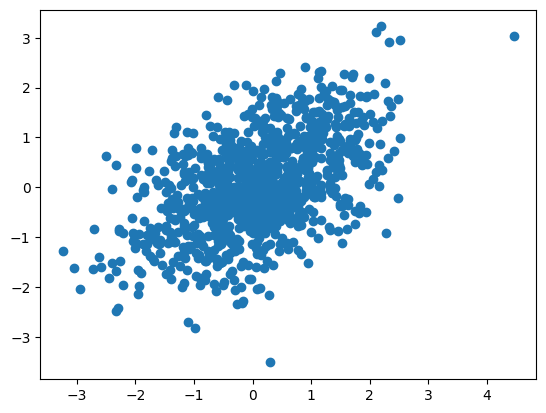

In [68]:
def add_gaussian_noise(X, noise_level=0.01, seed=0):
    mean = 0
    std_dev = noise_level * (np.max(X) - np.min(X))
    np.random.seed(seed)
    noise = np.random.normal(mean, std_dev, X.shape)
    X_noisy = X + noise
    return X_noisy

np.random.seed(1102)
data = np.random.multivariate_normal(np.zeros(3), np.array([[1,0.5,0],[0.5,1,0],[0,0,1]]), 1000)
data = add_gaussian_noise(data, noise_level=0.01, seed=3)
plt.plot(data[:, 0], data[:, 1], 'o')

In [65]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, random_state=42)

In [63]:
X, y = make_classification(n_samples=100, n_features=2, n_informative=2,
                           n_redundant=0, n_clusters_per_class=1, flip_y=0,
                           class_sep=1, random_state=12)

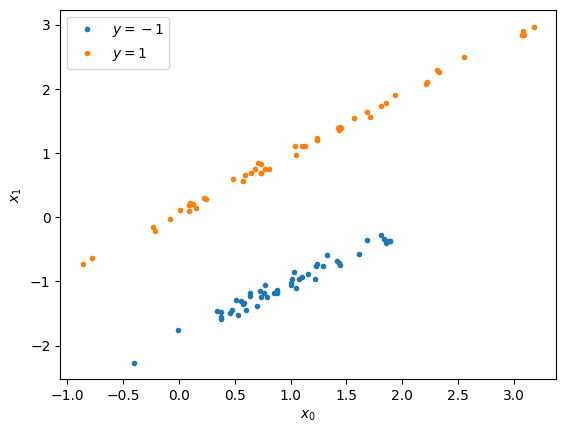

In [66]:
y[y==0] = -1 # encode "negative" class using -1 rather than 0
plt.plot(X[y==-1,0], X[y==-1,1], ".", label="$y = -1$")
plt.plot(X[y==1,0], X[y==1,1], ".", label="$y = 1$")
plt.legend()
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()

In [84]:
def add_gaussian_noise(X, noise_level=0.01):
    mean = 0
    std_dev = noise_level * (np.max(X) - np.min(X))
    noise = np.random.normal(mean, std_dev, X.shape)
    X_noisy = X + noise
    return X_noisy


X_noisy = add_gaussian_noise(X, noise_level=0.01)

In [78]:
def scale_features(X, scale_range=(0.9, 1.1)):
    scales = np.random.uniform(
        low=scale_range[0], high=scale_range[1], size=(X.shape[1],))
    print(scales)
    X_scaled = X * scales
    # print(X_scaled, X)
    return X_scaled
X_noisy = scale_features(X, scale_range=(0.9, 1.1))

[0.97828631 0.99893203]


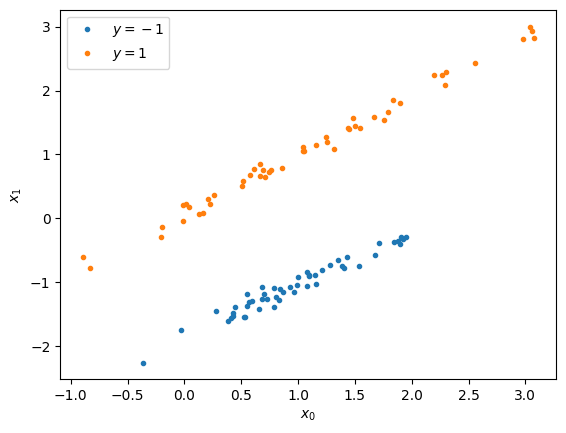

In [85]:
plt.plot(X_noisy[y == -1, 0], X_noisy[y == -1, 1], ".", label="$y = -1$")
plt.plot(X_noisy[y == 1, 0], X_noisy[y == 1, 1], ".", label="$y = 1$")
plt.legend()
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.show()